In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import (big_model_sphere, 
                         aflare, 
                         calculate_specific_flare_flux, 
                         aflare, 
                         calculate_angular_radius)
from funcs.flarefit import log_probability_no_incl

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

In [22]:
tstamp #='16_12_2019_12_25'

'16_12_2019_14_15'

In [23]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [24]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/data/summary/results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
guesses

,prefix,ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot,theta_a_init
0,TIC,237880881,6020,298,1331.82418,0.00194,0.77347,0.02975,0.46626,0.01576,8.43,60.0
1,KIC,100004076,10414,886,1358.52754,0.00072,0.49377,0.02388,0.79166,0.06277,8.88,70.0
2,TIC,44984200,3809,135,1588.02740,0.00106,0.65066,0.03073,0.29153,0.00868,2.71,NaN
3,TIC,277539431,4495,394,1641.86831,0.00291,0.89720,0.08459,0.35356,0.03025,4.56,NaN
4,EPIC,212035340,1954494,483655,3437.83750,0.00029,0.05795,0.00631,29.07702,2.06769,4.63,NaN


In [25]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [6]:
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,dist_err,dist_source,rad,tflux,tlum,kflux,klum,gmag,jmag,kmag
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,0.038400,gaia,0.108176,3.319760e-12,1.119535e+29,6.712990e-13,2.263849e+28,17.8356,13.078,11.771
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,20.512900,mk_dupuy2012,0.115204,6.546160e-13,8.406482e+29,1.394100e-13,1.790276e+29,19.5667,15.894,14.884
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,0.143774,gaia,0.275151,3.492650e-11,8.870689e+30,1.272670e-11,3.232358e+30,14.9796,11.530,10.636
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,0.027472,gaia,0.142339,6.305290e-11,9.308451e+29,2.018160e-11,2.979395e+29,14.4115,10.309,9.268
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,0.106872,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,14.7381,10.630,9.666
5,300741820,8,slc,2,tess,TIC,generic,TESS,NaN,1522.00,...,4.409260,mk_dupuy2012,0.127594,2.711650e-11,1.608939e+30,8.679300e-12,5.149798e+29,15.3277,11.959,11.126


In [7]:
lcs = get_incl(lcs)
lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[1]
target

ID                            212035340
QCS                                  18
typ                                 llc
cadence_min                          30
mission                            ktwo
prefix                             EPIC
origin                          generic
h_mission                            K2
SpT                                  M8
view_start                         3437
view_stop                        3439.5
view_min                            100
view_max                            900
BJDoff                          2454833
tstart                          3437.75
ampl_min                            NaN
ampl_max                            NaN
RA                              129.326
Dec                              20.843
J                                  15.9
R                                   NaN
Gaia_G                          19.5667
vsini_kms                           NaN
e_vsini_kms                         NaN
Prot_d                            0.193


In [8]:
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
from funcs.custom_detrending import refine_detrended_flux_err
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)
print(t)
F = FlareLightCurve(time=t, detrended_flux=sflux, 
                    detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
print(F.detrended_flux_err)
flcd = refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
                                     std_rolling_window_length=15, pad=25)

choice = (t > target.view_start +.5) & (t < target.view_stop-0.5) # only one flare in TIC 237 : + 1.56 - 1.
t = t[choice]
flux = sflux[choice]
flux_err = np.nanmean(flcd.detrended_flux_err)
median = np.nanmean(find_iterative_median(F).it_med)
phi = (t - t[0])/target.Prot_d * 2 * np.pi

pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median}).to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
                                                             index=False)
median

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


EPIC 212035340 modulation period:  4.625968870015097 h
Relative amplitude of modulation: 5.5e-02
[3418.56662914 3418.58706126 3418.60749357 ... 3469.33969273 3469.36012426
 3469.380556  ]
[2.8564715 2.8564715 2.8564715 ... 2.8564715 2.8564715 2.8564715]


128.9160074220364

68

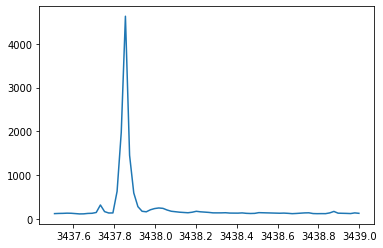

In [9]:
%matplotlib inline
plt.plot(t,flux)
len(t)

In [10]:

#
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median

128.9160074220364

(0.017453292519943295,
 0.7853981633974483,
 10.655958373843376,
 70.84752940117049,
 116.30808)

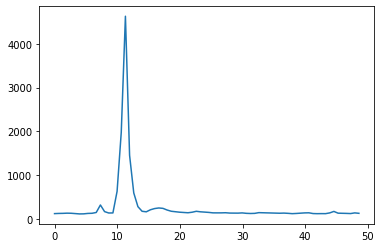

In [11]:

phi_a = (target.t0 - t[0])/target.Prot_d * 2 * np.pi -.1
theta_a = 1.*np.pi/180#target.theta_a_init
a = target.ampl*4
fwhm = target.dur /target.Prot_d * 2 * np.pi/2
i_mu = 45*np.pi/180
i_sigma = 0
qlum = target.klum * u.erg/u.s
R = target.rad * R_sun
phi0 = 240 * np.pi / 180
Fth = calculate_specific_flare_flux("Kepler", flaret=1e4)
phi_a_max = phi[-1]
plt.plot(phi,flux)
radius =calculate_angular_radius(Fth, a, qlum, R,)
theta_a, i_mu, phi_a, radius, a


(0, 1000)

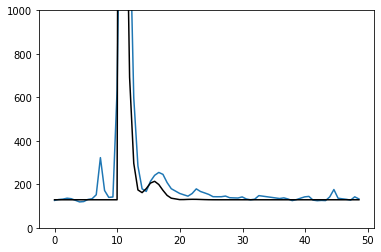

In [12]:
plt.plot(phi,flux)
# for i in range(240,360,15):
#     plt.plot(phi, big_model_sphere(phi_a, theta_a, a, fwhm, i_mu, phi0=i * np.pi / 180,
#                phi=phi, num_pts=50, qlum=qlum,
#                Fth=Fth, R=R, median=median), c="r", alpha=1,)
plt.plot(phi, big_model_sphere(phi_a, theta_a, a, fwhm, i_mu, phi0=240 * np.pi / 180,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(0,1000)

### Save inits

In [13]:
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = "date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,median\n"
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},{median}\n")
   # f.write(firstout)
    f.write(out)

## Run MCMC

In [19]:

inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 6))
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_no_incl,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":None, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                backend=backend)

In [20]:

sampler.run_mcmc(pos,5000, progress=True, store=True);

  2%|▏         | 77/5000 [00:18<20:00,  4.10it/s]

ll error


  2%|▏         | 116/5000 [00:28<20:05,  4.05it/s]

ll error


  2%|▏         | 118/5000 [00:29<19:59,  4.07it/s]

ll error
ll error


  2%|▏         | 122/5000 [00:30<20:06,  4.04it/s]

ll error


  3%|▎         | 137/5000 [00:33<20:01,  4.05it/s]

ll error


  3%|▎         | 145/5000 [00:35<20:25,  3.96it/s]

ll error


  3%|▎         | 164/5000 [00:40<19:52,  4.06it/s]

prior inf


  3%|▎         | 166/5000 [00:41<19:54,  4.05it/s]

prior inf


  3%|▎         | 167/5000 [00:41<19:46,  4.07it/s]

prior inf


  3%|▎         | 168/5000 [00:41<19:55,  4.04it/s]

prior inf


  3%|▎         | 170/5000 [00:42<19:59,  4.03it/s]

prior inf


  3%|▎         | 173/5000 [00:42<19:57,  4.03it/s]

prior inf


  3%|▎         | 174/5000 [00:43<19:59,  4.02it/s]

prior inf


  4%|▎         | 175/5000 [00:43<19:50,  4.05it/s]

prior inf


  4%|▎         | 177/5000 [00:43<19:52,  4.04it/s]

prior inf


  4%|▎         | 179/5000 [00:44<19:49,  4.05it/s]

prior inf


  4%|▎         | 185/5000 [00:45<20:20,  3.95it/s]

prior inf


  4%|▎         | 187/5000 [00:46<20:18,  3.95it/s]

prior inf


  4%|▍         | 213/5000 [00:52<20:15,  3.94it/s]

ll error


  4%|▍         | 225/5000 [00:55<19:38,  4.05it/s]

prior inf


  5%|▍         | 226/5000 [00:56<19:42,  4.04it/s]

prior inf
prior inf


  5%|▍         | 231/5000 [00:57<19:46,  4.02it/s]

ll error


  5%|▍         | 245/5000 [01:01<21:57,  3.61it/s]

ll error


  5%|▍         | 249/5000 [01:02<22:03,  3.59it/s]

prior inf


  5%|▌         | 251/5000 [01:03<21:27,  3.69it/s]

ll error


  5%|▌         | 253/5000 [01:03<21:30,  3.68it/s]

prior inf


  5%|▌         | 256/5000 [01:04<20:24,  3.87it/s]

prior inf


  5%|▌         | 260/5000 [01:05<20:07,  3.93it/s]

ll error


  5%|▌         | 261/5000 [01:05<20:51,  3.79it/s]

prior inf


  5%|▌         | 269/5000 [01:07<20:03,  3.93it/s]

ll error


  5%|▌         | 271/5000 [01:08<20:26,  3.86it/s]

prior inf


  5%|▌         | 273/5000 [01:08<21:15,  3.71it/s]

prior inf
prior inf


  5%|▌         | 274/5000 [01:09<21:21,  3.69it/s]

ll error


  6%|▌         | 275/5000 [01:09<20:51,  3.78it/s]

ll error
ll error
ll error


  6%|▌         | 276/5000 [01:09<20:37,  3.82it/s]

ll error


  6%|▌         | 280/5000 [01:10<21:10,  3.72it/s]

prior inf
prior inf
prior inf


  6%|▌         | 283/5000 [01:11<21:44,  3.62it/s]

prior inf


  6%|▌         | 288/5000 [01:12<20:55,  3.75it/s]

prior inf


  6%|▌         | 290/5000 [01:13<21:21,  3.68it/s]

prior inf
ll error
ll error
ll error
ll error


  6%|▌         | 292/5000 [01:13<20:28,  3.83it/s]

prior inf


  6%|▌         | 295/5000 [01:14<20:10,  3.89it/s]

prior inf


  6%|▌         | 296/5000 [01:14<20:10,  3.88it/s]

ll error
prior inf


  6%|▌         | 298/5000 [01:15<19:55,  3.93it/s]

prior inf
ll error
prior inf


  6%|▌         | 300/5000 [01:16<20:11,  3.88it/s]

ll error
prior inf
ll error
ll error


  6%|▌         | 301/5000 [01:16<20:41,  3.78it/s]

ll error


  6%|▌         | 304/5000 [01:17<20:31,  3.81it/s]

prior inf
prior inf


  6%|▌         | 305/5000 [01:17<20:26,  3.83it/s]

ll error


  6%|▌         | 310/5000 [01:18<20:31,  3.81it/s]

prior inf
prior inf
prior inf


  6%|▌         | 311/5000 [01:18<20:08,  3.88it/s]

prior inf


  6%|▋         | 314/5000 [01:19<19:52,  3.93it/s]

ll error
ll error
prior inf


  6%|▋         | 318/5000 [01:20<20:17,  3.85it/s]

prior inf
prior inf


  6%|▋         | 319/5000 [01:21<20:10,  3.87it/s]

prior inf


  6%|▋         | 320/5000 [01:21<20:39,  3.78it/s]

prior inf
prior inf


  6%|▋         | 322/5000 [01:21<20:08,  3.87it/s]

prior inf
ll error
prior inf
ll error


  6%|▋         | 323/5000 [01:22<19:59,  3.90it/s]

prior inf
prior inf
ll error
prior inf


  6%|▋         | 324/5000 [01:22<19:40,  3.96it/s]

ll error
prior inf
prior inf


  6%|▋         | 325/5000 [01:22<19:27,  4.01it/s]

prior inf


  7%|▋         | 327/5000 [01:23<19:19,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 329/5000 [01:23<19:06,  4.07it/s]

prior inf
prior inf


  7%|▋         | 331/5000 [01:24<19:36,  3.97it/s]

ll error
prior inf
prior inf


  7%|▋         | 333/5000 [01:24<20:34,  3.78it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 335/5000 [01:25<20:12,  3.85it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 336/5000 [01:25<19:59,  3.89it/s]

prior inf
prior inf
prior inf


  7%|▋         | 338/5000 [01:25<18:52,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 339/5000 [01:26<18:46,  4.14it/s]

prior inf
prior inf


  7%|▋         | 340/5000 [01:26<18:35,  4.18it/s]

prior inf
prior inf


  7%|▋         | 341/5000 [01:26<18:55,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 344/5000 [01:27<19:20,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 345/5000 [01:27<19:33,  3.97it/s]

prior inf
ll error


  7%|▋         | 346/5000 [01:27<19:13,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 347/5000 [01:28<19:09,  4.05it/s]

ll error
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 349/5000 [01:28<18:29,  4.19it/s]

prior inf
prior inf
ll error
prior inf
prior inf


  7%|▋         | 350/5000 [01:28<18:51,  4.11it/s]

prior inf
prior inf
ll error


  7%|▋         | 351/5000 [01:28<18:31,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 352/5000 [01:29<19:19,  4.01it/s]

prior inf
prior inf


  7%|▋         | 353/5000 [01:29<20:02,  3.86it/s]

prior inf
prior inf
prior inf


  7%|▋         | 354/5000 [01:29<19:52,  3.90it/s]

prior inf
prior inf


  7%|▋         | 355/5000 [01:30<19:34,  3.95it/s]

prior inf
prior inf


  7%|▋         | 357/5000 [01:30<19:36,  3.95it/s]

ll error
prior inf


  7%|▋         | 358/5000 [01:30<19:16,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 359/5000 [01:31<19:24,  3.99it/s]

prior inf
prior inf
prior inf


  7%|▋         | 360/5000 [01:31<19:32,  3.96it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 361/5000 [01:31<19:43,  3.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 362/5000 [01:31<20:29,  3.77it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 364/5000 [01:32<19:17,  4.01it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 365/5000 [01:32<19:17,  4.00it/s]

prior inf
prior inf
prior inf


  7%|▋         | 366/5000 [01:32<19:19,  4.00it/s]

prior inf
prior inf
prior inf


  7%|▋         | 367/5000 [01:33<19:07,  4.04it/s]

prior inf
prior inf
prior inf
ll error


  7%|▋         | 368/5000 [01:33<18:54,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 369/5000 [01:33<18:41,  4.13it/s]

prior inf
prior inf
prior inf


  7%|▋         | 370/5000 [01:33<18:57,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 371/5000 [01:34<19:43,  3.91it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 372/5000 [01:34<19:24,  3.97it/s]

prior inf
prior inf


  7%|▋         | 374/5000 [01:34<19:36,  3.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 376/5000 [01:35<19:51,  3.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 377/5000 [01:35<19:17,  3.99it/s]

prior inf
prior inf
prior inf


  8%|▊         | 378/5000 [01:35<19:56,  3.86it/s]

prior inf
ll error
prior inf
prior inf
prior inf


  8%|▊         | 380/5000 [01:36<19:02,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 381/5000 [01:36<19:21,  3.98it/s]

prior inf
prior inf
ll error


  8%|▊         | 382/5000 [01:36<19:36,  3.92it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 383/5000 [01:37<19:24,  3.97it/s]

prior inf


  8%|▊         | 385/5000 [01:37<19:08,  4.02it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 387/5000 [01:38<18:50,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 388/5000 [01:38<18:41,  4.11it/s]

prior inf
prior inf


  8%|▊         | 389/5000 [01:38<18:37,  4.13it/s]

prior inf
prior inf
prior inf


  8%|▊         | 391/5000 [01:39<19:07,  4.02it/s]

prior inf
prior inf
prior inf


  8%|▊         | 392/5000 [01:39<19:23,  3.96it/s]

prior inf


  8%|▊         | 394/5000 [01:39<18:54,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error


  8%|▊         | 395/5000 [01:40<19:07,  4.01it/s]

prior inf


  8%|▊         | 396/5000 [01:40<19:22,  3.96it/s]

prior inf
prior inf


  8%|▊         | 397/5000 [01:40<19:16,  3.98it/s]

prior inf
ll error


  8%|▊         | 398/5000 [01:40<19:06,  4.01it/s]

prior inf
ll error
ll error
prior inf


  8%|▊         | 399/5000 [01:41<18:20,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 401/5000 [01:41<18:19,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 403/5000 [01:41<17:56,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error


  8%|▊         | 404/5000 [01:42<18:11,  4.21it/s]

prior inf
prior inf


  8%|▊         | 405/5000 [01:42<18:47,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 406/5000 [01:42<19:07,  4.00it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 407/5000 [01:42<19:34,  3.91it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 408/5000 [01:43<20:20,  3.76it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf


  8%|▊         | 410/5000 [01:43<20:08,  3.80it/s]

ll error
prior inf


  8%|▊         | 411/5000 [01:44<19:53,  3.84it/s]

prior inf
prior inf


  8%|▊         | 412/5000 [01:44<20:01,  3.82it/s]

prior inf
prior inf


  8%|▊         | 413/5000 [01:44<19:53,  3.84it/s]

prior inf
prior inf
prior inf


  8%|▊         | 415/5000 [01:45<19:43,  3.88it/s]

prior inf
ll error
prior inf


  8%|▊         | 417/5000 [01:45<19:39,  3.89it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 418/5000 [01:45<19:22,  3.94it/s]

prior inf


  8%|▊         | 419/5000 [01:46<19:33,  3.90it/s]

prior inf
prior inf
prior inf


  8%|▊         | 421/5000 [01:46<19:22,  3.94it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 423/5000 [01:47<18:55,  4.03it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 424/5000 [01:47<19:37,  3.89it/s]

prior inf


  9%|▊         | 426/5000 [01:47<19:32,  3.90it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf


  9%|▊         | 427/5000 [01:48<19:16,  3.96it/s]

prior inf
prior inf
ll error
prior inf


  9%|▊         | 428/5000 [01:48<19:36,  3.89it/s]

prior inf
prior inf


  9%|▊         | 430/5000 [01:48<19:50,  3.84it/s]

prior inf
prior inf
prior inf


  9%|▊         | 431/5000 [01:49<20:14,  3.76it/s]

prior inf


  9%|▊         | 432/5000 [01:49<19:59,  3.81it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▊         | 433/5000 [01:49<19:55,  3.82it/s]

prior inf
prior inf


  9%|▊         | 434/5000 [01:50<20:05,  3.79it/s]

ll error
prior inf
prior inf
prior inf


  9%|▊         | 436/5000 [01:50<19:27,  3.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▊         | 437/5000 [01:50<19:01,  4.00it/s]

prior inf
ll error
prior inf
ll error


  9%|▉         | 438/5000 [01:50<18:52,  4.03it/s]

prior inf
prior inf
prior inf
prior inf


  9%|▉         | 439/5000 [01:51<19:11,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf


  9%|▉         | 440/5000 [01:51<18:41,  4.06it/s]

prior inf
prior inf
prior inf
ll error


  9%|▉         | 441/5000 [01:51<18:31,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 442/5000 [01:51<18:55,  4.02it/s]

prior inf
prior inf
prior inf


  9%|▉         | 443/5000 [01:52<18:51,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf


  9%|▉         | 444/5000 [01:52<18:53,  4.02it/s]

prior inf
prior inf


  9%|▉         | 445/5000 [01:52<19:04,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 446/5000 [01:52<18:55,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 448/5000 [01:53<18:15,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 449/5000 [01:53<18:10,  4.17it/s]

prior inf
prior inf


  9%|▉         | 450/5000 [01:53<18:10,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 452/5000 [01:54<16:48,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 453/5000 [01:54<16:55,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 454/5000 [01:54<17:01,  4.45it/s]

prior inf
prior inf
ll error
prior inf
prior inf


  9%|▉         | 456/5000 [01:55<17:17,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 457/5000 [01:55<17:59,  4.21it/s]

prior inf
prior inf
prior inf


  9%|▉         | 458/5000 [01:55<18:50,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 459/5000 [01:56<18:18,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 461/5000 [01:56<18:20,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 462/5000 [01:56<17:38,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 463/5000 [01:56<17:37,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 464/5000 [01:57<18:49,  4.02it/s]

prior inf
prior inf
prior inf
prior inf


  9%|▉         | 465/5000 [01:57<19:02,  3.97it/s]

prior inf
prior inf
prior inf


  9%|▉         | 466/5000 [01:57<19:20,  3.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 468/5000 [01:58<19:25,  3.89it/s]

prior inf
prior inf
prior inf


  9%|▉         | 469/5000 [01:58<20:10,  3.74it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 471/5000 [01:59<19:23,  3.89it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 472/5000 [01:59<18:43,  4.03it/s]

prior inf
prior inf
prior inf


  9%|▉         | 473/5000 [01:59<18:32,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 10%|▉         | 475/5000 [02:00<18:46,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 10%|▉         | 476/5000 [02:00<18:34,  4.06it/s]

prior inf
prior inf
prior inf
prior inf


 10%|▉         | 477/5000 [02:00<18:36,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 10%|▉         | 478/5000 [02:00<17:58,  4.19it/s]

prior inf
prior inf


 10%|▉         | 479/5000 [02:01<18:53,  3.99it/s]

prior inf
prior inf
prior inf


 10%|▉         | 480/5000 [02:01<19:02,  3.96it/s]

prior inf
prior inf
prior inf
prior inf


 10%|▉         | 481/5000 [02:01<19:17,  3.91it/s]

prior inf
prior inf
prior inf
prior inf


 10%|▉         | 483/5000 [02:02<19:15,  3.91it/s]

prior inf
prior inf
prior inf


 10%|▉         | 484/5000 [02:02<19:27,  3.87it/s]

prior inf
prior inf


 10%|▉         | 486/5000 [02:02<19:14,  3.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 10%|▉         | 487/5000 [02:03<19:00,  3.96it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 10%|▉         | 488/5000 [02:03<18:24,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 10%|▉         | 490/5000 [02:03<18:17,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 10%|▉         | 491/5000 [02:03<17:53,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 10%|▉         | 492/5000 [02:04<18:20,  4.10it/s]

prior inf
prior inf


 10%|▉         | 493/5000 [02:04<19:35,  3.83it/s]

prior inf
prior inf
prior inf


 10%|▉         | 495/5000 [02:05<19:24,  3.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 10%|▉         | 496/5000 [02:05<19:11,  3.91it/s]

prior inf
prior inf
prior inf


 10%|▉         | 497/5000 [02:05<18:41,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 10%|▉         | 498/5000 [02:05<18:25,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 10%|▉         | 499/5000 [02:06<18:40,  4.02it/s]

prior inf
prior inf


 10%|█         | 500/5000 [02:06<19:40,  3.81it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 502/5000 [02:06<19:23,  3.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 503/5000 [02:07<18:38,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 504/5000 [02:07<18:34,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 506/5000 [02:07<17:52,  4.19it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 507/5000 [02:08<17:49,  4.20it/s]

ll error
prior inf
prior inf
prior inf


 10%|█         | 508/5000 [02:08<17:30,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 509/5000 [02:08<17:36,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 511/5000 [02:08<18:11,  4.11it/s]

prior inf
prior inf
prior inf


 10%|█         | 512/5000 [02:09<18:02,  4.15it/s]

prior inf
prior inf


 10%|█         | 513/5000 [02:09<18:00,  4.15it/s]

prior inf


 10%|█         | 514/5000 [02:09<18:42,  4.00it/s]

prior inf
prior inf
prior inf


 10%|█         | 516/5000 [02:10<19:18,  3.87it/s]

prior inf
prior inf
prior inf


 10%|█         | 517/5000 [02:10<18:48,  3.97it/s]

prior inf
prior inf
prior inf


 10%|█         | 518/5000 [02:10<18:35,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 519/5000 [02:11<18:40,  4.00it/s]

prior inf
prior inf
prior inf
prior inf


 10%|█         | 520/5000 [02:11<17:50,  4.19it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 521/5000 [02:11<17:53,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 523/5000 [02:11<17:18,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 525/5000 [02:12<17:57,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 526/5000 [02:12<18:21,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 528/5000 [02:13<18:01,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 529/5000 [02:13<17:56,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 531/5000 [02:13<18:07,  4.11it/s]

prior inf
prior inf
prior inf


 11%|█         | 532/5000 [02:14<17:48,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 533/5000 [02:14<17:51,  4.17it/s]

prior inf
prior inf
prior inf


 11%|█         | 534/5000 [02:14<17:31,  4.25it/s]

prior inf
prior inf
prior inf


 11%|█         | 535/5000 [02:14<17:40,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 537/5000 [02:15<17:36,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 11%|█         | 538/5000 [02:15<17:48,  4.18it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 11%|█         | 540/5000 [02:15<17:18,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 541/5000 [02:16<17:20,  4.29it/s]

prior inf
prior inf
prior inf


 11%|█         | 542/5000 [02:16<17:33,  4.23it/s]

prior inf
prior inf
prior inf


 11%|█         | 543/5000 [02:16<17:03,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 545/5000 [02:17<17:10,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 547/5000 [02:17<16:41,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 548/5000 [02:17<16:28,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 549/5000 [02:18<16:54,  4.39it/s]

prior inf
prior inf
prior inf
prior inf


 11%|█         | 550/5000 [02:18<17:17,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 11%|█         | 552/5000 [02:18<17:34,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 554/5000 [02:19<17:47,  4.16it/s]

prior inf
prior inf


 11%|█         | 555/5000 [02:19<18:05,  4.10it/s]

prior inf
prior inf
prior inf


 11%|█         | 557/5000 [02:19<18:09,  4.08it/s]

prior inf
prior inf
prior inf
prior inf


 11%|█         | 559/5000 [02:20<17:20,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 560/5000 [02:20<17:07,  4.32it/s]

prior inf
prior inf
prior inf
prior inf


 11%|█         | 561/5000 [02:20<17:30,  4.23it/s]

prior inf
prior inf
prior inf


 11%|█▏        | 563/5000 [02:21<17:18,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█▏        | 564/5000 [02:21<17:09,  4.31it/s]

prior inf
prior inf
prior inf
prior inf


 11%|█▏        | 566/5000 [02:22<16:40,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█▏        | 567/5000 [02:22<17:06,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█▏        | 568/5000 [02:22<17:43,  4.17it/s]

prior inf
prior inf
ll error


 11%|█▏        | 570/5000 [02:23<18:19,  4.03it/s]

prior inf
prior inf
prior inf
ll error
prior inf


 11%|█▏        | 571/5000 [02:23<18:40,  3.95it/s]

prior inf
prior inf


 11%|█▏        | 572/5000 [02:23<18:25,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█▏        | 573/5000 [02:23<18:12,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█▏        | 574/5000 [02:24<18:06,  4.07it/s]

prior inf
prior inf
prior inf


 12%|█▏        | 575/5000 [02:24<18:15,  4.04it/s]

prior inf
prior inf


 12%|█▏        | 576/5000 [02:24<18:19,  4.02it/s]

prior inf
prior inf


 12%|█▏        | 577/5000 [02:24<18:29,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 579/5000 [02:25<18:14,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 581/5000 [02:25<18:20,  4.01it/s]

prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 582/5000 [02:26<18:33,  3.97it/s]

prior inf
prior inf
prior inf


 12%|█▏        | 583/5000 [02:26<18:54,  3.89it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 584/5000 [02:26<18:25,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 586/5000 [02:27<18:25,  3.99it/s]

prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 587/5000 [02:27<17:59,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 589/5000 [02:27<17:21,  4.23it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 590/5000 [02:27<17:09,  4.28it/s]

prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 591/5000 [02:28<16:56,  4.34it/s]

prior inf
prior inf
prior inf


 12%|█▏        | 592/5000 [02:28<17:18,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 593/5000 [02:28<16:49,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 594/5000 [02:28<17:00,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 596/5000 [02:29<17:31,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 598/5000 [02:29<17:27,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 599/5000 [02:30<17:56,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 600/5000 [02:30<18:42,  3.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 602/5000 [02:30<17:15,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 603/5000 [02:31<16:54,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 604/5000 [02:31<17:02,  4.30it/s]

prior inf
prior inf
prior inf


 12%|█▏        | 605/5000 [02:31<17:09,  4.27it/s]

prior inf
prior inf


 12%|█▏        | 606/5000 [02:31<17:18,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 608/5000 [02:32<16:38,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 609/5000 [02:32<16:38,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 610/5000 [02:32<16:45,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 612/5000 [02:33<16:17,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 613/5000 [02:33<16:44,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 614/5000 [02:33<16:23,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 615/5000 [02:33<16:54,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 616/5000 [02:34<16:35,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 618/5000 [02:34<16:28,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 619/5000 [02:34<15:42,  4.65it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 620/5000 [02:34<15:34,  4.69it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 622/5000 [02:35<16:09,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 623/5000 [02:35<15:46,  4.62it/s]

prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 624/5000 [02:35<16:06,  4.53it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 626/5000 [02:36<15:30,  4.70it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 627/5000 [02:36<15:54,  4.58it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 628/5000 [02:36<15:48,  4.61it/s]

prior inf
prior inf


 13%|█▎        | 629/5000 [02:36<16:11,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 631/5000 [02:37<15:49,  4.60it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 632/5000 [02:37<15:31,  4.69it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 634/5000 [02:37<16:18,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 635/5000 [02:38<16:02,  4.54it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 636/5000 [02:38<16:02,  4.53it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 638/5000 [02:38<16:27,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 639/5000 [02:39<16:15,  4.47it/s]

prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 640/5000 [02:39<16:35,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 641/5000 [02:39<16:12,  4.48it/s]

prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 642/5000 [02:39<16:38,  4.36it/s]

prior inf
prior inf
prior inf


 13%|█▎        | 643/5000 [02:40<16:59,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 644/5000 [02:40<17:18,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 645/5000 [02:40<17:56,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 647/5000 [02:40<16:46,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 648/5000 [02:41<17:59,  4.03it/s]

prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 649/5000 [02:41<18:03,  4.02it/s]

prior inf
prior inf


 13%|█▎        | 650/5000 [02:41<18:39,  3.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 651/5000 [02:42<18:33,  3.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 652/5000 [02:42<17:40,  4.10it/s]

prior inf
prior inf
prior inf


 13%|█▎        | 653/5000 [02:42<18:11,  3.98it/s]

prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 654/5000 [02:42<18:20,  3.95it/s]

prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 655/5000 [02:43<17:52,  4.05it/s]

prior inf
prior inf
prior inf


 13%|█▎        | 656/5000 [02:43<17:35,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 657/5000 [02:43<16:50,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 659/5000 [02:43<17:13,  4.20it/s]

prior inf
prior inf
prior inf
ll error
prior inf


 13%|█▎        | 661/5000 [02:44<18:37,  3.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 662/5000 [02:44<18:10,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 663/5000 [02:44<17:50,  4.05it/s]

prior inf
prior inf
prior inf
prior inf

 13%|█▎        | 664/5000 [02:45<17:49,  4.05it/s]


prior inf
prior inf


 13%|█▎        | 665/5000 [02:45<18:29,  3.91it/s]

prior inf
prior inf
prior inf


 13%|█▎        | 666/5000 [02:45<18:26,  3.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 668/5000 [02:46<17:16,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 669/5000 [02:46<16:51,  4.28it/s]

prior inf
prior inf
prior inf


 13%|█▎        | 670/5000 [02:46<17:28,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 671/5000 [02:46<16:59,  4.25it/s]

prior inf
prior inf


 13%|█▎        | 672/5000 [02:47<17:37,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 674/5000 [02:47<17:33,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▎        | 675/5000 [02:47<17:00,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▎        | 677/5000 [02:48<16:16,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▎        | 678/5000 [02:48<16:11,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▎        | 679/5000 [02:48<16:09,  4.46it/s]

prior inf
prior inf
prior inf


 14%|█▎        | 680/5000 [02:48<15:56,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▎        | 681/5000 [02:49<16:42,  4.31it/s]

prior inf
prior inf
prior inf
prior inf


 14%|█▎        | 682/5000 [02:49<16:31,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▎        | 683/5000 [02:49<16:27,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▎        | 684/5000 [02:49<17:39,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▎        | 685/5000 [02:50<17:28,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
ll error


 14%|█▎        | 687/5000 [02:50<18:11,  3.95it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 688/5000 [02:50<18:01,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 689/5000 [02:51<18:13,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 690/5000 [02:51<17:34,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 691/5000 [02:51<17:40,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 693/5000 [02:52<17:21,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 694/5000 [02:52<17:11,  4.17it/s]

prior inf
prior inf
ll error
prior inf
prior inf


 14%|█▍        | 696/5000 [02:52<16:33,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 697/5000 [02:53<16:56,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 698/5000 [02:53<17:16,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 699/5000 [02:53<17:34,  4.08it/s]

prior inf
prior inf


 14%|█▍        | 700/5000 [02:53<17:58,  3.99it/s]

prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 701/5000 [02:54<18:44,  3.82it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 702/5000 [02:54<18:23,  3.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 703/5000 [02:54<18:15,  3.92it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 705/5000 [02:55<18:06,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 706/5000 [02:55<17:57,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 707/5000 [02:55<17:29,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 708/5000 [02:55<17:50,  4.01it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 710/5000 [02:56<17:22,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 711/5000 [02:56<17:40,  4.05it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 712/5000 [02:56<17:49,  4.01it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 713/5000 [02:57<18:36,  3.84it/s]

prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 714/5000 [02:57<18:19,  3.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 715/5000 [02:57<18:35,  3.84it/s]

prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 716/5000 [02:57<18:52,  3.78it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 717/5000 [02:58<18:08,  3.94it/s]

prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 719/5000 [02:58<17:38,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 720/5000 [02:58<17:36,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 721/5000 [02:59<17:31,  4.07it/s]

prior inf
prior inf


 14%|█▍        | 722/5000 [02:59<18:11,  3.92it/s]

prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 723/5000 [02:59<18:23,  3.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 14%|█▍        | 724/5000 [02:59<17:44,  4.02it/s]

prior inf
prior inf
prior inf


 15%|█▍        | 726/5000 [03:00<18:15,  3.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 727/5000 [03:00<17:58,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 728/5000 [03:01<18:37,  3.82it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 729/5000 [03:01<18:01,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 730/5000 [03:01<17:14,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 731/5000 [03:01<17:02,  4.18it/s]

prior inf
prior inf
prior inf


 15%|█▍        | 733/5000 [03:02<16:59,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 734/5000 [03:02<16:50,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 736/5000 [03:02<17:23,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 737/5000 [03:03<17:12,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 739/5000 [03:03<16:36,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 740/5000 [03:03<16:24,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 742/5000 [03:04<16:22,  4.34it/s]

prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 743/5000 [03:04<16:32,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 744/5000 [03:04<16:42,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 745/5000 [03:05<16:41,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 747/5000 [03:05<16:03,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▍        | 749/5000 [03:05<16:13,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 750/5000 [03:06<16:11,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 751/5000 [03:06<16:16,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 753/5000 [03:06<16:14,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 754/5000 [03:07<16:03,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 756/5000 [03:07<15:55,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 757/5000 [03:07<16:10,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 758/5000 [03:07<15:59,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 759/5000 [03:08<15:50,  4.46it/s]

prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 760/5000 [03:08<16:17,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 762/5000 [03:08<16:10,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 763/5000 [03:09<16:35,  4.26it/s]

prior inf
prior inf


 15%|█▌        | 764/5000 [03:09<16:54,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 765/5000 [03:09<17:14,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 766/5000 [03:09<17:00,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 767/5000 [03:10<17:15,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 769/5000 [03:10<18:07,  3.89it/s]

prior inf
prior inf
ll error
prior inf


 15%|█▌        | 770/5000 [03:10<17:53,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 771/5000 [03:11<17:55,  3.93it/s]

prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 773/5000 [03:11<17:27,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 774/5000 [03:11<17:48,  3.96it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 775/5000 [03:12<18:02,  3.90it/s]

prior inf
prior inf


 16%|█▌        | 776/5000 [03:12<17:39,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 777/5000 [03:12<17:15,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 778/5000 [03:12<17:47,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 779/5000 [03:13<17:55,  3.92it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 780/5000 [03:13<17:57,  3.92it/s]

prior inf
prior inf


 16%|█▌        | 781/5000 [03:13<18:19,  3.84it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 782/5000 [03:13<18:31,  3.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 783/5000 [03:14<18:15,  3.85it/s]

prior inf
prior inf


 16%|█▌        | 784/5000 [03:14<18:05,  3.88it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 785/5000 [03:14<17:57,  3.91it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 787/5000 [03:15<17:25,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 788/5000 [03:15<17:24,  4.03it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 790/5000 [03:15<17:52,  3.93it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 791/5000 [03:16<17:52,  3.93it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 792/5000 [03:16<17:44,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 793/5000 [03:16<17:26,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 794/5000 [03:16<17:20,  4.04it/s]

prior inf
prior inf


 16%|█▌        | 795/5000 [03:17<17:36,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 797/5000 [03:17<17:36,  3.98it/s]

prior inf
prior inf


 16%|█▌        | 798/5000 [03:18<17:54,  3.91it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 799/5000 [03:18<18:37,  3.76it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 801/5000 [03:18<18:08,  3.86it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 802/5000 [03:19<17:48,  3.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 803/5000 [03:19<17:22,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 804/5000 [03:19<17:34,  3.98it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 806/5000 [03:20<16:54,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 807/5000 [03:20<17:21,  4.02it/s]

prior inf


 16%|█▌        | 808/5000 [03:20<17:53,  3.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▌        | 809/5000 [03:20<17:39,  3.95it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 811/5000 [03:21<17:40,  3.95it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 812/5000 [03:21<17:54,  3.90it/s]

prior inf
prior inf
prior inf


 16%|█▋        | 813/5000 [03:21<18:19,  3.81it/s]

prior inf
prior inf


 16%|█▋        | 814/5000 [03:22<18:47,  3.71it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▋        | 815/5000 [03:22<18:11,  3.83it/s]

prior inf
prior inf
prior inf


 16%|█▋        | 818/5000 [03:23<18:02,  3.86it/s]

prior inf
prior inf
prior inf


 16%|█▋        | 819/5000 [03:23<17:52,  3.90it/s]

prior inf
prior inf
prior inf
ll error


 16%|█▋        | 820/5000 [03:23<17:21,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▋        | 821/5000 [03:23<17:17,  4.03it/s]

prior inf
prior inf
prior inf
prior inf


 16%|█▋        | 823/5000 [03:24<17:11,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 16%|█▋        | 825/5000 [03:24<17:01,  4.09it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 826/5000 [03:25<17:02,  4.08it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 827/5000 [03:25<16:42,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 829/5000 [03:25<16:49,  4.13it/s]

prior inf
prior inf


 17%|█▋        | 830/5000 [03:26<17:16,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 831/5000 [03:26<17:53,  3.88it/s]

prior inf
prior inf


 17%|█▋        | 832/5000 [03:26<17:45,  3.91it/s]

prior inf
prior inf


 17%|█▋        | 833/5000 [03:26<17:35,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 834/5000 [03:27<17:11,  4.04it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 836/5000 [03:27<17:09,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 837/5000 [03:27<16:59,  4.08it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 839/5000 [03:28<16:44,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 840/5000 [03:28<16:50,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 841/5000 [03:28<16:52,  4.11it/s]

prior inf
prior inf
prior inf
ll error


 17%|█▋        | 842/5000 [03:29<16:15,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 843/5000 [03:29<16:36,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 844/5000 [03:29<17:01,  4.07it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 845/5000 [03:29<17:14,  4.02it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 847/5000 [03:30<17:38,  3.92it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 848/5000 [03:30<17:18,  4.00it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 849/5000 [03:30<16:58,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 851/5000 [03:31<16:59,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 852/5000 [03:31<16:49,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 853/5000 [03:31<16:59,  4.07it/s]

prior inf
prior inf
ll error
prior inf
prior inf


 17%|█▋        | 854/5000 [03:32<17:14,  4.01it/s]

prior inf
prior inf


 17%|█▋        | 855/5000 [03:32<17:30,  3.94it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 856/5000 [03:32<17:54,  3.86it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 857/5000 [03:32<17:15,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 858/5000 [03:33<17:01,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 860/5000 [03:33<16:58,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 17%|█▋        | 861/5000 [03:33<17:21,  3.97it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 17%|█▋        | 862/5000 [03:34<16:57,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 863/5000 [03:34<17:01,  4.05it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 864/5000 [03:34<17:22,  3.97it/s]

prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 865/5000 [03:34<17:24,  3.96it/s]

prior inf
prior inf
prior inf


 17%|█▋        | 866/5000 [03:35<17:24,  3.96it/s]

ll error
prior inf
prior inf


 17%|█▋        | 868/5000 [03:35<17:32,  3.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 869/5000 [03:35<16:31,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 871/5000 [03:36<15:09,  4.54it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 872/5000 [03:36<15:27,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 17%|█▋        | 873/5000 [03:36<15:39,  4.39it/s]

prior inf


 17%|█▋        | 874/5000 [03:36<16:13,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 875/5000 [03:37<16:01,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 876/5000 [03:37<15:38,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 878/5000 [03:37<15:17,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 879/5000 [03:38<15:55,  4.31it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 880/5000 [03:38<16:02,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 881/5000 [03:38<15:35,  4.40it/s]

prior inf
prior inf
prior inf


 18%|█▊        | 882/5000 [03:38<15:56,  4.31it/s]

prior inf
ll error
prior inf
prior inf
prior inf


 18%|█▊        | 884/5000 [03:39<15:33,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 885/5000 [03:39<15:23,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 886/5000 [03:39<15:33,  4.41it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 888/5000 [03:40<16:05,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 889/5000 [03:40<15:59,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 890/5000 [03:40<15:55,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 891/5000 [03:40<15:59,  4.28it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 893/5000 [03:41<16:00,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 894/5000 [03:41<16:13,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 896/5000 [03:41<16:02,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 897/5000 [03:42<15:52,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 899/5000 [03:42<15:51,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 900/5000 [03:42<16:08,  4.23it/s]

prior inf
prior inf
prior inf


 18%|█▊        | 902/5000 [03:43<15:25,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 18%|█▊        | 903/5000 [03:43<15:10,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 904/5000 [03:43<15:33,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 905/5000 [03:44<15:25,  4.43it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 907/5000 [03:44<15:24,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 908/5000 [03:44<15:11,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 910/5000 [03:45<15:21,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 911/5000 [03:45<15:33,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 912/5000 [03:45<15:07,  4.50it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 914/5000 [03:46<15:22,  4.43it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 915/5000 [03:46<15:08,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 917/5000 [03:46<14:55,  4.56it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 919/5000 [03:47<15:13,  4.47it/s]

prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 920/5000 [03:47<15:16,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 921/5000 [03:47<15:14,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 923/5000 [03:48<15:08,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 18%|█▊        | 924/5000 [03:48<15:43,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 926/5000 [03:48<15:56,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 927/5000 [03:49<15:48,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 928/5000 [03:49<15:33,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 930/5000 [03:49<15:18,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 931/5000 [03:49<15:41,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 932/5000 [03:50<15:39,  4.33it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 933/5000 [03:50<15:58,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 934/5000 [03:50<15:47,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 936/5000 [03:51<15:48,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▊        | 937/5000 [03:51<16:01,  4.23it/s]

prior inf
prior inf


 19%|█▉        | 938/5000 [03:51<16:20,  4.14it/s]

prior inf
prior inf
prior inf


 19%|█▉        | 939/5000 [03:51<16:38,  4.07it/s]

prior inf
prior inf
prior inf


 19%|█▉        | 940/5000 [03:52<17:04,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 941/5000 [03:52<16:31,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 942/5000 [03:52<16:05,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 944/5000 [03:53<15:39,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 945/5000 [03:53<15:27,  4.37it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 946/5000 [03:53<15:32,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 947/5000 [03:53<15:24,  4.38it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 948/5000 [03:53<15:27,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 950/5000 [03:54<15:06,  4.47it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 952/5000 [03:54<15:49,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 953/5000 [03:55<16:01,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 955/5000 [03:55<15:18,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 956/5000 [03:55<16:02,  4.20it/s]

prior inf
prior inf
prior inf


 19%|█▉        | 957/5000 [03:56<16:02,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 958/5000 [03:56<15:57,  4.22it/s]

prior inf
prior inf


 19%|█▉        | 960/5000 [03:56<16:05,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 961/5000 [03:57<16:08,  4.17it/s]

prior inf
prior inf
prior inf


 19%|█▉        | 962/5000 [03:57<15:56,  4.22it/s]

prior inf
prior inf
prior inf


 19%|█▉        | 964/5000 [03:57<15:21,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 965/5000 [03:57<15:40,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 967/5000 [03:58<15:43,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 968/5000 [03:58<15:58,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 969/5000 [03:58<16:08,  4.16it/s]

prior inf
prior inf
prior inf


 19%|█▉        | 970/5000 [03:59<16:02,  4.19it/s]

prior inf
prior inf
prior inf


 19%|█▉        | 971/5000 [03:59<16:20,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 19%|█▉        | 973/5000 [03:59<16:09,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 975/5000 [04:00<16:04,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 976/5000 [04:00<15:45,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 977/5000 [04:00<16:00,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 979/5000 [04:01<15:27,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 980/5000 [04:01<14:54,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 981/5000 [04:01<14:58,  4.47it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 982/5000 [04:01<15:11,  4.41it/s]

prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 983/5000 [04:02<15:27,  4.33it/s]

prior inf
prior inf
prior inf


 20%|█▉        | 984/5000 [04:02<15:30,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 985/5000 [04:02<15:24,  4.34it/s]

prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 986/5000 [04:02<15:31,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 987/5000 [04:03<15:33,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 989/5000 [04:03<15:21,  4.35it/s]

prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 990/5000 [04:03<15:54,  4.20it/s]

prior inf
prior inf
prior inf


 20%|█▉        | 991/5000 [04:04<15:51,  4.21it/s]

prior inf
prior inf
prior inf


 20%|█▉        | 992/5000 [04:04<15:45,  4.24it/s]

prior inf
prior inf
prior inf


 20%|█▉        | 994/5000 [04:04<16:16,  4.10it/s]

prior inf
prior inf
prior inf


 20%|█▉        | 995/5000 [04:05<16:15,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 996/5000 [04:05<15:35,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|█▉        | 998/5000 [04:05<15:18,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1000/5000 [04:06<15:08,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1001/5000 [04:06<15:25,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1002/5000 [04:06<15:06,  4.41it/s]

prior inf
prior inf
prior inf


 20%|██        | 1003/5000 [04:06<15:40,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 20%|██        | 1004/5000 [04:07<15:34,  4.28it/s]

prior inf
prior inf
prior inf


 20%|██        | 1006/5000 [04:07<15:34,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1007/5000 [04:07<15:59,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 20%|██        | 1009/5000 [04:08<15:54,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 20%|██        | 1010/5000 [04:08<16:51,  3.94it/s]

prior inf
prior inf
prior inf


 20%|██        | 1011/5000 [04:08<16:37,  4.00it/s]

prior inf
prior inf
prior inf
prior inf


 20%|██        | 1013/5000 [04:09<15:39,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1014/5000 [04:09<15:35,  4.26it/s]

prior inf
prior inf
prior inf


 20%|██        | 1015/5000 [04:09<15:40,  4.24it/s]

prior inf
prior inf
prior inf


 20%|██        | 1017/5000 [04:10<15:08,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1018/5000 [04:10<15:15,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1019/5000 [04:10<15:16,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1020/5000 [04:10<15:05,  4.39it/s]

prior inf
prior inf
prior inf


 20%|██        | 1021/5000 [04:11<15:14,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1023/5000 [04:11<15:16,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 20%|██        | 1025/5000 [04:12<15:27,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1026/5000 [04:12<15:52,  4.17it/s]

prior inf
prior inf
prior inf


 21%|██        | 1027/5000 [04:12<15:41,  4.22it/s]

prior inf
prior inf
prior inf


 21%|██        | 1028/5000 [04:12<16:04,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1029/5000 [04:12<15:55,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1031/5000 [04:13<15:52,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1032/5000 [04:13<15:38,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1034/5000 [04:14<15:22,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1035/5000 [04:14<14:54,  4.43it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1036/5000 [04:14<15:06,  4.37it/s]

prior inf
prior inf
prior inf


 21%|██        | 1037/5000 [04:14<15:10,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1038/5000 [04:15<14:53,  4.44it/s]

prior inf
prior inf
prior inf
prior inf


 21%|██        | 1039/5000 [04:15<15:04,  4.38it/s]

prior inf
prior inf


 21%|██        | 1041/5000 [04:15<14:20,  4.60it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1042/5000 [04:15<14:48,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1043/5000 [04:16<14:55,  4.42it/s]

prior inf
prior inf
prior inf


 21%|██        | 1044/5000 [04:16<15:00,  4.39it/s]

prior inf
prior inf
prior inf


 21%|██        | 1046/5000 [04:16<16:38,  3.96it/s]

prior inf
prior inf
prior inf


 21%|██        | 1047/5000 [04:17<16:15,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1048/5000 [04:17<16:30,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1049/5000 [04:17<16:29,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1050/5000 [04:17<16:10,  4.07it/s]

prior inf
prior inf
prior inf
prior inf


 21%|██        | 1051/5000 [04:18<16:23,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1052/5000 [04:18<16:07,  4.08it/s]

prior inf
prior inf
ll error
prior inf


 21%|██        | 1053/5000 [04:18<16:34,  3.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1054/5000 [04:18<16:18,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1055/5000 [04:19<16:01,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1057/5000 [04:19<15:45,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1058/5000 [04:19<16:06,  4.08it/s]

prior inf
prior inf
prior inf


 21%|██        | 1059/5000 [04:20<16:13,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██        | 1060/5000 [04:20<15:57,  4.11it/s]

prior inf
prior inf
prior inf


 21%|██        | 1062/5000 [04:20<16:19,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1063/5000 [04:21<16:07,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1064/5000 [04:21<15:49,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1065/5000 [04:21<15:59,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1066/5000 [04:21<15:58,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1068/5000 [04:22<15:14,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1069/5000 [04:22<15:48,  4.15it/s]

prior inf
prior inf
prior inf


 21%|██▏       | 1070/5000 [04:22<15:53,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1071/5000 [04:23<16:40,  3.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1072/5000 [04:23<16:25,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1073/5000 [04:23<16:27,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 21%|██▏       | 1074/5000 [04:23<15:59,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1075/5000 [04:24<15:49,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1076/5000 [04:24<15:11,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1077/5000 [04:24<14:54,  4.39it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1078/5000 [04:24<14:45,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1079/5000 [04:24<14:29,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1080/5000 [04:25<14:31,  4.50it/s]

prior inf
prior inf
prior inf


 22%|██▏       | 1081/5000 [04:25<15:08,  4.32it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1082/5000 [04:25<15:07,  4.32it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1083/5000 [04:25<15:10,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1085/5000 [04:26<14:51,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1086/5000 [04:26<15:13,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1087/5000 [04:26<14:57,  4.36it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1089/5000 [04:27<15:19,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1090/5000 [04:27<15:26,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1091/5000 [04:27<15:19,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1093/5000 [04:28<14:59,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1094/5000 [04:28<14:50,  4.39it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1095/5000 [04:28<15:11,  4.28it/s]

prior inf
prior inf
prior inf


 22%|██▏       | 1097/5000 [04:29<14:29,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1098/5000 [04:29<14:55,  4.36it/s]

prior inf


 22%|██▏       | 1099/5000 [04:29<14:56,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1100/5000 [04:29<15:46,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1101/5000 [04:30<15:40,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1102/5000 [04:30<15:48,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1103/5000 [04:30<15:44,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1105/5000 [04:31<15:20,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1106/5000 [04:31<14:39,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1107/5000 [04:31<14:45,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1108/5000 [04:31<14:39,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1110/5000 [04:32<14:51,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1111/5000 [04:32<15:05,  4.30it/s]

prior inf
prior inf
prior inf


 22%|██▏       | 1113/5000 [04:32<15:10,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1114/5000 [04:33<14:47,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1115/5000 [04:33<14:24,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1117/5000 [04:33<15:09,  4.27it/s]

prior inf
prior inf


 22%|██▏       | 1118/5000 [04:33<15:17,  4.23it/s]

prior inf
prior inf


 22%|██▏       | 1120/5000 [04:34<15:10,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1121/5000 [04:34<15:16,  4.23it/s]

prior inf
prior inf
prior inf


 22%|██▏       | 1122/5000 [04:34<15:20,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▏       | 1123/5000 [04:35<14:39,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 22%|██▎       | 1125/5000 [04:35<14:38,  4.41it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1126/5000 [04:35<14:13,  4.54it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1127/5000 [04:36<14:19,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1128/5000 [04:36<14:24,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1130/5000 [04:36<14:30,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 23%|██▎       | 1131/5000 [04:36<14:46,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1132/5000 [04:37<14:26,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1134/5000 [04:37<14:57,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 23%|██▎       | 1135/5000 [04:37<14:39,  4.39it/s]


prior inf
prior inf
prior inf


 23%|██▎       | 1136/5000 [04:38<15:02,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1137/5000 [04:38<14:50,  4.34it/s]

prior inf
prior inf
prior inf


 23%|██▎       | 1139/5000 [04:38<14:41,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1140/5000 [04:39<15:05,  4.26it/s]

prior inf
prior inf


 23%|██▎       | 1141/5000 [04:39<15:27,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1142/5000 [04:39<14:59,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1144/5000 [04:39<14:51,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1145/5000 [04:40<14:39,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1146/5000 [04:40<14:43,  4.36it/s]

prior inf
prior inf
prior inf


 23%|██▎       | 1147/5000 [04:40<14:47,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1148/5000 [04:40<14:51,  4.32it/s]

prior inf
prior inf
prior inf


 23%|██▎       | 1149/5000 [04:41<15:01,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1150/5000 [04:41<15:00,  4.28it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1152/5000 [04:41<15:24,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1153/5000 [04:42<15:18,  4.19it/s]

prior inf
prior inf
prior inf


 23%|██▎       | 1155/5000 [04:42<15:24,  4.16it/s]

prior inf
prior inf
prior inf


 23%|██▎       | 1157/5000 [04:43<15:58,  4.01it/s]

prior inf
prior inf
ll error


 23%|██▎       | 1158/5000 [04:43<16:12,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1159/5000 [04:43<16:01,  4.00it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1160/5000 [04:43<16:35,  3.86it/s]

prior inf
prior inf
prior inf


 23%|██▎       | 1161/5000 [04:44<16:37,  3.85it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1162/5000 [04:44<16:33,  3.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1163/5000 [04:44<16:39,  3.84it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1164/5000 [04:44<16:20,  3.91it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1165/5000 [04:45<16:10,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1166/5000 [04:45<16:31,  3.87it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1167/5000 [04:45<16:31,  3.87it/s]

prior inf
prior inf


 23%|██▎       | 1168/5000 [04:45<16:39,  3.84it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1169/5000 [04:46<16:40,  3.83it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1171/5000 [04:46<15:47,  4.04it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1172/5000 [04:46<15:21,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 23%|██▎       | 1173/5000 [04:47<15:40,  4.07it/s]

prior inf
prior inf
prior inf


 23%|██▎       | 1174/5000 [04:47<16:07,  3.96it/s]

prior inf
prior inf
prior inf


 24%|██▎       | 1175/5000 [04:47<16:39,  3.83it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1176/5000 [04:47<16:34,  3.85it/s]

prior inf
prior inf


 24%|██▎       | 1177/5000 [04:48<16:26,  3.88it/s]

prior inf


 24%|██▎       | 1179/5000 [04:48<16:02,  3.97it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1180/5000 [04:48<15:49,  4.02it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1181/5000 [04:49<15:09,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1182/5000 [04:49<15:15,  4.17it/s]

prior inf
prior inf


 24%|██▎       | 1183/5000 [04:49<15:23,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1184/5000 [04:49<15:48,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1185/5000 [04:50<15:30,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▎       | 1187/5000 [04:50<15:23,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1188/5000 [04:50<15:19,  4.15it/s]

prior inf
prior inf
prior inf


 24%|██▍       | 1189/5000 [04:51<15:21,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1190/5000 [04:51<15:30,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1192/5000 [04:51<15:57,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1193/5000 [04:52<16:15,  3.90it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1195/5000 [04:52<15:44,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1196/5000 [04:52<15:32,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1198/5000 [04:53<15:41,  4.04it/s]

prior inf
prior inf
prior inf


 24%|██▍       | 1199/5000 [04:53<15:15,  4.15it/s]

prior inf
ll error
prior inf
prior inf
prior inf


 24%|██▍       | 1200/5000 [04:53<15:16,  4.15it/s]

ll error
prior inf
prior inf


 24%|██▍       | 1201/5000 [04:54<15:30,  4.08it/s]

prior inf
prior inf
prior inf


 24%|██▍       | 1202/5000 [04:54<15:48,  4.01it/s]

prior inf
prior inf


 24%|██▍       | 1203/5000 [04:54<15:41,  4.03it/s]

prior inf
prior inf
prior inf


 24%|██▍       | 1205/5000 [04:55<15:34,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1206/5000 [04:55<15:15,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1208/5000 [04:55<15:10,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1209/5000 [04:56<14:49,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1210/5000 [04:56<14:53,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1211/5000 [04:56<14:38,  4.31it/s]

prior inf
prior inf
ll error


 24%|██▍       | 1212/5000 [04:56<15:05,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1213/5000 [04:56<15:16,  4.13it/s]

prior inf
ll error


 24%|██▍       | 1214/5000 [04:57<15:20,  4.11it/s]

prior inf
prior inf


 24%|██▍       | 1215/5000 [04:57<15:42,  4.02it/s]

prior inf


 24%|██▍       | 1217/5000 [04:57<15:21,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1218/5000 [04:58<15:10,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1219/5000 [04:58<14:47,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1220/5000 [04:58<15:03,  4.18it/s]

prior inf
prior inf
prior inf


 24%|██▍       | 1221/5000 [04:58<14:51,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1222/5000 [04:59<14:50,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1224/5000 [04:59<14:53,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 24%|██▍       | 1225/5000 [04:59<15:14,  4.13it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 25%|██▍       | 1227/5000 [05:00<15:01,  4.19it/s]

prior inf
prior inf
prior inf


 25%|██▍       | 1228/5000 [05:00<15:23,  4.09it/s]

prior inf
prior inf


 25%|██▍       | 1229/5000 [05:00<15:30,  4.05it/s]

prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1231/5000 [05:01<14:58,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1232/5000 [05:01<15:15,  4.12it/s]

prior inf
prior inf
prior inf


 25%|██▍       | 1233/5000 [05:01<15:06,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1235/5000 [05:02<15:03,  4.17it/s]

prior inf
prior inf
prior inf


 25%|██▍       | 1236/5000 [05:02<15:19,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1237/5000 [05:02<15:12,  4.12it/s]

prior inf
prior inf
prior inf


 25%|██▍       | 1238/5000 [05:03<15:10,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1239/5000 [05:03<15:05,  4.15it/s]

prior inf


 25%|██▍       | 1240/5000 [05:03<15:03,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1243/5000 [05:04<15:28,  4.05it/s]

prior inf
prior inf
prior inf


 25%|██▍       | 1244/5000 [05:04<15:38,  4.00it/s]

prior inf
prior inf
prior inf


 25%|██▍       | 1245/5000 [05:04<15:27,  4.05it/s]

prior inf
prior inf


 25%|██▍       | 1246/5000 [05:04<15:05,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▍       | 1247/5000 [05:05<15:05,  4.14it/s]

prior inf


 25%|██▍       | 1248/5000 [05:05<15:31,  4.03it/s]

prior inf
prior inf
prior inf


 25%|██▍       | 1249/5000 [05:05<15:22,  4.07it/s]

prior inf
prior inf


 25%|██▌       | 1251/5000 [05:06<14:58,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1252/5000 [05:06<14:58,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1254/5000 [05:06<15:06,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1255/5000 [05:07<14:31,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1257/5000 [05:07<14:21,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1258/5000 [05:07<14:47,  4.22it/s]

prior inf
prior inf


 25%|██▌       | 1259/5000 [05:08<14:49,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1260/5000 [05:08<14:44,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1262/5000 [05:08<14:34,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1264/5000 [05:09<14:24,  4.32it/s]

prior inf
prior inf
prior inf


 25%|██▌       | 1265/5000 [05:09<14:26,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1266/5000 [05:09<14:36,  4.26it/s]

prior inf
prior inf


 25%|██▌       | 1267/5000 [05:09<14:50,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1268/5000 [05:10<15:15,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1269/5000 [05:10<14:51,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1270/5000 [05:10<14:54,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1272/5000 [05:11<15:02,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1273/5000 [05:11<15:16,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 25%|██▌       | 1274/5000 [05:11<14:51,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1275/5000 [05:11<14:41,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1276/5000 [05:12<14:40,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1278/5000 [05:12<14:48,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1279/5000 [05:12<14:47,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1281/5000 [05:13<14:54,  4.16it/s]

prior inf
prior inf
prior inf


 26%|██▌       | 1282/5000 [05:13<14:56,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1283/5000 [05:13<14:36,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1284/5000 [05:14<14:28,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1286/5000 [05:14<14:01,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1287/5000 [05:14<14:10,  4.36it/s]

prior inf
prior inf
prior inf


 26%|██▌       | 1288/5000 [05:14<14:58,  4.13it/s]

prior inf
prior inf


 26%|██▌       | 1289/5000 [05:15<15:46,  3.92it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1290/5000 [05:15<15:40,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1291/5000 [05:15<15:16,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1293/5000 [05:16<15:05,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1294/5000 [05:16<15:04,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1296/5000 [05:16<15:17,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1297/5000 [05:17<15:08,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1298/5000 [05:17<15:20,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1299/5000 [05:17<15:24,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1301/5000 [05:18<15:05,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1302/5000 [05:18<14:57,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1303/5000 [05:18<14:57,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1304/5000 [05:18<14:44,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 26%|██▌       | 1306/5000 [05:19<14:29,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1307/5000 [05:19<14:37,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1308/5000 [05:19<14:44,  4.17it/s]

prior inf


 26%|██▌       | 1309/5000 [05:20<15:14,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1310/5000 [05:20<14:54,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▌       | 1312/5000 [05:20<14:24,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1313/5000 [05:21<14:05,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1315/5000 [05:21<13:47,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1316/5000 [05:21<14:03,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1317/5000 [05:21<14:05,  4.36it/s]

prior inf
prior inf


 26%|██▋       | 1318/5000 [05:22<14:26,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1320/5000 [05:22<13:43,  4.47it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1321/5000 [05:22<13:37,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1323/5000 [05:23<13:37,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1324/5000 [05:23<14:12,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 26%|██▋       | 1325/5000 [05:23<14:26,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1326/5000 [05:23<14:37,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1327/5000 [05:24<14:31,  4.22it/s]

prior inf
prior inf


 27%|██▋       | 1328/5000 [05:24<14:47,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1330/5000 [05:24<14:42,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1331/5000 [05:25<14:49,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1332/5000 [05:25<14:57,  4.09it/s]

prior inf
prior inf
prior inf


 27%|██▋       | 1333/5000 [05:25<14:56,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1335/5000 [05:26<14:09,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1336/5000 [05:26<14:12,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1337/5000 [05:26<14:15,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1338/5000 [05:26<13:56,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1339/5000 [05:27<14:08,  4.32it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1341/5000 [05:27<14:09,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1342/5000 [05:27<14:19,  4.25it/s]

prior inf


 27%|██▋       | 1343/5000 [05:28<14:14,  4.28it/s]

prior inf
prior inf
prior inf


 27%|██▋       | 1344/5000 [05:28<13:55,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1345/5000 [05:28<14:20,  4.25it/s]

prior inf
prior inf
prior inf


 27%|██▋       | 1346/5000 [05:28<13:57,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1347/5000 [05:28<13:34,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1348/5000 [05:29<13:36,  4.47it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1350/5000 [05:29<13:25,  4.53it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1351/5000 [05:29<13:45,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1352/5000 [05:30<13:37,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1354/5000 [05:30<13:15,  4.59it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1355/5000 [05:30<13:07,  4.63it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 27%|██▋       | 1356/5000 [05:30<13:17,  4.57it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1357/5000 [05:31<13:31,  4.49it/s]

prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1358/5000 [05:31<13:39,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1360/5000 [05:31<13:53,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1361/5000 [05:32<14:02,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1363/5000 [05:32<13:47,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1364/5000 [05:32<13:31,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1365/5000 [05:32<13:56,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1366/5000 [05:33<13:42,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1367/5000 [05:33<13:38,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1368/5000 [05:33<14:02,  4.31it/s]

prior inf
prior inf
prior inf


 27%|██▋       | 1369/5000 [05:33<14:10,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1371/5000 [05:34<14:12,  4.26it/s]

prior inf
prior inf
prior inf


 27%|██▋       | 1372/5000 [05:34<14:17,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1373/5000 [05:34<13:58,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 27%|██▋       | 1374/5000 [05:35<14:09,  4.27it/s]

prior inf
prior inf
prior inf


 28%|██▊       | 1375/5000 [05:35<14:10,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1376/5000 [05:35<14:13,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1377/5000 [05:35<13:59,  4.31it/s]

prior inf
prior inf


 28%|██▊       | 1378/5000 [05:35<14:02,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1380/5000 [05:36<14:03,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1381/5000 [05:36<13:45,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1383/5000 [05:37<14:00,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1384/5000 [05:37<14:10,  4.25it/s]

prior inf
prior inf
prior inf


 28%|██▊       | 1385/5000 [05:37<14:02,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1386/5000 [05:37<13:49,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1388/5000 [05:38<14:00,  4.30it/s]

prior inf
prior inf


 28%|██▊       | 1389/5000 [05:38<13:53,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 28%|██▊       | 1391/5000 [05:39<14:02,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1392/5000 [05:39<13:47,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1394/5000 [05:39<14:19,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1395/5000 [05:39<14:28,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1396/5000 [05:40<14:22,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1397/5000 [05:40<14:18,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1399/5000 [05:40<14:30,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1400/5000 [05:41<14:41,  4.09it/s]

prior inf
prior inf
prior inf


 28%|██▊       | 1401/5000 [05:41<14:44,  4.07it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 28%|██▊       | 1402/5000 [05:41<14:36,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1403/5000 [05:41<14:42,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1405/5000 [05:42<14:21,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1406/5000 [05:42<14:08,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1407/5000 [05:42<14:42,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1409/5000 [05:43<14:21,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1410/5000 [05:43<14:26,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1411/5000 [05:43<14:27,  4.14it/s]

prior inf
prior inf
prior inf


 28%|██▊       | 1412/5000 [05:44<14:26,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1413/5000 [05:44<14:17,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1414/5000 [05:44<14:47,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1415/5000 [05:44<14:24,  4.15it/s]

prior inf
prior inf


 28%|██▊       | 1416/5000 [05:45<14:24,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1417/5000 [05:45<14:39,  4.08it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1418/5000 [05:45<14:37,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1419/5000 [05:45<14:31,  4.11it/s]

prior inf
prior inf


 28%|██▊       | 1421/5000 [05:46<14:34,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1422/5000 [05:46<14:30,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1423/5000 [05:46<14:22,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 28%|██▊       | 1425/5000 [05:47<14:03,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1426/5000 [05:47<14:27,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1427/5000 [05:47<14:38,  4.06it/s]

prior inf
prior inf


 29%|██▊       | 1428/5000 [05:48<17:25,  3.42it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1430/5000 [05:48<16:44,  3.55it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 29%|██▊       | 1432/5000 [05:49<16:12,  3.67it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1433/5000 [05:49<16:04,  3.70it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1434/5000 [05:49<15:47,  3.76it/s]

prior inf
prior inf


 29%|██▊       | 1436/5000 [05:50<15:21,  3.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▊       | 1437/5000 [05:50<15:33,  3.82it/s]

prior inf
prior inf


 29%|██▉       | 1438/5000 [05:50<15:15,  3.89it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1440/5000 [05:51<15:13,  3.90it/s]

prior inf
prior inf
prior inf


 29%|██▉       | 1441/5000 [05:51<15:11,  3.90it/s]

prior inf
prior inf
prior inf


 29%|██▉       | 1442/5000 [05:51<15:01,  3.95it/s]

prior inf
prior inf
ll error


 29%|██▉       | 1443/5000 [05:52<14:59,  3.96it/s]

prior inf
prior inf


 29%|██▉       | 1445/5000 [05:52<15:34,  3.81it/s]

prior inf


 29%|██▉       | 1446/5000 [05:52<15:31,  3.81it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1447/5000 [05:53<16:08,  3.67it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1448/5000 [05:53<16:07,  3.67it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1450/5000 [05:53<15:30,  3.81it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1451/5000 [05:54<14:48,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1452/5000 [05:54<14:34,  4.06it/s]

prior inf
prior inf
prior inf


 29%|██▉       | 1454/5000 [05:54<14:43,  4.01it/s]

prior inf
prior inf


 29%|██▉       | 1456/5000 [05:55<14:24,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1457/5000 [05:55<14:22,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1459/5000 [05:56<14:12,  4.15it/s]

prior inf
prior inf


 29%|██▉       | 1460/5000 [05:56<14:11,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1461/5000 [05:56<14:16,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1463/5000 [05:57<13:44,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1464/5000 [05:57<13:44,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1465/5000 [05:57<15:02,  3.92it/s]

prior inf
prior inf


 29%|██▉       | 1466/5000 [05:57<15:16,  3.86it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1467/5000 [05:58<15:05,  3.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1468/5000 [05:58<14:53,  3.95it/s]

prior inf
prior inf
prior inf


 29%|██▉       | 1469/5000 [05:58<15:03,  3.91it/s]

prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1470/5000 [05:58<14:52,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 29%|██▉       | 1471/5000 [05:59<14:52,  3.95it/s]

prior inf
prior inf


 29%|██▉       | 1472/5000 [05:59<15:13,  3.86it/s]

prior inf
prior inf
prior inf


 29%|██▉       | 1474/5000 [05:59<15:29,  3.79it/s]

prior inf
prior inf
prior inf


 30%|██▉       | 1476/5000 [06:00<15:24,  3.81it/s]

prior inf
prior inf


 30%|██▉       | 1477/5000 [06:00<15:42,  3.74it/s]

prior inf
prior inf


 30%|██▉       | 1478/5000 [06:00<15:28,  3.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1480/5000 [06:01<15:10,  3.87it/s]

prior inf
prior inf
prior inf


 30%|██▉       | 1481/5000 [06:01<15:00,  3.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1482/5000 [06:01<14:30,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1484/5000 [06:02<14:33,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1485/5000 [06:02<14:23,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1486/5000 [06:02<13:51,  4.22it/s]

prior inf
prior inf
prior inf


 30%|██▉       | 1487/5000 [06:03<14:09,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1489/5000 [06:03<13:51,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1490/5000 [06:03<13:53,  4.21it/s]

prior inf
prior inf


 30%|██▉       | 1492/5000 [06:04<14:02,  4.17it/s]

prior inf
prior inf
prior inf


 30%|██▉       | 1493/5000 [06:04<14:09,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1494/5000 [06:04<14:20,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1496/5000 [06:05<14:11,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
ll error


 30%|██▉       | 1497/5000 [06:05<13:58,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|██▉       | 1499/5000 [06:06<13:45,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1500/5000 [06:06<13:24,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1501/5000 [06:06<13:44,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1503/5000 [06:06<13:43,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1504/5000 [06:07<13:53,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 30%|███       | 1505/5000 [06:07<14:16,  4.08it/s]

prior inf
prior inf
prior inf


 30%|███       | 1506/5000 [06:07<14:07,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 30%|███       | 1507/5000 [06:07<14:03,  4.14it/s]

prior inf
prior inf


 30%|███       | 1508/5000 [06:08<14:03,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 30%|███       | 1510/5000 [06:08<14:21,  4.05it/s]

prior inf
prior inf
prior inf


 30%|███       | 1511/5000 [06:08<14:15,  4.08it/s]

prior inf
ll error
prior inf
prior inf


 30%|███       | 1512/5000 [06:09<14:03,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1513/5000 [06:09<14:01,  4.14it/s]

prior inf
prior inf
prior inf


 30%|███       | 1515/5000 [06:09<14:03,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1516/5000 [06:10<14:03,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1517/5000 [06:10<14:17,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1518/5000 [06:10<14:02,  4.13it/s]

prior inf
prior inf
prior inf


 30%|███       | 1520/5000 [06:11<14:07,  4.11it/s]

prior inf
prior inf
prior inf


 30%|███       | 1521/5000 [06:11<13:34,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1522/5000 [06:11<13:10,  4.40it/s]

prior inf
prior inf
prior inf


 30%|███       | 1523/5000 [06:11<13:25,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 30%|███       | 1524/5000 [06:11<13:19,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1526/5000 [06:12<13:42,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1527/5000 [06:12<13:38,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1528/5000 [06:12<13:30,  4.28it/s]

prior inf
prior inf
prior inf


 31%|███       | 1529/5000 [06:13<13:30,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1531/5000 [06:13<13:55,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1532/5000 [06:13<14:22,  4.02it/s]

prior inf
prior inf


 31%|███       | 1533/5000 [06:14<14:23,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1534/5000 [06:14<14:20,  4.03it/s]

prior inf
prior inf
prior inf


 31%|███       | 1536/5000 [06:14<14:15,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1537/5000 [06:15<14:33,  3.96it/s]

prior inf
prior inf


 31%|███       | 1538/5000 [06:15<14:28,  3.99it/s]

prior inf
prior inf
prior inf


 31%|███       | 1539/5000 [06:15<14:15,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1540/5000 [06:15<14:06,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1542/5000 [06:16<14:09,  4.07it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1543/5000 [06:16<13:56,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1544/5000 [06:16<14:07,  4.08it/s]

prior inf
prior inf


 31%|███       | 1546/5000 [06:17<14:39,  3.93it/s]

prior inf
prior inf
prior inf


 31%|███       | 1547/5000 [06:17<14:52,  3.87it/s]

prior inf
prior inf
prior inf


 31%|███       | 1548/5000 [06:17<14:30,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1550/5000 [06:18<14:10,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1551/5000 [06:18<13:57,  4.12it/s]

prior inf
prior inf


 31%|███       | 1552/5000 [06:18<14:01,  4.10it/s]

prior inf
prior inf
prior inf


 31%|███       | 1553/5000 [06:19<13:59,  4.11it/s]

prior inf
prior inf
prior inf


 31%|███       | 1554/5000 [06:19<13:52,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███       | 1556/5000 [06:19<14:34,  3.94it/s]

prior inf
prior inf


 31%|███       | 1557/5000 [06:20<14:20,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1558/5000 [06:20<14:39,  3.91it/s]

prior inf
prior inf
prior inf


 31%|███       | 1559/5000 [06:20<14:25,  3.98it/s]

prior inf
prior inf


 31%|███       | 1560/5000 [06:20<14:20,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███       | 1562/5000 [06:21<13:44,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1563/5000 [06:21<13:37,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1564/5000 [06:21<13:32,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1565/5000 [06:22<13:18,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1566/5000 [06:22<12:57,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1567/5000 [06:22<13:04,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1569/5000 [06:22<12:56,  4.42it/s]

prior inf
prior inf
prior inf


 31%|███▏      | 1570/5000 [06:23<12:55,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1571/5000 [06:23<12:57,  4.41it/s]

prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1572/5000 [06:23<13:22,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 31%|███▏      | 1574/5000 [06:24<13:04,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1576/5000 [06:24<13:04,  4.36it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1577/5000 [06:24<13:19,  4.28it/s]

prior inf
prior inf
prior inf


 32%|███▏      | 1578/5000 [06:25<13:14,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1579/5000 [06:25<12:42,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1581/5000 [06:25<13:06,  4.35it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1582/5000 [06:25<13:30,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1584/5000 [06:26<13:34,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1585/5000 [06:26<13:41,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1586/5000 [06:26<13:18,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1588/5000 [06:27<13:31,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1589/5000 [06:27<13:36,  4.18it/s]

prior inf
prior inf


 32%|███▏      | 1590/5000 [06:27<13:33,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1592/5000 [06:28<12:49,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1593/5000 [06:28<12:33,  4.52it/s]

prior inf
prior inf
prior inf
ll error


 32%|███▏      | 1594/5000 [06:28<12:40,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1595/5000 [06:28<12:34,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1597/5000 [06:29<12:40,  4.47it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1598/5000 [06:29<12:36,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1599/5000 [06:29<12:48,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1600/5000 [06:30<12:47,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1602/5000 [06:30<12:35,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1603/5000 [06:30<12:22,  4.58it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1604/5000 [06:30<12:31,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1605/5000 [06:31<12:36,  4.49it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1607/5000 [06:31<12:36,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1608/5000 [06:31<12:32,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1609/5000 [06:32<12:42,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1610/5000 [06:32<12:42,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1612/5000 [06:32<12:27,  4.53it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1613/5000 [06:32<12:41,  4.45it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1614/5000 [06:33<12:57,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1616/5000 [06:33<12:43,  4.43it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1617/5000 [06:33<12:50,  4.39it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1618/5000 [06:34<12:43,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1619/5000 [06:34<12:48,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1621/5000 [06:34<12:45,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1622/5000 [06:35<12:52,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1623/5000 [06:35<12:44,  4.42it/s]

prior inf
prior inf
prior inf
prior inf


 32%|███▏      | 1624/5000 [06:35<12:42,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1626/5000 [06:35<12:55,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1627/5000 [06:36<13:19,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1629/5000 [06:36<12:59,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1630/5000 [06:36<13:07,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1631/5000 [06:37<12:57,  4.33it/s]

prior inf
ll error
prior inf
prior inf
prior inf


 33%|███▎      | 1633/5000 [06:37<13:02,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1634/5000 [06:37<13:09,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1636/5000 [06:38<13:07,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1637/5000 [06:38<12:47,  4.38it/s]

prior inf
prior inf


 33%|███▎      | 1638/5000 [06:38<13:02,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1639/5000 [06:39<13:01,  4.30it/s]

prior inf
prior inf


 33%|███▎      | 1640/5000 [06:39<13:26,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1641/5000 [06:39<13:54,  4.03it/s]

prior inf
prior inf


 33%|███▎      | 1642/5000 [06:39<13:59,  4.00it/s]

prior inf
prior inf


 33%|███▎      | 1644/5000 [06:40<14:02,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1646/5000 [06:40<13:14,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1647/5000 [06:40<13:19,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1649/5000 [06:41<12:46,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1650/5000 [06:41<13:01,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1651/5000 [06:41<12:42,  4.39it/s]

prior inf
prior inf


 33%|███▎      | 1652/5000 [06:42<12:55,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1653/5000 [06:42<12:31,  4.45it/s]

prior inf
prior inf
prior inf


 33%|███▎      | 1655/5000 [06:42<12:49,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1656/5000 [06:43<13:04,  4.26it/s]

prior inf


 33%|███▎      | 1657/5000 [06:43<13:08,  4.24it/s]

prior inf
prior inf


 33%|███▎      | 1658/5000 [06:43<13:12,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1659/5000 [06:43<12:47,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1661/5000 [06:44<13:09,  4.23it/s]

prior inf
prior inf
ll error
prior inf


 33%|███▎      | 1662/5000 [06:44<13:11,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1664/5000 [06:44<13:03,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1665/5000 [06:45<13:04,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1667/5000 [06:45<13:09,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1668/5000 [06:45<13:06,  4.24it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1669/5000 [06:46<12:38,  4.39it/s]

prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1671/5000 [06:46<12:37,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1672/5000 [06:46<12:30,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 33%|███▎      | 1674/5000 [06:47<12:35,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1675/5000 [06:47<12:37,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1677/5000 [06:47<13:00,  4.26it/s]

prior inf
prior inf


 34%|███▎      | 1678/5000 [06:48<12:30,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1679/5000 [06:48<12:29,  4.43it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1681/5000 [06:48<12:52,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1682/5000 [06:49<12:58,  4.26it/s]

prior inf
prior inf
prior inf


 34%|███▎      | 1683/5000 [06:49<12:48,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1684/5000 [06:49<13:17,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1685/5000 [06:49<13:30,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1686/5000 [06:50<13:23,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▎      | 1687/5000 [06:50<14:00,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1689/5000 [06:50<13:39,  4.04it/s]

prior inf
prior inf


 34%|███▍      | 1690/5000 [06:51<13:31,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1692/5000 [06:51<13:02,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1693/5000 [06:51<13:02,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1694/5000 [06:51<12:36,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1696/5000 [06:52<13:10,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1697/5000 [06:52<13:30,  4.08it/s]

prior inf


 34%|███▍      | 1698/5000 [06:52<13:39,  4.03it/s]

prior inf
prior inf


 34%|███▍      | 1699/5000 [06:53<13:10,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1700/5000 [06:53<12:51,  4.28it/s]

prior inf
prior inf


 34%|███▍      | 1701/5000 [06:53<12:39,  4.34it/s]

prior inf
prior inf
prior inf


 34%|███▍      | 1702/5000 [06:53<12:24,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1704/5000 [06:54<12:06,  4.54it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1705/5000 [06:54<12:01,  4.57it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1706/5000 [06:54<12:09,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1707/5000 [06:54<12:32,  4.38it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1708/5000 [06:55<13:12,  4.15it/s]

prior inf
prior inf
prior inf


 34%|███▍      | 1709/5000 [06:55<13:39,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1710/5000 [06:55<13:19,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1711/5000 [06:55<13:10,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1713/5000 [06:56<13:12,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1714/5000 [06:56<12:46,  4.29it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1715/5000 [06:56<13:21,  4.10it/s]

prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1716/5000 [06:57<13:17,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1718/5000 [06:57<12:47,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1719/5000 [06:57<12:41,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1720/5000 [06:58<12:46,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1721/5000 [06:58<12:11,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1723/5000 [06:58<12:51,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1724/5000 [06:59<13:03,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 34%|███▍      | 1725/5000 [06:59<12:24,  4.40it/s]

prior inf
prior inf
prior inf


 35%|███▍      | 1726/5000 [06:59<12:37,  4.32it/s]

prior inf
prior inf
prior inf
ll error
prior inf


 35%|███▍      | 1728/5000 [06:59<12:27,  4.38it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1730/5000 [07:00<12:58,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1731/5000 [07:00<12:43,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1732/5000 [07:00<12:44,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1733/5000 [07:01<12:57,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1735/5000 [07:01<13:22,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1736/5000 [07:01<13:27,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1738/5000 [07:02<12:45,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1739/5000 [07:02<12:46,  4.26it/s]

prior inf
prior inf
prior inf


 35%|███▍      | 1740/5000 [07:02<12:46,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1742/5000 [07:03<12:24,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1743/5000 [07:03<12:44,  4.26it/s]

prior inf
prior inf
prior inf


 35%|███▍      | 1744/5000 [07:03<13:06,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1745/5000 [07:04<12:56,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1747/5000 [07:04<12:28,  4.35it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▍      | 1749/5000 [07:04<12:57,  4.18it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1750/5000 [07:05<13:02,  4.16it/s]

prior inf
prior inf
prior inf


 35%|███▌      | 1752/5000 [07:05<13:23,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1753/5000 [07:05<13:48,  3.92it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1754/5000 [07:06<13:43,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1755/5000 [07:06<13:19,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1756/5000 [07:06<13:20,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1757/5000 [07:06<13:39,  3.96it/s]

ll error
prior inf
prior inf


 35%|███▌      | 1759/5000 [07:07<13:55,  3.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1760/5000 [07:07<13:24,  4.03it/s]

prior inf
prior inf


 35%|███▌      | 1761/5000 [07:07<13:12,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1763/5000 [07:08<12:36,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1764/5000 [07:08<12:40,  4.26it/s]

prior inf
prior inf
prior inf


 35%|███▌      | 1765/5000 [07:08<12:34,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1766/5000 [07:09<12:44,  4.23it/s]

ll error
prior inf
prior inf


 35%|███▌      | 1767/5000 [07:09<12:41,  4.25it/s]

prior inf
prior inf
prior inf


 35%|███▌      | 1769/5000 [07:09<12:54,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 35%|███▌      | 1770/5000 [07:10<12:54,  4.17it/s]

prior inf
prior inf


 35%|███▌      | 1771/5000 [07:10<13:09,  4.09it/s]

prior inf
prior inf


 35%|███▌      | 1772/5000 [07:10<13:13,  4.07it/s]

prior inf
prior inf
prior inf


 35%|███▌      | 1774/5000 [07:11<12:54,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1775/5000 [07:11<12:55,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1776/5000 [07:11<12:46,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1778/5000 [07:12<12:44,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1779/5000 [07:12<12:58,  4.14it/s]

prior inf
prior inf


 36%|███▌      | 1781/5000 [07:12<13:11,  4.07it/s]

prior inf
prior inf


 36%|███▌      | 1782/5000 [07:13<13:03,  4.11it/s]

prior inf
prior inf


 36%|███▌      | 1783/5000 [07:13<13:03,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1784/5000 [07:13<12:16,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1785/5000 [07:13<12:44,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1787/5000 [07:14<12:28,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1788/5000 [07:14<12:20,  4.34it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1789/5000 [07:14<12:32,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1791/5000 [07:15<12:22,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1792/5000 [07:15<12:31,  4.27it/s]

prior inf


 36%|███▌      | 1794/5000 [07:15<12:39,  4.22it/s]

prior inf
prior inf
ll error
prior inf
prior inf


 36%|███▌      | 1795/5000 [07:16<12:49,  4.17it/s]

ll error
prior inf
prior inf
prior inf


 36%|███▌      | 1796/5000 [07:16<12:35,  4.24it/s]

prior inf
prior inf
prior inf


 36%|███▌      | 1797/5000 [07:16<12:29,  4.28it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1798/5000 [07:16<12:25,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1799/5000 [07:16<12:28,  4.27it/s]

prior inf
prior inf


 36%|███▌      | 1800/5000 [07:17<12:43,  4.19it/s]

prior inf
prior inf


 36%|███▌      | 1801/5000 [07:17<12:49,  4.16it/s]

prior inf
prior inf


 36%|███▌      | 1803/5000 [07:17<13:03,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1805/5000 [07:18<12:48,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1806/5000 [07:18<12:53,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1808/5000 [07:19<12:23,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1810/5000 [07:19<12:15,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▌      | 1812/5000 [07:20<12:19,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1813/5000 [07:20<12:20,  4.30it/s]

prior inf
prior inf
prior inf


 36%|███▋      | 1815/5000 [07:20<12:18,  4.31it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1816/5000 [07:20<11:47,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1818/5000 [07:21<11:52,  4.46it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1819/5000 [07:21<12:06,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1820/5000 [07:21<12:00,  4.41it/s]

prior inf
prior inf


 36%|███▋      | 1821/5000 [07:22<12:42,  4.17it/s]

prior inf
prior inf


 36%|███▋      | 1822/5000 [07:22<13:02,  4.06it/s]

prior inf
prior inf


 36%|███▋      | 1824/5000 [07:22<13:13,  4.00it/s]

prior inf
prior inf
prior inf
prior inf


 36%|███▋      | 1825/5000 [07:23<13:51,  3.82it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1826/5000 [07:23<14:02,  3.77it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1827/5000 [07:23<13:16,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1829/5000 [07:24<13:32,  3.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1830/5000 [07:24<13:37,  3.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1831/5000 [07:24<13:51,  3.81it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1832/5000 [07:24<12:58,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1834/5000 [07:25<12:40,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1835/5000 [07:25<12:33,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1837/5000 [07:26<12:35,  4.19it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1838/5000 [07:26<12:21,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1839/5000 [07:26<12:17,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1840/5000 [07:26<11:54,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1841/5000 [07:27<11:48,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1842/5000 [07:27<12:02,  4.37it/s]

prior inf
prior inf
prior inf


 37%|███▋      | 1844/5000 [07:27<12:21,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1845/5000 [07:27<12:15,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1846/5000 [07:28<12:15,  4.29it/s]

prior inf


 37%|███▋      | 1847/5000 [07:28<13:48,  3.81it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1848/5000 [07:28<13:29,  3.89it/s]

prior inf
prior inf


 37%|███▋      | 1849/5000 [07:29<13:19,  3.94it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1850/5000 [07:29<14:02,  3.74it/s]

prior inf
prior inf
prior inf


 37%|███▋      | 1851/5000 [07:29<15:07,  3.47it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1852/5000 [07:29<14:37,  3.59it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1854/5000 [07:30<14:20,  3.66it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1855/5000 [07:30<13:55,  3.76it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1856/5000 [07:30<13:13,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1857/5000 [07:31<12:45,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1859/5000 [07:31<12:23,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1860/5000 [07:31<12:04,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1861/5000 [07:32<11:56,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1863/5000 [07:32<12:09,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1864/5000 [07:32<12:02,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1866/5000 [07:33<11:32,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1867/5000 [07:33<11:57,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1868/5000 [07:33<12:02,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1869/5000 [07:33<12:18,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1871/5000 [07:34<11:39,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1872/5000 [07:34<11:45,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1873/5000 [07:34<11:41,  4.46it/s]

prior inf
prior inf
prior inf
prior inf


 37%|███▋      | 1874/5000 [07:35<11:54,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1875/5000 [07:35<11:59,  4.34it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1876/5000 [07:35<12:12,  4.27it/s]

prior inf
prior inf


 38%|███▊      | 1877/5000 [07:35<12:38,  4.12it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1878/5000 [07:36<12:25,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1879/5000 [07:36<12:00,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1881/5000 [07:36<12:11,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1882/5000 [07:36<12:18,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1883/5000 [07:37<12:31,  4.15it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1884/5000 [07:37<13:35,  3.82it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1885/5000 [07:37<13:26,  3.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1886/5000 [07:38<13:27,  3.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1887/5000 [07:38<13:57,  3.72it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1888/5000 [07:38<13:59,  3.71it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1889/5000 [07:38<13:53,  3.73it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1890/5000 [07:39<13:21,  3.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1891/5000 [07:39<13:29,  3.84it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1892/5000 [07:39<13:28,  3.84it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1894/5000 [07:40<13:20,  3.88it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1895/5000 [07:40<13:22,  3.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
ll error
prior inf


 38%|███▊      | 1897/5000 [07:40<12:44,  4.06it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1898/5000 [07:41<12:03,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1899/5000 [07:41<11:51,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1900/5000 [07:41<11:42,  4.41it/s]

ll error


 38%|███▊      | 1901/5000 [07:41<12:02,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 38%|███▊      | 1903/5000 [07:42<12:35,  4.10it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1904/5000 [07:42<12:42,  4.06it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1905/5000 [07:42<12:59,  3.97it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1906/5000 [07:42<12:43,  4.05it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1907/5000 [07:43<12:44,  4.05it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1908/5000 [07:43<12:36,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1909/5000 [07:43<12:32,  4.11it/s]

prior inf
prior inf
prior inf


 38%|███▊      | 1910/5000 [07:43<12:56,  3.98it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1911/5000 [07:44<13:03,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1912/5000 [07:44<12:42,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1913/5000 [07:44<12:44,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1915/5000 [07:45<11:57,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1916/5000 [07:45<12:11,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1917/5000 [07:45<12:05,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1919/5000 [07:46<12:02,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1920/5000 [07:46<12:06,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1921/5000 [07:46<11:39,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1922/5000 [07:46<11:42,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1923/5000 [07:47<11:42,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 38%|███▊      | 1924/5000 [07:47<11:40,  4.39it/s]

prior inf
prior inf
prior inf


 39%|███▊      | 1926/5000 [07:47<11:55,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1927/5000 [07:47<11:58,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1928/5000 [07:48<11:54,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1929/5000 [07:48<12:02,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1930/5000 [07:48<12:01,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1932/5000 [07:49<11:56,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1933/5000 [07:49<12:00,  4.26it/s]

prior inf
prior inf
prior inf


 39%|███▊      | 1934/5000 [07:49<12:05,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1935/5000 [07:49<12:14,  4.17it/s]

prior inf
prior inf
prior inf


 39%|███▊      | 1936/5000 [07:50<12:26,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▊      | 1937/5000 [07:50<12:20,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1938/5000 [07:50<11:56,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1939/5000 [07:50<12:12,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1940/5000 [07:51<12:23,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1942/5000 [07:51<12:17,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1943/5000 [07:51<12:23,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1944/5000 [07:52<12:05,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1945/5000 [07:52<12:03,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1946/5000 [07:52<11:57,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1947/5000 [07:52<11:29,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1949/5000 [07:53<11:33,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1950/5000 [07:53<12:12,  4.17it/s]

prior inf
prior inf
prior inf


 39%|███▉      | 1951/5000 [07:53<11:55,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1952/5000 [07:53<12:05,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1954/5000 [07:54<11:49,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1955/5000 [07:54<11:52,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1957/5000 [07:55<11:41,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1958/5000 [07:55<11:47,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1959/5000 [07:55<11:54,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1961/5000 [07:55<11:41,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1962/5000 [07:56<11:39,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1963/5000 [07:56<11:43,  4.32it/s]

prior inf
prior inf


 39%|███▉      | 1964/5000 [07:56<12:08,  4.17it/s]

prior inf
prior inf


 39%|███▉      | 1965/5000 [07:56<12:10,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1966/5000 [07:57<12:15,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1967/5000 [07:57<11:54,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1968/5000 [07:57<11:55,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1970/5000 [07:58<12:07,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1971/5000 [07:58<11:43,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 39%|███▉      | 1972/5000 [07:58<11:49,  4.27it/s]

prior inf


 39%|███▉      | 1974/5000 [07:59<11:47,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1975/5000 [07:59<11:27,  4.40it/s]

prior inf
prior inf


 40%|███▉      | 1976/5000 [07:59<11:59,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1978/5000 [08:00<12:37,  3.99it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1979/5000 [08:00<12:50,  3.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1980/5000 [08:00<13:02,  3.86it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1981/5000 [08:00<13:00,  3.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1982/5000 [08:01<12:35,  3.99it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1984/5000 [08:01<13:22,  3.76it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1985/5000 [08:01<12:53,  3.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1986/5000 [08:02<12:59,  3.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1987/5000 [08:02<13:11,  3.81it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1988/5000 [08:02<13:35,  3.69it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1990/5000 [08:03<13:17,  3.78it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1991/5000 [08:03<13:04,  3.84it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1992/5000 [08:03<12:50,  3.90it/s]

prior inf
prior inf
prior inf


 40%|███▉      | 1993/5000 [08:03<13:05,  3.83it/s]

prior inf
prior inf
prior inf


 40%|███▉      | 1994/5000 [08:04<12:51,  3.89it/s]

prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1995/5000 [08:04<12:57,  3.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1996/5000 [08:04<12:38,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1998/5000 [08:05<12:06,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|███▉      | 1999/5000 [08:05<12:03,  4.15it/s]

prior inf
prior inf
prior inf


 40%|████      | 2000/5000 [08:05<12:19,  4.06it/s]

prior inf
prior inf
prior inf
prior inf


 40%|████      | 2001/5000 [08:05<12:20,  4.05it/s]

prior inf


 40%|████      | 2002/5000 [08:06<11:49,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2003/5000 [08:06<11:48,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2004/5000 [08:06<11:57,  4.17it/s]

prior inf
prior inf


 40%|████      | 2005/5000 [08:06<12:15,  4.07it/s]

prior inf
prior inf


 40%|████      | 2006/5000 [08:07<12:27,  4.00it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2007/5000 [08:07<11:56,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2009/5000 [08:07<12:06,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 40%|████      | 2010/5000 [08:08<12:21,  4.03it/s]

prior inf
prior inf
prior inf
prior inf


 40%|████      | 2011/5000 [08:08<12:20,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 40%|████      | 2012/5000 [08:08<12:49,  3.88it/s]

prior inf
prior inf


 40%|████      | 2013/5000 [08:08<12:32,  3.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2014/5000 [08:09<12:42,  3.92it/s]

prior inf
prior inf


 40%|████      | 2015/5000 [08:09<13:11,  3.77it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2016/5000 [08:09<12:54,  3.85it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2017/5000 [08:09<12:30,  3.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2018/5000 [08:10<12:31,  3.97it/s]

prior inf
prior inf
prior inf


 40%|████      | 2020/5000 [08:10<11:59,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2021/5000 [08:10<12:06,  4.10it/s]

prior inf
prior inf
ll error
prior inf
prior inf


 40%|████      | 2022/5000 [08:11<11:53,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2023/5000 [08:11<11:56,  4.15it/s]

prior inf
prior inf
prior inf


 40%|████      | 2024/5000 [08:11<12:24,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 40%|████      | 2025/5000 [08:11<12:16,  4.04it/s]

prior inf
prior inf
prior inf


 41%|████      | 2026/5000 [08:12<12:21,  4.01it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2027/5000 [08:12<12:34,  3.94it/s]

prior inf
prior inf


 41%|████      | 2028/5000 [08:12<12:40,  3.91it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2029/5000 [08:12<12:45,  3.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2030/5000 [08:13<12:31,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2032/5000 [08:13<12:50,  3.85it/s]

prior inf
prior inf
prior inf


 41%|████      | 2033/5000 [08:13<12:41,  3.90it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2034/5000 [08:14<12:29,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2035/5000 [08:14<12:05,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2036/5000 [08:14<12:15,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2037/5000 [08:14<12:19,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2038/5000 [08:15<12:19,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 41%|████      | 2039/5000 [08:15<11:52,  4.15it/s]


prior inf
prior inf
prior inf


 41%|████      | 2040/5000 [08:15<12:06,  4.08it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2042/5000 [08:16<11:40,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2043/5000 [08:16<12:14,  4.02it/s]

prior inf


 41%|████      | 2044/5000 [08:16<12:35,  3.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2046/5000 [08:17<12:29,  3.94it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2047/5000 [08:17<12:13,  4.03it/s]

prior inf
prior inf
prior inf


 41%|████      | 2048/5000 [08:17<12:10,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2049/5000 [08:17<12:06,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2051/5000 [08:18<11:57,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2052/5000 [08:18<11:58,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2053/5000 [08:18<11:41,  4.20it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2055/5000 [08:19<11:37,  4.22it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2056/5000 [08:19<11:57,  4.10it/s]

prior inf
prior inf


 41%|████      | 2057/5000 [08:19<11:56,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2058/5000 [08:20<11:58,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████      | 2059/5000 [08:20<12:13,  4.01it/s]

prior inf
prior inf
prior inf


 41%|████      | 2060/5000 [08:20<12:14,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████      | 2061/5000 [08:20<12:20,  3.97it/s]

prior inf
prior inf


 41%|████▏     | 2063/5000 [08:21<12:23,  3.95it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2064/5000 [08:21<12:41,  3.85it/s]

prior inf
prior inf
prior inf


 41%|████▏     | 2066/5000 [08:22<12:12,  4.01it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2067/5000 [08:22<12:08,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2068/5000 [08:22<11:57,  4.08it/s]

prior inf
prior inf
prior inf


 41%|████▏     | 2069/5000 [08:22<12:08,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2071/5000 [08:23<12:32,  3.89it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2072/5000 [08:23<12:27,  3.92it/s]

prior inf
prior inf
prior inf
prior inf


 41%|████▏     | 2073/5000 [08:23<12:19,  3.96it/s]

prior inf
prior inf
prior inf
ll error
prior inf


 41%|████▏     | 2074/5000 [08:24<12:03,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2075/5000 [08:24<11:49,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2077/5000 [08:24<11:33,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2078/5000 [08:24<11:19,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2079/5000 [08:25<11:24,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2080/5000 [08:25<11:55,  4.08it/s]

prior inf
prior inf


 42%|████▏     | 2081/5000 [08:25<12:15,  3.97it/s]

prior inf
prior inf


 42%|████▏     | 2082/5000 [08:26<11:54,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2083/5000 [08:26<11:48,  4.12it/s]

prior inf
prior inf


 42%|████▏     | 2085/5000 [08:26<11:38,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2086/5000 [08:26<11:29,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2087/5000 [08:27<11:20,  4.28it/s]

prior inf


 42%|████▏     | 2088/5000 [08:27<11:14,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2089/5000 [08:27<11:13,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2091/5000 [08:28<10:56,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2092/5000 [08:28<10:53,  4.45it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 42%|████▏     | 2093/5000 [08:28<10:51,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 42%|████▏     | 2094/5000 [08:28<10:49,  4.47it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2096/5000 [08:29<10:41,  4.53it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2097/5000 [08:29<10:27,  4.62it/s]

prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2098/5000 [08:29<10:38,  4.54it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2099/5000 [08:29<10:43,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2101/5000 [08:30<11:03,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2102/5000 [08:30<11:05,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2103/5000 [08:30<11:01,  4.38it/s]

prior inf
prior inf


 42%|████▏     | 2105/5000 [08:31<10:59,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2106/5000 [08:31<10:55,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2108/5000 [08:31<11:06,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2109/5000 [08:32<11:09,  4.32it/s]

prior inf
prior inf
prior inf


 42%|████▏     | 2110/5000 [08:32<10:58,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2111/5000 [08:32<10:42,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2113/5000 [08:33<10:34,  4.55it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2114/5000 [08:33<10:57,  4.39it/s]

prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2115/5000 [08:33<11:04,  4.34it/s]

prior inf


 42%|████▏     | 2117/5000 [08:34<11:25,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2118/5000 [08:34<11:26,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2119/5000 [08:34<11:29,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2121/5000 [08:34<11:09,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2122/5000 [08:35<11:14,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 42%|████▏     | 2123/5000 [08:35<11:27,  4.18it/s]

prior inf
prior inf
prior inf


 42%|████▏     | 2124/5000 [08:35<11:19,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2126/5000 [08:36<11:30,  4.16it/s]

prior inf
prior inf


 43%|████▎     | 2127/5000 [08:36<11:21,  4.22it/s]

prior inf
prior inf
prior inf


 43%|████▎     | 2128/5000 [08:36<11:20,  4.22it/s]

prior inf
prior inf


 43%|████▎     | 2129/5000 [08:36<11:11,  4.27it/s]

prior inf
prior inf
prior inf


 43%|████▎     | 2130/5000 [08:37<11:05,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2131/5000 [08:37<10:43,  4.46it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2133/5000 [08:37<10:39,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2136/5000 [08:38<12:05,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2137/5000 [08:38<12:14,  3.90it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2138/5000 [08:39<11:49,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2140/5000 [08:39<11:26,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2141/5000 [08:39<11:32,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2143/5000 [08:40<10:50,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2144/5000 [08:40<11:13,  4.24it/s]

prior inf
prior inf
prior inf


 43%|████▎     | 2145/5000 [08:40<11:33,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2146/5000 [08:40<11:22,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2148/5000 [08:41<11:00,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2149/5000 [08:41<11:09,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2150/5000 [08:41<11:11,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2151/5000 [08:42<11:23,  4.17it/s]

prior inf
prior inf


 43%|████▎     | 2152/5000 [08:42<11:18,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2153/5000 [08:42<11:28,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2155/5000 [08:43<11:22,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2157/5000 [08:43<11:16,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2158/5000 [08:43<11:19,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2160/5000 [08:44<11:28,  4.13it/s]

prior inf
prior inf


 43%|████▎     | 2161/5000 [08:44<11:27,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2162/5000 [08:44<11:11,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2163/5000 [08:44<10:47,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2165/5000 [08:45<11:11,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2166/5000 [08:45<10:59,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2167/5000 [08:45<10:48,  4.37it/s]

prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2169/5000 [08:46<11:03,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2171/5000 [08:46<10:50,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 43%|████▎     | 2172/5000 [08:47<10:59,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
ll error


 43%|████▎     | 2173/5000 [08:47<10:48,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2175/5000 [08:47<11:24,  4.13it/s]

prior inf
prior inf


 44%|████▎     | 2176/5000 [08:48<11:40,  4.03it/s]

prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2177/5000 [08:48<11:30,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 44%|████▎     | 2179/5000 [08:48<11:05,  4.24it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2180/5000 [08:48<10:39,  4.41it/s]

prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2181/5000 [08:49<10:52,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2183/5000 [08:49<10:40,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2184/5000 [08:49<10:32,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2186/5000 [08:50<10:47,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▎     | 2187/5000 [08:50<10:46,  4.35it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 44%|████▍     | 2189/5000 [08:50<10:37,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2190/5000 [08:51<10:48,  4.33it/s]

ll error
prior inf
prior inf


 44%|████▍     | 2191/5000 [08:51<10:48,  4.33it/s]

prior inf
prior inf


 44%|████▍     | 2192/5000 [08:51<11:09,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2193/5000 [08:51<11:00,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2194/5000 [08:52<11:06,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2195/5000 [08:52<10:54,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2196/5000 [08:52<10:54,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2197/5000 [08:52<11:14,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2198/5000 [08:53<11:05,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2199/5000 [08:53<11:04,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2201/5000 [08:53<11:00,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2202/5000 [08:54<11:15,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2203/5000 [08:54<11:21,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2204/5000 [08:54<11:24,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2205/5000 [08:54<11:15,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2206/5000 [08:55<11:00,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2207/5000 [08:55<11:26,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2209/5000 [08:55<11:25,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2210/5000 [08:56<11:27,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2211/5000 [08:56<11:15,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2212/5000 [08:56<10:46,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2214/5000 [08:56<10:38,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2215/5000 [08:57<10:36,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2217/5000 [08:57<10:37,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2219/5000 [08:58<11:06,  4.17it/s]

prior inf
prior inf
prior inf


 44%|████▍     | 2221/5000 [08:58<11:36,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2222/5000 [08:58<11:15,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2223/5000 [08:59<11:10,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 44%|████▍     | 2225/5000 [08:59<10:53,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2226/5000 [08:59<10:54,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2227/5000 [08:59<10:28,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2228/5000 [09:00<10:29,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2230/5000 [09:00<10:39,  4.33it/s]

prior inf
prior inf
prior inf


 45%|████▍     | 2231/5000 [09:00<10:50,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2233/5000 [09:01<10:45,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2234/5000 [09:01<10:28,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2236/5000 [09:02<10:25,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2237/5000 [09:02<10:14,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2239/5000 [09:02<10:42,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2241/5000 [09:03<10:55,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2242/5000 [09:03<11:24,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2243/5000 [09:03<11:11,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2244/5000 [09:03<11:05,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▍     | 2245/5000 [09:04<11:09,  4.11it/s]

prior inf
prior inf
prior inf


 45%|████▍     | 2246/5000 [09:04<11:27,  4.00it/s]

prior inf
prior inf
prior inf


 45%|████▍     | 2247/5000 [09:04<11:20,  4.05it/s]

prior inf
prior inf


 45%|████▍     | 2249/5000 [09:05<11:14,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2250/5000 [09:05<11:31,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf

 45%|████▌     | 2251/5000 [09:05<11:25,  4.01it/s]


prior inf


 45%|████▌     | 2252/5000 [09:05<11:18,  4.05it/s]

prior inf
ll error
prior inf
prior inf
prior inf


 45%|████▌     | 2254/5000 [09:06<10:49,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2255/5000 [09:06<10:38,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2256/5000 [09:06<10:46,  4.25it/s]

prior inf
prior inf
prior inf


 45%|████▌     | 2258/5000 [09:07<10:24,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2259/5000 [09:07<10:23,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2260/5000 [09:07<10:13,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2261/5000 [09:08<10:15,  4.45it/s]

prior inf
prior inf
prior inf


 45%|████▌     | 2262/5000 [09:08<10:16,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2264/5000 [09:08<10:21,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2265/5000 [09:08<10:20,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2267/5000 [09:09<10:06,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2268/5000 [09:09<10:24,  4.38it/s]

prior inf
prior inf


 45%|████▌     | 2269/5000 [09:09<10:13,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2271/5000 [09:10<10:32,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 45%|████▌     | 2272/5000 [09:10<10:51,  4.19it/s]

prior inf
prior inf


 45%|████▌     | 2273/5000 [09:10<11:20,  4.01it/s]

prior inf
prior inf
prior inf


 45%|████▌     | 2274/5000 [09:11<11:23,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2275/5000 [09:11<10:59,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2277/5000 [09:11<11:00,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2278/5000 [09:12<10:44,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2279/5000 [09:12<10:51,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2280/5000 [09:12<10:35,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2281/5000 [09:12<10:48,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2283/5000 [09:13<11:04,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2284/5000 [09:13<11:13,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2286/5000 [09:13<10:36,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2287/5000 [09:14<10:31,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2288/5000 [09:14<10:33,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2289/5000 [09:14<10:30,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2291/5000 [09:15<10:40,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2292/5000 [09:15<10:39,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2293/5000 [09:15<10:36,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2295/5000 [09:16<10:21,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2296/5000 [09:16<10:23,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2297/5000 [09:16<10:23,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2298/5000 [09:16<10:26,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2299/5000 [09:16<10:37,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2301/5000 [09:17<12:22,  3.64it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2302/5000 [09:17<12:23,  3.63it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2304/5000 [09:18<11:26,  3.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2305/5000 [09:18<11:24,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2306/5000 [09:18<11:26,  3.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2307/5000 [09:19<11:15,  3.98it/s]

prior inf


 46%|████▌     | 2308/5000 [09:19<11:44,  3.82it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2309/5000 [09:19<11:12,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2311/5000 [09:20<11:02,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▌     | 2312/5000 [09:20<11:14,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2314/5000 [09:20<11:18,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 46%|████▋     | 2315/5000 [09:21<11:08,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2316/5000 [09:21<11:08,  4.02it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2317/5000 [09:21<11:07,  4.02it/s]

prior inf
prior inf
prior inf


 46%|████▋     | 2318/5000 [09:21<11:19,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2319/5000 [09:22<11:08,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2320/5000 [09:22<11:14,  3.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2322/5000 [09:22<11:06,  4.02it/s]

prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2323/5000 [09:23<11:00,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2324/5000 [09:23<11:00,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 46%|████▋     | 2325/5000 [09:23<10:52,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2326/5000 [09:23<11:06,  4.01it/s]

prior inf
prior inf


 47%|████▋     | 2327/5000 [09:24<11:27,  3.89it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2328/5000 [09:24<10:53,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2329/5000 [09:24<10:43,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2331/5000 [09:25<10:39,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2332/5000 [09:25<10:54,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2333/5000 [09:25<10:35,  4.19it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2334/5000 [09:25<10:28,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2335/5000 [09:25<10:50,  4.10it/s]

prior inf


 47%|████▋     | 2336/5000 [09:26<10:40,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2337/5000 [09:26<11:09,  3.98it/s]

prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2338/5000 [09:26<10:51,  4.09it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2340/5000 [09:27<10:43,  4.14it/s]

prior inf
prior inf
prior inf


 47%|████▋     | 2341/5000 [09:27<10:34,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2342/5000 [09:27<10:25,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2343/5000 [09:27<10:46,  4.11it/s]

prior inf
ll error
prior inf
prior inf


 47%|████▋     | 2344/5000 [09:28<10:34,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2345/5000 [09:28<10:26,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2347/5000 [09:28<10:07,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2348/5000 [09:29<10:12,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2350/5000 [09:29<10:05,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2351/5000 [09:29<10:04,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2352/5000 [09:29<10:12,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2353/5000 [09:30<10:01,  4.40it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2354/5000 [09:30<10:08,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 47%|████▋     | 2356/5000 [09:30<09:49,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2357/5000 [09:31<09:57,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2358/5000 [09:31<09:40,  4.55it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 47%|████▋     | 2359/5000 [09:31<10:14,  4.30it/s]

prior inf
prior inf


 47%|████▋     | 2360/5000 [09:31<10:06,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2361/5000 [09:32<10:14,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2362/5000 [09:32<10:33,  4.16it/s]

prior inf
prior inf


 47%|████▋     | 2363/5000 [09:32<10:41,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2364/5000 [09:32<10:17,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2366/5000 [09:33<10:14,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2368/5000 [09:33<09:53,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2369/5000 [09:33<10:10,  4.31it/s]

prior inf
prior inf


 47%|████▋     | 2370/5000 [09:34<10:11,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2371/5000 [09:34<10:12,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 47%|████▋     | 2373/5000 [09:34<10:01,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 47%|████▋     | 2374/5000 [09:35<10:13,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2375/5000 [09:35<10:12,  4.28it/s]

prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2376/5000 [09:35<10:14,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 48%|████▊     | 2378/5000 [09:35<09:54,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2379/5000 [09:36<09:45,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2380/5000 [09:36<10:12,  4.28it/s]

prior inf
prior inf


 48%|████▊     | 2381/5000 [09:36<10:19,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2383/5000 [09:37<09:54,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 48%|████▊     | 2384/5000 [09:37<10:03,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2385/5000 [09:37<09:47,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2387/5000 [09:38<10:38,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2388/5000 [09:38<11:02,  3.94it/s]

prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2390/5000 [09:38<10:51,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2391/5000 [09:39<10:57,  3.97it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2392/5000 [09:39<10:53,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2393/5000 [09:39<10:13,  4.25it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2395/5000 [09:40<11:01,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2396/5000 [09:40<11:00,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2397/5000 [09:40<10:48,  4.01it/s]

prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2398/5000 [09:40<10:43,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2400/5000 [09:41<10:12,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2401/5000 [09:41<10:10,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2402/5000 [09:41<09:55,  4.36it/s]

prior inf
prior inf


 48%|████▊     | 2403/5000 [09:41<10:06,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2405/5000 [09:42<10:05,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2406/5000 [09:42<10:23,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2407/5000 [09:42<10:46,  4.01it/s]

prior inf
prior inf


 48%|████▊     | 2408/5000 [09:43<10:51,  3.98it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2409/5000 [09:43<11:09,  3.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2411/5000 [09:43<10:33,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2412/5000 [09:44<10:23,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2413/5000 [09:44<10:43,  4.02it/s]

prior inf
prior inf


 48%|████▊     | 2414/5000 [09:44<10:30,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2416/5000 [09:45<10:15,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2417/5000 [09:45<10:28,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2418/5000 [09:45<10:41,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2419/5000 [09:45<10:45,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2421/5000 [09:46<10:38,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 48%|████▊     | 2423/5000 [09:46<10:42,  4.01it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2424/5000 [09:47<10:53,  3.94it/s]

prior inf
prior inf
prior inf


 48%|████▊     | 2425/5000 [09:47<11:05,  3.87it/s]

prior inf
prior inf
prior inf


 49%|████▊     | 2426/5000 [09:47<10:45,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2427/5000 [09:47<10:48,  3.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2428/5000 [09:48<10:22,  4.13it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2429/5000 [09:48<10:35,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2430/5000 [09:48<10:25,  4.11it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2431/5000 [09:48<10:11,  4.20it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 49%|████▊     | 2432/5000 [09:49<10:16,  4.17it/s]

prior inf
prior inf
prior inf


 49%|████▊     | 2433/5000 [09:49<10:47,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2435/5000 [09:49<10:56,  3.91it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2436/5000 [09:50<10:53,  3.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▊     | 2437/5000 [09:50<10:43,  3.98it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2438/5000 [09:50<10:38,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2439/5000 [09:50<10:24,  4.10it/s]

prior inf
prior inf
prior inf


 49%|████▉     | 2440/5000 [09:51<10:41,  3.99it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2441/5000 [09:51<10:49,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2442/5000 [09:51<10:54,  3.91it/s]

prior inf
prior inf
ll error


 49%|████▉     | 2444/5000 [09:52<10:18,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2445/5000 [09:52<10:23,  4.10it/s]

prior inf
prior inf


 49%|████▉     | 2446/5000 [09:52<10:34,  4.02it/s]

prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2447/5000 [09:52<10:27,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2448/5000 [09:53<10:47,  3.94it/s]

prior inf
prior inf


 49%|████▉     | 2449/5000 [09:53<10:59,  3.87it/s]

prior inf
prior inf


 49%|████▉     | 2450/5000 [09:53<11:18,  3.76it/s]

prior inf
prior inf


 49%|████▉     | 2451/5000 [09:53<11:11,  3.79it/s]

prior inf
prior inf
prior inf


 49%|████▉     | 2452/5000 [09:54<11:14,  3.78it/s]

prior inf
prior inf


 49%|████▉     | 2453/5000 [09:54<11:06,  3.82it/s]

prior inf
prior inf
prior inf


 49%|████▉     | 2454/5000 [09:54<10:54,  3.89it/s]

prior inf
prior inf
prior inf


 49%|████▉     | 2455/5000 [09:55<10:41,  3.97it/s]

prior inf
prior inf
prior inf


 49%|████▉     | 2457/5000 [09:55<10:32,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2459/5000 [09:55<10:10,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2460/5000 [09:56<10:18,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2461/5000 [09:56<10:13,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2462/5000 [09:56<10:15,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2464/5000 [09:57<10:28,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2465/5000 [09:57<10:35,  3.99it/s]

prior inf
prior inf
prior inf


 49%|████▉     | 2466/5000 [09:57<10:34,  3.99it/s]

prior inf
prior inf
prior inf


 49%|████▉     | 2467/5000 [09:57<10:52,  3.88it/s]

prior inf
prior inf
prior inf


 49%|████▉     | 2468/5000 [09:58<10:57,  3.85it/s]

prior inf
ll error
prior inf
prior inf


 49%|████▉     | 2469/5000 [09:58<10:37,  3.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2471/5000 [09:58<10:38,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2472/5000 [09:59<10:33,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2473/5000 [09:59<10:35,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 49%|████▉     | 2474/5000 [09:59<10:25,  4.04it/s]

prior inf
prior inf
prior inf


 50%|████▉     | 2476/5000 [10:00<11:08,  3.77it/s]

prior inf
prior inf
prior inf


 50%|████▉     | 2477/5000 [10:00<10:48,  3.89it/s]

prior inf
prior inf
ll error
prior inf
prior inf


 50%|████▉     | 2478/5000 [10:00<10:35,  3.97it/s]

prior inf
prior inf
prior inf
ll error


 50%|████▉     | 2479/5000 [10:00<10:24,  4.04it/s]

prior inf
prior inf
ll error
prior inf
prior inf


 50%|████▉     | 2480/5000 [10:01<10:12,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2481/5000 [10:01<10:11,  4.12it/s]

prior inf
prior inf
prior inf


 50%|████▉     | 2483/5000 [10:01<10:14,  4.10it/s]

prior inf
prior inf
prior inf


 50%|████▉     | 2485/5000 [10:02<09:55,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2486/5000 [10:02<09:56,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2487/5000 [10:02<10:04,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2489/5000 [10:03<09:33,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2490/5000 [10:03<09:37,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2492/5000 [10:04<09:45,  4.29it/s]

prior inf
prior inf
prior inf


 50%|████▉     | 2493/5000 [10:04<09:46,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2494/5000 [10:04<09:46,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 50%|████▉     | 2497/5000 [10:05<09:57,  4.19it/s]

prior inf
prior inf
prior inf


 50%|████▉     | 2498/5000 [10:05<09:59,  4.17it/s]

ll error
prior inf
prior inf


 50%|█████     | 2500/5000 [10:05<10:05,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2501/5000 [10:06<09:56,  4.19it/s]

ll error
ll error
prior inf
prior inf
prior inf


 50%|█████     | 2502/5000 [10:06<09:50,  4.23it/s]

ll error
prior inf
prior inf


 50%|█████     | 2503/5000 [10:06<09:52,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2505/5000 [10:07<09:56,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2506/5000 [10:07<10:26,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2508/5000 [10:07<10:29,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2509/5000 [10:08<10:12,  4.06it/s]

prior inf
prior inf
prior inf


 50%|█████     | 2510/5000 [10:08<10:10,  4.08it/s]

prior inf
prior inf
prior inf


 50%|█████     | 2511/5000 [10:08<10:07,  4.10it/s]

prior inf
prior inf
prior inf


 50%|█████     | 2513/5000 [10:09<09:58,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2514/5000 [10:09<09:49,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2516/5000 [10:09<09:50,  4.21it/s]

prior inf
prior inf
prior inf


 50%|█████     | 2517/5000 [10:10<09:49,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2518/5000 [10:10<09:46,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2519/5000 [10:10<09:51,  4.19it/s]

prior inf
prior inf
prior inf


 50%|█████     | 2521/5000 [10:11<09:41,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2522/5000 [10:11<09:43,  4.25it/s]

prior inf
prior inf
prior inf


 50%|█████     | 2523/5000 [10:11<09:45,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 50%|█████     | 2525/5000 [10:11<08:57,  4.60it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2526/5000 [10:12<09:18,  4.43it/s]

prior inf
prior inf
prior inf


 51%|█████     | 2527/5000 [10:12<09:37,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2529/5000 [10:12<09:23,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2531/5000 [10:13<09:13,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2532/5000 [10:13<09:21,  4.40it/s]

prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2533/5000 [10:13<09:23,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2534/5000 [10:14<09:38,  4.26it/s]

prior inf
prior inf
prior inf


 51%|█████     | 2536/5000 [10:14<09:53,  4.15it/s]

prior inf
prior inf


 51%|█████     | 2537/5000 [10:14<09:48,  4.19it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 51%|█████     | 2538/5000 [10:14<09:49,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2539/5000 [10:15<10:07,  4.05it/s]

prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2541/5000 [10:15<10:03,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2542/5000 [10:15<09:49,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2544/5000 [10:16<09:40,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2545/5000 [10:16<09:32,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2547/5000 [10:17<09:36,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2549/5000 [10:17<09:39,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2550/5000 [10:17<09:18,  4.39it/s]

prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2552/5000 [10:18<09:36,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2553/5000 [10:18<09:46,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2554/5000 [10:18<09:48,  4.16it/s]

prior inf
prior inf
prior inf


 51%|█████     | 2556/5000 [10:19<09:36,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2557/5000 [10:19<09:36,  4.24it/s]

prior inf
prior inf
ll error
prior inf


 51%|█████     | 2558/5000 [10:19<09:17,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2559/5000 [10:19<09:22,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████     | 2561/5000 [10:20<09:36,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2563/5000 [10:20<09:33,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2564/5000 [10:21<09:29,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2565/5000 [10:21<09:29,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2567/5000 [10:21<09:19,  4.35it/s]

prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2568/5000 [10:22<09:13,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2569/5000 [10:22<09:25,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2571/5000 [10:22<09:15,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 51%|█████▏    | 2572/5000 [10:22<09:31,  4.25it/s]

prior inf
prior inf
prior inf


 51%|█████▏    | 2574/5000 [10:23<09:32,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2575/5000 [10:23<09:25,  4.28it/s]

prior inf
prior inf
prior inf


 52%|█████▏    | 2576/5000 [10:23<09:35,  4.22it/s]

prior inf
prior inf
prior inf


 52%|█████▏    | 2578/5000 [10:24<09:41,  4.17it/s]

prior inf
prior inf


 52%|█████▏    | 2579/5000 [10:24<09:39,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2580/5000 [10:24<09:36,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2582/5000 [10:25<09:39,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2583/5000 [10:25<09:28,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2585/5000 [10:26<09:42,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2588/5000 [10:26<09:45,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2589/5000 [10:27<09:44,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2590/5000 [10:27<09:33,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2591/5000 [10:27<09:30,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2592/5000 [10:27<09:28,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2594/5000 [10:28<09:24,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2595/5000 [10:28<09:33,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2596/5000 [10:28<09:26,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2598/5000 [10:29<09:07,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2599/5000 [10:29<09:08,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2600/5000 [10:29<09:10,  4.36it/s]

prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2602/5000 [10:30<09:18,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2603/5000 [10:30<09:11,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2604/5000 [10:30<09:08,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2606/5000 [10:30<09:04,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2607/5000 [10:31<08:59,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2609/5000 [10:31<08:32,  4.66it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2610/5000 [10:31<08:54,  4.47it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2612/5000 [10:32<08:52,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2613/5000 [10:32<09:10,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2615/5000 [10:33<09:12,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 52%|█████▏    | 2616/5000 [10:33<09:16,  4.28it/s]


prior inf
prior inf
prior inf
prior inf

 52%|█████▏    | 2617/5000 [10:33<09:15,  4.29it/s]


prior inf
prior inf
prior inf


 52%|█████▏    | 2618/5000 [10:33<09:12,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2619/5000 [10:33<08:58,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2620/5000 [10:34<09:00,  4.41it/s]

prior inf
prior inf
prior inf


 52%|█████▏    | 2621/5000 [10:34<09:05,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2622/5000 [10:34<09:01,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▏    | 2624/5000 [10:35<08:45,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 52%|█████▎    | 2625/5000 [10:35<08:49,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2626/5000 [10:35<08:40,  4.56it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2628/5000 [10:35<08:44,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2629/5000 [10:36<08:49,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2630/5000 [10:36<09:00,  4.38it/s]

prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2631/5000 [10:36<08:53,  4.44it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 53%|█████▎    | 2633/5000 [10:37<08:52,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2634/5000 [10:37<08:49,  4.47it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2635/5000 [10:37<08:43,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2636/5000 [10:37<08:50,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2638/5000 [10:38<08:35,  4.58it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 53%|█████▎    | 2639/5000 [10:38<08:53,  4.43it/s]

prior inf
prior inf
prior inf


 53%|█████▎    | 2640/5000 [10:38<09:06,  4.32it/s]

prior inf


 53%|█████▎    | 2641/5000 [10:38<09:01,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2642/5000 [10:39<09:16,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2644/5000 [10:39<08:56,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2645/5000 [10:39<09:07,  4.30it/s]

prior inf
prior inf
prior inf


 53%|█████▎    | 2646/5000 [10:40<09:05,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2647/5000 [10:40<09:02,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2648/5000 [10:40<08:47,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2650/5000 [10:40<08:44,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2652/5000 [10:41<08:35,  4.56it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2654/5000 [10:41<08:09,  4.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2655/5000 [10:41<08:28,  4.61it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2656/5000 [10:42<08:33,  4.56it/s]

prior inf
prior inf
prior inf


 53%|█████▎    | 2657/5000 [10:42<08:40,  4.50it/s]

prior inf
prior inf
prior inf


 53%|█████▎    | 2658/5000 [10:42<08:44,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2660/5000 [10:43<08:32,  4.56it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2661/5000 [10:43<08:36,  4.53it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2662/5000 [10:43<08:22,  4.65it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2663/5000 [10:43<08:36,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2665/5000 [10:44<08:36,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2666/5000 [10:44<08:57,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2668/5000 [10:44<09:08,  4.25it/s]

prior inf
prior inf
prior inf


 53%|█████▎    | 2669/5000 [10:45<08:52,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2670/5000 [10:45<09:04,  4.28it/s]

prior inf
prior inf


 53%|█████▎    | 2671/5000 [10:45<08:48,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2672/5000 [10:45<08:58,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 53%|█████▎    | 2674/5000 [10:46<08:57,  4.33it/s]

prior inf
prior inf
prior inf


 54%|█████▎    | 2675/5000 [10:46<09:02,  4.29it/s]

prior inf
prior inf
prior inf


 54%|█████▎    | 2676/5000 [10:46<09:06,  4.25it/s]

prior inf
prior inf
prior inf


 54%|█████▎    | 2677/5000 [10:47<09:08,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2678/5000 [10:47<08:54,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2679/5000 [10:47<08:45,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2680/5000 [10:47<08:53,  4.35it/s]

prior inf
prior inf


 54%|█████▎    | 2681/5000 [10:47<08:57,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2683/5000 [10:48<08:46,  4.40it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▎    | 2684/5000 [10:48<08:40,  4.45it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 54%|█████▎    | 2685/5000 [10:48<08:28,  4.55it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 54%|█████▎    | 2687/5000 [10:49<08:32,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2688/5000 [10:49<08:32,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2690/5000 [10:49<08:30,  4.52it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2691/5000 [10:50<08:42,  4.42it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2692/5000 [10:50<08:54,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2693/5000 [10:50<08:53,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2695/5000 [10:51<08:47,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2696/5000 [10:51<08:48,  4.36it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2698/5000 [10:51<09:05,  4.22it/s]

prior inf
prior inf


 54%|█████▍    | 2699/5000 [10:52<09:06,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2700/5000 [10:52<09:08,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2702/5000 [10:52<09:08,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2703/5000 [10:52<09:04,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2705/5000 [10:53<09:02,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2706/5000 [10:53<09:07,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2707/5000 [10:53<09:00,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2709/5000 [10:54<08:52,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2710/5000 [10:54<09:03,  4.22it/s]

prior inf
prior inf
prior inf


 54%|█████▍    | 2711/5000 [10:54<09:01,  4.23it/s]

prior inf
prior inf


 54%|█████▍    | 2713/5000 [10:55<08:52,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2714/5000 [10:55<09:14,  4.13it/s]

prior inf
prior inf
prior inf


 54%|█████▍    | 2716/5000 [10:56<08:49,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2717/5000 [10:56<08:45,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2718/5000 [10:56<08:45,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2719/5000 [10:56<08:45,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2721/5000 [10:57<08:34,  4.43it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2722/5000 [10:57<08:25,  4.51it/s]

prior inf
prior inf
prior inf
prior inf


 54%|█████▍    | 2723/5000 [10:57<08:17,  4.57it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2725/5000 [10:58<08:10,  4.63it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 55%|█████▍    | 2726/5000 [10:58<08:22,  4.53it/s]


prior inf
prior inf
prior inf


 55%|█████▍    | 2727/5000 [10:58<08:32,  4.43it/s]

prior inf
prior inf
prior inf


 55%|█████▍    | 2728/5000 [10:58<08:42,  4.35it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2730/5000 [10:59<08:49,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2732/5000 [10:59<08:24,  4.50it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2733/5000 [10:59<08:21,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2734/5000 [11:00<08:34,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2736/5000 [11:00<08:31,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2737/5000 [11:00<08:39,  4.35it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2738/5000 [11:00<08:39,  4.35it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2740/5000 [11:01<08:24,  4.48it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2741/5000 [11:01<08:33,  4.40it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2742/5000 [11:01<08:42,  4.33it/s]

prior inf
prior inf


 55%|█████▍    | 2743/5000 [11:02<08:55,  4.21it/s]

prior inf
prior inf
prior inf


 55%|█████▍    | 2745/5000 [11:02<08:57,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2746/5000 [11:02<08:52,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▍    | 2747/5000 [11:03<09:01,  4.16it/s]

prior inf
prior inf


 55%|█████▍    | 2748/5000 [11:03<09:02,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2750/5000 [11:03<08:58,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2752/5000 [11:04<09:04,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2753/5000 [11:04<09:10,  4.08it/s]

prior inf
prior inf


 55%|█████▌    | 2754/5000 [11:04<09:12,  4.07it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2755/5000 [11:05<09:06,  4.10it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2757/5000 [11:05<08:56,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2758/5000 [11:05<08:55,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2760/5000 [11:06<09:01,  4.14it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2761/5000 [11:06<09:11,  4.06it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2763/5000 [11:07<09:05,  4.10it/s]

prior inf
prior inf
ll error
prior inf


 55%|█████▌    | 2764/5000 [11:07<09:04,  4.11it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2765/5000 [11:07<08:59,  4.14it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2767/5000 [11:07<08:51,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2768/5000 [11:08<08:43,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 55%|█████▌    | 2770/5000 [11:08<09:01,  4.12it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2771/5000 [11:08<08:57,  4.15it/s]

prior inf
prior inf


 55%|█████▌    | 2772/5000 [11:09<08:50,  4.20it/s]

prior inf
prior inf
prior inf


 55%|█████▌    | 2773/5000 [11:09<08:49,  4.21it/s]

prior inf
prior inf
prior inf


 56%|█████▌    | 2776/5000 [11:10<09:21,  3.96it/s]

prior inf
ll error
prior inf
prior inf
prior inf


 56%|█████▌    | 2777/5000 [11:10<09:15,  4.00it/s]

prior inf
prior inf


 56%|█████▌    | 2778/5000 [11:10<09:09,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2780/5000 [11:11<09:06,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
ll error


 56%|█████▌    | 2781/5000 [11:11<08:50,  4.18it/s]

prior inf
prior inf
prior inf


 56%|█████▌    | 2782/5000 [11:11<08:58,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2784/5000 [11:12<08:56,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2785/5000 [11:12<09:00,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2786/5000 [11:12<08:59,  4.10it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2788/5000 [11:13<09:21,  3.94it/s]

ll error
prior inf
prior inf
prior inf
prior inf
ll error


 56%|█████▌    | 2789/5000 [11:13<09:10,  4.02it/s]

ll error
prior inf
prior inf
prior inf


 56%|█████▌    | 2791/5000 [11:13<09:22,  3.93it/s]

prior inf
prior inf
prior inf


 56%|█████▌    | 2792/5000 [11:14<09:26,  3.89it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2793/5000 [11:14<09:27,  3.89it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2794/5000 [11:14<09:24,  3.91it/s]

prior inf
prior inf
prior inf


 56%|█████▌    | 2795/5000 [11:14<09:28,  3.88it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2796/5000 [11:15<09:26,  3.89it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2797/5000 [11:15<09:30,  3.86it/s]

ll error
prior inf


 56%|█████▌    | 2798/5000 [11:15<09:28,  3.88it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2799/5000 [11:15<09:19,  3.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2801/5000 [11:16<09:12,  3.98it/s]

prior inf
prior inf
prior inf


 56%|█████▌    | 2802/5000 [11:16<09:06,  4.02it/s]

prior inf
prior inf


 56%|█████▌    | 2803/5000 [11:16<09:03,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2804/5000 [11:17<08:47,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2805/5000 [11:17<08:40,  4.21it/s]

prior inf
prior inf
prior inf


 56%|█████▌    | 2806/5000 [11:17<08:40,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2808/5000 [11:18<08:49,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2810/5000 [11:18<08:53,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2811/5000 [11:18<08:43,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 56%|█████▌    | 2812/5000 [11:19<08:30,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2813/5000 [11:19<08:37,  4.22it/s]

prior inf
prior inf


 56%|█████▋    | 2814/5000 [11:19<08:58,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2815/5000 [11:19<08:43,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 56%|█████▋    | 2816/5000 [11:20<08:28,  4.30it/s]


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2818/5000 [11:20<08:35,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2820/5000 [11:20<08:30,  4.27it/s]

prior inf
ll error
prior inf
prior inf
prior inf


 56%|█████▋    | 2822/5000 [11:21<08:51,  4.10it/s]

prior inf
prior inf
prior inf


 56%|█████▋    | 2823/5000 [11:21<08:57,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 56%|█████▋    | 2825/5000 [11:22<08:36,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2826/5000 [11:22<08:45,  4.13it/s]

prior inf
prior inf
ll error
prior inf


 57%|█████▋    | 2827/5000 [11:22<08:35,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2828/5000 [11:22<08:31,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2830/5000 [11:23<08:44,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2831/5000 [11:23<08:26,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2832/5000 [11:23<08:20,  4.33it/s]

prior inf
prior inf
prior inf


 57%|█████▋    | 2834/5000 [11:24<08:30,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2835/5000 [11:24<08:22,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2836/5000 [11:24<08:11,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2837/5000 [11:24<08:16,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2838/5000 [11:25<08:19,  4.33it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2840/5000 [11:25<08:53,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2841/5000 [11:25<09:01,  3.98it/s]

prior inf
prior inf
prior inf


 57%|█████▋    | 2842/5000 [11:26<08:59,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2844/5000 [11:26<08:45,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2846/5000 [11:27<08:50,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2847/5000 [11:27<08:31,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2848/5000 [11:27<08:48,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2849/5000 [11:27<08:37,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2851/5000 [11:28<08:25,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2852/5000 [11:28<08:27,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2853/5000 [11:28<08:27,  4.23it/s]

prior inf
prior inf
prior inf


 57%|█████▋    | 2854/5000 [11:29<08:18,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2855/5000 [11:29<08:08,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2857/5000 [11:29<08:16,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2858/5000 [11:29<08:13,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2859/5000 [11:30<08:23,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2860/5000 [11:30<08:29,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2861/5000 [11:30<08:45,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2862/5000 [11:30<08:47,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2864/5000 [11:31<08:28,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2865/5000 [11:31<08:37,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 57%|█████▋    | 2866/5000 [11:31<08:40,  4.10it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2868/5000 [11:32<08:53,  4.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2869/5000 [11:32<08:45,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2870/5000 [11:32<08:51,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2871/5000 [11:33<08:35,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2873/5000 [11:33<08:35,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 57%|█████▋    | 2874/5000 [11:33<08:44,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 57%|█████▊    | 2875/5000 [11:34<08:56,  3.96it/s]

prior inf
prior inf
prior inf


 58%|█████▊    | 2876/5000 [11:34<08:53,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2877/5000 [11:34<08:27,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2878/5000 [11:34<08:39,  4.08it/s]

prior inf
prior inf
prior inf


 58%|█████▊    | 2879/5000 [11:35<08:51,  3.99it/s]

prior inf
prior inf
prior inf


 58%|█████▊    | 2880/5000 [11:35<08:46,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2881/5000 [11:35<08:21,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2883/5000 [11:36<08:33,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2884/5000 [11:36<08:36,  4.10it/s]

prior inf
prior inf


 58%|█████▊    | 2885/5000 [11:36<08:31,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2886/5000 [11:36<08:35,  4.10it/s]

prior inf
prior inf


 58%|█████▊    | 2887/5000 [11:37<08:34,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2888/5000 [11:37<08:33,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2889/5000 [11:37<08:15,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2890/5000 [11:37<08:11,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2892/5000 [11:38<08:14,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2893/5000 [11:38<08:16,  4.24it/s]

prior inf
prior inf
prior inf


 58%|█████▊    | 2894/5000 [11:38<08:17,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2896/5000 [11:39<08:09,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2897/5000 [11:39<08:27,  4.14it/s]

prior inf
prior inf
prior inf


 58%|█████▊    | 2898/5000 [11:39<08:34,  4.08it/s]

prior inf
prior inf


 58%|█████▊    | 2900/5000 [11:40<08:13,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2901/5000 [11:40<08:06,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2902/5000 [11:40<08:24,  4.16it/s]

prior inf
prior inf


 58%|█████▊    | 2904/5000 [11:41<08:13,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2905/5000 [11:41<08:01,  4.35it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2907/5000 [11:41<07:59,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2908/5000 [11:42<08:12,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2909/5000 [11:42<08:07,  4.29it/s]

prior inf
prior inf
prior inf


 58%|█████▊    | 2910/5000 [11:42<08:18,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2911/5000 [11:42<08:00,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2913/5000 [11:43<08:03,  4.32it/s]

prior inf
prior inf


 58%|█████▊    | 2914/5000 [11:43<08:01,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2915/5000 [11:43<08:12,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2916/5000 [11:43<08:15,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2918/5000 [11:44<08:28,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2919/5000 [11:44<08:23,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2921/5000 [11:45<08:16,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2922/5000 [11:45<08:26,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2923/5000 [11:45<08:18,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 58%|█████▊    | 2924/5000 [11:45<08:12,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2926/5000 [11:46<08:12,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2927/5000 [11:46<08:18,  4.16it/s]

prior inf
prior inf
ll error
prior inf


 59%|█████▊    | 2928/5000 [11:46<08:19,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2929/5000 [11:47<08:15,  4.18it/s]

prior inf
prior inf
prior inf


 59%|█████▊    | 2931/5000 [11:47<08:20,  4.13it/s]

prior inf
prior inf
ll error
prior inf


 59%|█████▊    | 2932/5000 [11:47<08:16,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2933/5000 [11:48<08:26,  4.08it/s]

prior inf
prior inf


 59%|█████▊    | 2935/5000 [11:48<08:24,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2936/5000 [11:48<08:12,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▊    | 2937/5000 [11:48<08:06,  4.24it/s]

prior inf
prior inf


 59%|█████▉    | 2938/5000 [11:49<08:11,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2939/5000 [11:49<08:11,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2940/5000 [11:49<08:12,  4.18it/s]

ll error
prior inf
prior inf
prior inf


 59%|█████▉    | 2941/5000 [11:49<08:05,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2943/5000 [11:50<08:05,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2944/5000 [11:50<08:03,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 59%|█████▉    | 2945/5000 [11:50<08:01,  4.27it/s]


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2946/5000 [11:51<07:52,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2947/5000 [11:51<07:58,  4.29it/s]

prior inf
prior inf
prior inf


 59%|█████▉    | 2948/5000 [11:51<07:52,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2949/5000 [11:51<08:01,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2951/5000 [11:52<07:46,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2952/5000 [11:52<07:49,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2953/5000 [11:52<08:02,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2955/5000 [11:53<07:49,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2956/5000 [11:53<08:13,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2958/5000 [11:53<08:05,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2959/5000 [11:54<07:50,  4.33it/s]

prior inf
ll error
prior inf


 59%|█████▉    | 2961/5000 [11:54<08:03,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2962/5000 [11:54<08:00,  4.24it/s]

prior inf
prior inf
prior inf


 59%|█████▉    | 2963/5000 [11:55<08:00,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2964/5000 [11:55<08:06,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2966/5000 [11:55<08:06,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2967/5000 [11:56<08:06,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2968/5000 [11:56<08:06,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2969/5000 [11:56<07:37,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2971/5000 [11:56<07:40,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2972/5000 [11:57<07:43,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 59%|█████▉    | 2973/5000 [11:57<07:42,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2975/5000 [11:57<07:30,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2976/5000 [11:58<07:35,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 60%|█████▉    | 2977/5000 [11:58<07:32,  4.47it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2978/5000 [11:58<07:38,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2980/5000 [11:58<07:40,  4.38it/s]

prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2981/5000 [11:59<07:54,  4.26it/s]

prior inf
prior inf


 60%|█████▉    | 2982/5000 [11:59<07:55,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2983/5000 [11:59<07:49,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2984/5000 [11:59<07:42,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2985/5000 [12:00<07:46,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2986/5000 [12:00<07:43,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2988/5000 [12:00<07:43,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2989/5000 [12:01<07:43,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2990/5000 [12:01<07:40,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2991/5000 [12:01<07:39,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2993/5000 [12:01<07:40,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2994/5000 [12:02<07:39,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2995/5000 [12:02<07:38,  4.38it/s]

prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2997/5000 [12:02<07:36,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2998/5000 [12:03<07:40,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|█████▉    | 2999/5000 [12:03<07:43,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3000/5000 [12:03<07:37,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3002/5000 [12:04<07:35,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3003/5000 [12:04<07:47,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3005/5000 [12:04<07:18,  4.55it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3006/5000 [12:04<07:08,  4.66it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3007/5000 [12:05<07:32,  4.41it/s]

prior inf
prior inf
prior inf


 60%|██████    | 3008/5000 [12:05<07:33,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3009/5000 [12:05<07:35,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3011/5000 [12:06<07:34,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3012/5000 [12:06<07:20,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3013/5000 [12:06<07:21,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3014/5000 [12:06<07:12,  4.59it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3015/5000 [12:06<07:22,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3017/5000 [12:07<07:43,  4.28it/s]

prior inf
prior inf
prior inf


 60%|██████    | 3019/5000 [12:07<07:50,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3020/5000 [12:08<07:56,  4.15it/s]

prior inf
prior inf
prior inf


 60%|██████    | 3022/5000 [12:08<08:05,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 60%|██████    | 3023/5000 [12:08<08:02,  4.10it/s]

prior inf
prior inf


 60%|██████    | 3025/5000 [12:09<08:04,  4.08it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3026/5000 [12:09<07:51,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3027/5000 [12:09<07:53,  4.17it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3029/5000 [12:10<08:01,  4.09it/s]

prior inf
prior inf


 61%|██████    | 3031/5000 [12:10<08:07,  4.04it/s]

prior inf
ll error
prior inf
prior inf


 61%|██████    | 3032/5000 [12:11<07:51,  4.17it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
ll error


 61%|██████    | 3033/5000 [12:11<07:51,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3034/5000 [12:11<07:38,  4.29it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3036/5000 [12:12<07:47,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3037/5000 [12:12<07:30,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3038/5000 [12:12<07:24,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3040/5000 [12:12<07:17,  4.48it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3041/5000 [12:13<07:23,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3042/5000 [12:13<07:33,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3043/5000 [12:13<07:27,  4.37it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3044/5000 [12:13<07:38,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3046/5000 [12:14<07:22,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3047/5000 [12:14<07:29,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3048/5000 [12:14<07:34,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3049/5000 [12:14<07:36,  4.28it/s]

prior inf
prior inf
prior inf

 61%|██████    | 3050/5000 [12:15<07:39,  4.24it/s]


prior inf
prior inf
prior inf


 61%|██████    | 3051/5000 [12:15<07:56,  4.09it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3053/5000 [12:15<07:40,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3054/5000 [12:16<07:19,  4.43it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3055/5000 [12:16<07:31,  4.31it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3056/5000 [12:16<07:39,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████    | 3058/5000 [12:17<07:37,  4.25it/s]

prior inf
prior inf
prior inf


 61%|██████    | 3059/5000 [12:17<07:44,  4.18it/s]

prior inf
ll error
prior inf
prior inf
prior inf
ll error
prior inf


 61%|██████    | 3061/5000 [12:17<07:31,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3063/5000 [12:18<07:25,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3064/5000 [12:18<07:25,  4.35it/s]

prior inf
prior inf
prior inf


 61%|██████▏   | 3065/5000 [12:18<07:37,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3066/5000 [12:19<07:38,  4.22it/s]

prior inf
prior inf


 61%|██████▏   | 3067/5000 [12:19<07:49,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3069/5000 [12:19<07:31,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 61%|██████▏   | 3070/5000 [12:19<07:30,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3071/5000 [12:20<07:35,  4.24it/s]

prior inf
prior inf
prior inf


 61%|██████▏   | 3072/5000 [12:20<07:33,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3073/5000 [12:20<07:44,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 61%|██████▏   | 3074/5000 [12:20<07:29,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 62%|██████▏   | 3076/5000 [12:21<07:15,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3077/5000 [12:21<07:18,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3078/5000 [12:21<07:29,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3080/5000 [12:22<07:30,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3081/5000 [12:22<07:31,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3082/5000 [12:22<07:33,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3084/5000 [12:23<07:39,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3085/5000 [12:23<07:16,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3086/5000 [12:23<07:13,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3087/5000 [12:23<07:14,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3089/5000 [12:24<07:26,  4.28it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3090/5000 [12:24<07:21,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3091/5000 [12:24<07:30,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3092/5000 [12:25<07:20,  4.33it/s]

prior inf
prior inf


 62%|██████▏   | 3093/5000 [12:25<07:38,  4.16it/s]

prior inf
prior inf


 62%|██████▏   | 3095/5000 [12:25<07:38,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3097/5000 [12:26<07:40,  4.13it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3098/5000 [12:26<07:44,  4.10it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3099/5000 [12:26<07:48,  4.06it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3100/5000 [12:27<07:48,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3102/5000 [12:27<07:37,  4.15it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3103/5000 [12:27<07:38,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3104/5000 [12:28<07:32,  4.19it/s]

ll error
prior inf
prior inf


 62%|██████▏   | 3106/5000 [12:28<07:31,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3107/5000 [12:28<07:28,  4.22it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3108/5000 [12:28<07:44,  4.08it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3110/5000 [12:29<07:38,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3111/5000 [12:29<07:31,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3112/5000 [12:29<07:25,  4.23it/s]

prior inf
prior inf
prior inf
ll error


 62%|██████▏   | 3113/5000 [12:30<07:25,  4.23it/s]

prior inf
prior inf
prior inf


 62%|██████▏   | 3115/5000 [12:30<07:18,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3116/5000 [12:30<07:15,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3117/5000 [12:31<07:15,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3118/5000 [12:31<07:19,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3119/5000 [12:31<07:18,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3121/5000 [12:32<07:26,  4.21it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3122/5000 [12:32<07:13,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 62%|██████▏   | 3124/5000 [12:32<07:19,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3126/5000 [12:33<07:02,  4.44it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3127/5000 [12:33<06:56,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3128/5000 [12:33<06:58,  4.47it/s]

prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3130/5000 [12:34<07:09,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3131/5000 [12:34<07:11,  4.34it/s]

prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3132/5000 [12:34<07:20,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3133/5000 [12:34<07:12,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3135/5000 [12:35<07:03,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3136/5000 [12:35<07:12,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3137/5000 [12:35<06:55,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3138/5000 [12:35<07:09,  4.34it/s]

prior inf
prior inf


 63%|██████▎   | 3139/5000 [12:36<07:23,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3140/5000 [12:36<07:23,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3141/5000 [12:36<07:25,  4.18it/s]

prior inf
prior inf
prior inf


 63%|██████▎   | 3143/5000 [12:37<07:20,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3144/5000 [12:37<07:07,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3145/5000 [12:37<07:09,  4.31it/s]

prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3146/5000 [12:37<07:09,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3148/5000 [12:38<07:02,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3149/5000 [12:38<07:05,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3150/5000 [12:38<07:03,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3152/5000 [12:39<07:01,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 63%|██████▎   | 3153/5000 [12:39<07:13,  4.26it/s]


prior inf


 63%|██████▎   | 3154/5000 [12:39<07:15,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3156/5000 [12:40<07:23,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3157/5000 [12:40<07:20,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3159/5000 [12:40<07:16,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3160/5000 [12:41<07:20,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3161/5000 [12:41<07:22,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3162/5000 [12:41<07:33,  4.05it/s]

prior inf
prior inf


 63%|██████▎   | 3164/5000 [12:42<07:22,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3165/5000 [12:42<07:23,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3166/5000 [12:42<07:09,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3168/5000 [12:43<07:20,  4.16it/s]

prior inf
prior inf


 63%|██████▎   | 3169/5000 [12:43<07:16,  4.20it/s]

prior inf
prior inf


 63%|██████▎   | 3170/5000 [12:43<07:09,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3171/5000 [12:43<07:08,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 63%|██████▎   | 3172/5000 [12:43<06:52,  4.44it/s]

prior inf
prior inf
prior inf


 63%|██████▎   | 3174/5000 [12:44<07:16,  4.18it/s]

prior inf
prior inf
prior inf


 64%|██████▎   | 3175/5000 [12:44<07:16,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3177/5000 [12:45<07:12,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3178/5000 [12:45<07:13,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3180/5000 [12:45<06:49,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3181/5000 [12:46<06:53,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3182/5000 [12:46<06:58,  4.34it/s]

prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3184/5000 [12:46<07:01,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3185/5000 [12:46<07:03,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▎   | 3187/5000 [12:47<06:59,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3188/5000 [12:47<07:04,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3190/5000 [12:48<07:01,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3191/5000 [12:48<07:00,  4.30it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3192/5000 [12:48<07:00,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3193/5000 [12:48<07:03,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3194/5000 [12:49<07:10,  4.20it/s]

prior inf
prior inf
prior inf


 64%|██████▍   | 3195/5000 [12:49<07:12,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3197/5000 [12:49<07:00,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3198/5000 [12:50<06:57,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3199/5000 [12:50<06:51,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3200/5000 [12:50<06:59,  4.29it/s]

prior inf
prior inf
prior inf


 64%|██████▍   | 3201/5000 [12:50<07:04,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3202/5000 [12:50<07:07,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3203/5000 [12:51<07:08,  4.19it/s]

prior inf
prior inf
prior inf


 64%|██████▍   | 3205/5000 [12:51<06:53,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3206/5000 [12:51<06:45,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3207/5000 [12:52<06:43,  4.44it/s]

prior inf
prior inf


 64%|██████▍   | 3208/5000 [12:52<06:54,  4.32it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3210/5000 [12:52<06:52,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3211/5000 [12:53<06:48,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3212/5000 [12:53<06:56,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3213/5000 [12:53<06:33,  4.54it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3215/5000 [12:53<06:37,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3216/5000 [12:54<06:40,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3217/5000 [12:54<06:52,  4.32it/s]

prior inf


 64%|██████▍   | 3218/5000 [12:54<06:56,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3219/5000 [12:54<06:54,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3221/5000 [12:55<07:04,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3222/5000 [12:55<06:53,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3223/5000 [12:55<07:00,  4.23it/s]

prior inf
prior inf
prior inf


 64%|██████▍   | 3224/5000 [12:56<07:07,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 64%|██████▍   | 3225/5000 [12:56<07:01,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3227/5000 [12:56<06:55,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3228/5000 [12:56<07:02,  4.20it/s]

prior inf
prior inf
prior inf


 65%|██████▍   | 3229/5000 [12:57<07:10,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3231/5000 [12:57<07:12,  4.09it/s]

prior inf
ll error


 65%|██████▍   | 3232/5000 [12:57<07:04,  4.16it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3233/5000 [12:58<07:02,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3234/5000 [12:58<06:58,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3235/5000 [12:58<07:02,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3236/5000 [12:58<06:58,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3237/5000 [12:59<06:45,  4.35it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3238/5000 [12:59<06:54,  4.25it/s]

prior inf
prior inf
prior inf


 65%|██████▍   | 3240/5000 [12:59<07:25,  3.95it/s]

prior inf
prior inf


 65%|██████▍   | 3241/5000 [13:00<07:22,  3.97it/s]

prior inf
prior inf


 65%|██████▍   | 3242/5000 [13:00<07:22,  3.98it/s]

prior inf


 65%|██████▍   | 3243/5000 [13:00<07:20,  3.99it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3245/5000 [13:01<07:14,  4.04it/s]

prior inf
prior inf
prior inf


 65%|██████▍   | 3246/5000 [13:01<07:06,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3247/5000 [13:01<07:05,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3248/5000 [13:01<06:59,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▍   | 3249/5000 [13:02<06:56,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3251/5000 [13:02<06:41,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 65%|██████▌   | 3252/5000 [13:02<06:51,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3254/5000 [13:03<06:41,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3255/5000 [13:03<06:39,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3256/5000 [13:03<06:40,  4.35it/s]

prior inf
prior inf
prior inf


 65%|██████▌   | 3257/5000 [13:03<06:50,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3259/5000 [13:04<06:56,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3260/5000 [13:04<06:47,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3262/5000 [13:05<07:03,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3263/5000 [13:05<06:55,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3265/5000 [13:05<06:54,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3266/5000 [13:06<07:02,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3267/5000 [13:06<06:56,  4.16it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3269/5000 [13:06<06:46,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3270/5000 [13:07<06:50,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 65%|██████▌   | 3272/5000 [13:07<06:45,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 65%|██████▌   | 3274/5000 [13:07<06:48,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3275/5000 [13:08<06:55,  4.15it/s]

prior inf
prior inf


 66%|██████▌   | 3276/5000 [13:08<06:59,  4.11it/s]

prior inf
prior inf
prior inf


 66%|██████▌   | 3278/5000 [13:08<06:57,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3279/5000 [13:09<07:07,  4.03it/s]

prior inf
prior inf
prior inf


 66%|██████▌   | 3280/5000 [13:09<07:06,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3281/5000 [13:09<06:50,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3282/5000 [13:09<06:59,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3284/5000 [13:10<06:37,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3285/5000 [13:10<06:32,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3286/5000 [13:10<06:36,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3288/5000 [13:11<06:43,  4.24it/s]

prior inf
prior inf
prior inf
ll error
prior inf


 66%|██████▌   | 3289/5000 [13:11<06:39,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3290/5000 [13:11<06:33,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3292/5000 [13:12<06:36,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3293/5000 [13:12<06:45,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3295/5000 [13:13<07:01,  4.04it/s]

prior inf
prior inf
prior inf


 66%|██████▌   | 3297/5000 [13:13<06:58,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3298/5000 [13:13<07:10,  3.95it/s]

prior inf
prior inf
prior inf


 66%|██████▌   | 3299/5000 [13:14<07:07,  3.98it/s]

prior inf
prior inf
prior inf


 66%|██████▌   | 3300/5000 [13:14<07:08,  3.97it/s]

prior inf
prior inf
prior inf


 66%|██████▌   | 3301/5000 [13:14<07:14,  3.91it/s]

prior inf
prior inf


 66%|██████▌   | 3303/5000 [13:15<07:03,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3304/5000 [13:15<06:50,  4.13it/s]

prior inf
prior inf
prior inf
ll error
prior inf


 66%|██████▌   | 3305/5000 [13:15<06:49,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3306/5000 [13:15<06:57,  4.06it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3308/5000 [13:16<06:58,  4.05it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▌   | 3309/5000 [13:16<06:56,  4.06it/s]

prior inf
prior inf


 66%|██████▌   | 3310/5000 [13:16<06:41,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 66%|██████▌   | 3311/5000 [13:16<06:39,  4.23it/s]

prior inf
prior inf
prior inf


 66%|██████▌   | 3312/5000 [13:17<06:46,  4.15it/s]

prior inf
prior inf
prior inf


 66%|██████▋   | 3313/5000 [13:17<06:42,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3314/5000 [13:17<06:39,  4.22it/s]

prior inf
prior inf
prior inf


 66%|██████▋   | 3316/5000 [13:18<07:00,  4.00it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3317/5000 [13:18<06:56,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3318/5000 [13:18<06:55,  4.05it/s]

prior inf
prior inf
prior inf


 66%|██████▋   | 3319/5000 [13:18<06:58,  4.02it/s]

prior inf
prior inf


 66%|██████▋   | 3320/5000 [13:19<06:55,  4.05it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3322/5000 [13:19<06:55,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3323/5000 [13:19<06:53,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 66%|██████▋   | 3325/5000 [13:20<06:40,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3326/5000 [13:20<06:37,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3328/5000 [13:21<06:39,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3329/5000 [13:21<06:38,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3330/5000 [13:21<06:37,  4.20it/s]

prior inf
prior inf
prior inf


 67%|██████▋   | 3331/5000 [13:21<06:52,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3333/5000 [13:22<06:37,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3334/5000 [13:22<06:33,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3335/5000 [13:22<06:21,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3337/5000 [13:23<06:27,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3338/5000 [13:23<06:18,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3339/5000 [13:23<06:08,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3341/5000 [13:24<06:18,  4.39it/s]

prior inf
prior inf
prior inf
ll error


 67%|██████▋   | 3342/5000 [13:24<06:19,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3343/5000 [13:24<06:18,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3345/5000 [13:25<06:16,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3347/5000 [13:25<06:06,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3348/5000 [13:25<06:03,  4.54it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 67%|██████▋   | 3349/5000 [13:25<06:18,  4.36it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3351/5000 [13:26<06:30,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3352/5000 [13:26<06:20,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3353/5000 [13:26<06:20,  4.32it/s]

prior inf
prior inf
prior inf


 67%|██████▋   | 3355/5000 [13:27<06:28,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3356/5000 [13:27<06:26,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3357/5000 [13:27<06:15,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3358/5000 [13:28<06:19,  4.33it/s]

prior inf
prior inf
prior inf


 67%|██████▋   | 3359/5000 [13:28<06:29,  4.21it/s]

prior inf
prior inf


 67%|██████▋   | 3360/5000 [13:28<06:41,  4.09it/s]

prior inf
prior inf
prior inf


 67%|██████▋   | 3362/5000 [13:29<06:44,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3364/5000 [13:29<06:40,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3365/5000 [13:29<06:35,  4.14it/s]

prior inf
prior inf


 67%|██████▋   | 3367/5000 [13:30<06:40,  4.08it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3368/5000 [13:30<06:35,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3369/5000 [13:30<06:29,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3370/5000 [13:30<06:21,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3371/5000 [13:31<06:23,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3372/5000 [13:31<06:19,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 67%|██████▋   | 3374/5000 [13:31<06:20,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3375/5000 [13:32<06:15,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3376/5000 [13:32<06:19,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3378/5000 [13:32<06:13,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 68%|██████▊   | 3379/5000 [13:33<06:20,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3380/5000 [13:33<06:12,  4.35it/s]

prior inf
prior inf
prior inf


 68%|██████▊   | 3382/5000 [13:33<05:52,  4.59it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3383/5000 [13:33<05:46,  4.67it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3384/5000 [13:34<05:53,  4.57it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3385/5000 [13:34<06:01,  4.47it/s]

prior inf
prior inf
prior inf


 68%|██████▊   | 3387/5000 [13:34<06:09,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3388/5000 [13:35<06:03,  4.43it/s]

prior inf
prior inf


 68%|██████▊   | 3389/5000 [13:35<06:13,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3390/5000 [13:35<06:02,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3391/5000 [13:35<06:10,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3393/5000 [13:36<06:05,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3394/5000 [13:36<06:20,  4.22it/s]

prior inf
prior inf


 68%|██████▊   | 3395/5000 [13:36<06:16,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3396/5000 [13:36<06:19,  4.23it/s]

prior inf
prior inf
prior inf


 68%|██████▊   | 3397/5000 [13:37<06:24,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3398/5000 [13:37<06:23,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3400/5000 [13:37<06:10,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3401/5000 [13:38<06:14,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3402/5000 [13:38<06:05,  4.37it/s]

prior inf
prior inf
prior inf


 68%|██████▊   | 3404/5000 [13:38<06:17,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3405/5000 [13:39<06:16,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3406/5000 [13:39<06:10,  4.30it/s]

prior inf
prior inf
prior inf


 68%|██████▊   | 3408/5000 [13:39<06:10,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3409/5000 [13:39<05:59,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3410/5000 [13:40<06:06,  4.33it/s]

prior inf
prior inf


 68%|██████▊   | 3412/5000 [13:40<06:24,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3413/5000 [13:40<06:19,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3414/5000 [13:41<06:16,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3416/5000 [13:41<06:19,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3417/5000 [13:41<06:11,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3418/5000 [13:42<06:01,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3420/5000 [13:42<05:50,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3421/5000 [13:42<05:57,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3423/5000 [13:43<05:57,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3424/5000 [13:43<06:01,  4.36it/s]

prior inf
prior inf
prior inf
prior inf


 68%|██████▊   | 3425/5000 [13:43<06:13,  4.22it/s]

prior inf
prior inf


 69%|██████▊   | 3427/5000 [13:44<06:06,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3428/5000 [13:44<06:09,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3429/5000 [13:44<06:09,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3431/5000 [13:45<05:57,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3432/5000 [13:45<05:58,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3433/5000 [13:45<06:06,  4.27it/s]

prior inf
prior inf
prior inf


 69%|██████▊   | 3434/5000 [13:45<06:09,  4.24it/s]

prior inf
ll error
prior inf
prior inf


 69%|██████▊   | 3436/5000 [13:46<06:12,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▊   | 3437/5000 [13:46<06:12,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3438/5000 [13:46<06:21,  4.10it/s]

prior inf
prior inf


 69%|██████▉   | 3440/5000 [13:47<06:11,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3441/5000 [13:47<06:08,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3443/5000 [13:47<06:18,  4.12it/s]

prior inf
prior inf


 69%|██████▉   | 3444/5000 [13:48<06:21,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 69%|██████▉   | 3445/5000 [13:48<06:05,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3446/5000 [13:48<06:08,  4.22it/s]

prior inf
prior inf
prior inf


 69%|██████▉   | 3448/5000 [13:49<06:13,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3449/5000 [13:49<06:14,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3450/5000 [13:49<06:15,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3452/5000 [13:50<05:56,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3453/5000 [13:50<05:57,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3455/5000 [13:50<05:37,  4.57it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3456/5000 [13:50<05:48,  4.43it/s]

prior inf
prior inf
prior inf


 69%|██████▉   | 3457/5000 [13:51<05:56,  4.32it/s]

prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3458/5000 [13:51<05:57,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3459/5000 [13:51<06:05,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3460/5000 [13:51<06:08,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3461/5000 [13:52<05:55,  4.32it/s]

prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3462/5000 [13:52<06:00,  4.27it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 69%|██████▉   | 3463/5000 [13:52<05:55,  4.33it/s]

prior inf
prior inf
prior inf


 69%|██████▉   | 3465/5000 [13:53<05:57,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3466/5000 [13:53<06:04,  4.21it/s]

prior inf
prior inf


 69%|██████▉   | 3467/5000 [13:53<06:05,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3468/5000 [13:53<06:03,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3470/5000 [13:54<05:55,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3471/5000 [13:54<05:56,  4.29it/s]

prior inf
prior inf
prior inf


 69%|██████▉   | 3472/5000 [13:54<05:59,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 69%|██████▉   | 3474/5000 [13:55<05:56,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3475/5000 [13:55<05:45,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3476/5000 [13:55<05:45,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3477/5000 [13:55<05:43,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3478/5000 [13:56<05:36,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3479/5000 [13:56<05:30,  4.60it/s]

prior inf
prior inf
prior inf
ll error
prior inf


 70%|██████▉   | 3480/5000 [13:56<05:34,  4.54it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3481/5000 [13:56<05:34,  4.54it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3483/5000 [13:57<05:56,  4.25it/s]

prior inf


 70%|██████▉   | 3484/5000 [13:57<05:58,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3485/5000 [13:57<05:46,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3486/5000 [13:57<05:56,  4.25it/s]

prior inf
prior inf


 70%|██████▉   | 3487/5000 [13:58<06:03,  4.16it/s]

prior inf
prior inf
prior inf


 70%|██████▉   | 3488/5000 [13:58<05:47,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3490/5000 [13:58<05:50,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3491/5000 [13:59<06:01,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3492/5000 [13:59<05:47,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3493/5000 [13:59<05:46,  4.34it/s]

prior inf
prior inf
prior inf


 70%|██████▉   | 3494/5000 [13:59<05:53,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3496/5000 [14:00<05:55,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|██████▉   | 3497/5000 [14:00<05:51,  4.28it/s]

prior inf
prior inf
ll error
prior inf
prior inf


 70%|██████▉   | 3498/5000 [14:00<06:04,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3500/5000 [14:01<05:52,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3501/5000 [14:01<05:51,  4.27it/s]

prior inf
ll error
prior inf
prior inf
prior inf


 70%|███████   | 3502/5000 [14:01<06:04,  4.10it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3503/5000 [14:01<05:59,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3505/5000 [14:02<05:56,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3506/5000 [14:02<05:51,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3507/5000 [14:02<05:47,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3509/5000 [14:03<05:51,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3510/5000 [14:03<05:59,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3511/5000 [14:03<05:54,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3513/5000 [14:04<05:48,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3514/5000 [14:04<05:43,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3515/5000 [14:04<05:44,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3517/5000 [14:05<05:52,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3518/5000 [14:05<05:51,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3520/5000 [14:05<05:46,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3521/5000 [14:06<05:57,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3522/5000 [14:06<06:01,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3524/5000 [14:06<05:47,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 70%|███████   | 3525/5000 [14:07<05:47,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3526/5000 [14:07<05:49,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3527/5000 [14:07<05:49,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3529/5000 [14:08<05:51,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 71%|███████   | 3530/5000 [14:08<05:48,  4.22it/s]

prior inf
prior inf


 71%|███████   | 3531/5000 [14:08<05:45,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3532/5000 [14:08<05:50,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3534/5000 [14:09<05:51,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3535/5000 [14:09<05:44,  4.25it/s]

prior inf
prior inf
prior inf


 71%|███████   | 3536/5000 [14:09<05:45,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3538/5000 [14:10<05:53,  4.14it/s]

prior inf
prior inf
prior inf


 71%|███████   | 3539/5000 [14:10<05:41,  4.28it/s]

ll error
prior inf
prior inf
ll error
prior inf
prior inf
ll error
prior inf


 71%|███████   | 3540/5000 [14:10<05:46,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3542/5000 [14:11<05:47,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3543/5000 [14:11<05:45,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3544/5000 [14:11<05:46,  4.20it/s]

prior inf
prior inf


 71%|███████   | 3545/5000 [14:11<05:52,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3547/5000 [14:12<05:53,  4.11it/s]

prior inf
prior inf
prior inf


 71%|███████   | 3548/5000 [14:12<05:54,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3550/5000 [14:13<06:02,  4.00it/s]

prior inf
prior inf
prior inf


 71%|███████   | 3551/5000 [14:13<05:57,  4.05it/s]

prior inf
prior inf
prior inf


 71%|███████   | 3552/5000 [14:13<05:54,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3554/5000 [14:14<05:53,  4.09it/s]

prior inf
prior inf


 71%|███████   | 3555/5000 [14:14<06:01,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3556/5000 [14:14<05:41,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3558/5000 [14:15<05:43,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3559/5000 [14:15<05:36,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████   | 3560/5000 [14:15<05:46,  4.15it/s]

prior inf
prior inf
prior inf


 71%|███████   | 3561/5000 [14:15<05:45,  4.17it/s]

prior inf
prior inf
prior inf


 71%|███████▏  | 3563/5000 [14:16<05:45,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3564/5000 [14:16<05:53,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3565/5000 [14:16<05:43,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3566/5000 [14:17<05:36,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3568/5000 [14:17<05:47,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3569/5000 [14:17<05:51,  4.07it/s]

prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3570/5000 [14:18<05:48,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3571/5000 [14:18<05:42,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 71%|███████▏  | 3573/5000 [14:18<05:24,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3575/5000 [14:19<05:33,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3576/5000 [14:19<05:35,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 72%|███████▏  | 3577/5000 [14:19<05:39,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3578/5000 [14:19<05:33,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3579/5000 [14:20<05:35,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3580/5000 [14:20<05:32,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3582/5000 [14:20<05:23,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3583/5000 [14:21<05:33,  4.25it/s]

prior inf
prior inf
prior inf


 72%|███████▏  | 3584/5000 [14:21<05:32,  4.26it/s]

prior inf
prior inf
prior inf


 72%|███████▏  | 3585/5000 [14:21<05:26,  4.34it/s]

prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3586/5000 [14:21<05:22,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3587/5000 [14:21<05:29,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3589/5000 [14:22<05:15,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3590/5000 [14:22<05:19,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3591/5000 [14:22<05:18,  4.42it/s]

prior inf
prior inf
prior inf


 72%|███████▏  | 3592/5000 [14:23<05:25,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 72%|███████▏  | 3594/5000 [14:23<05:09,  4.55it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3595/5000 [14:23<05:11,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3596/5000 [14:23<05:13,  4.48it/s]

prior inf
prior inf
prior inf


 72%|███████▏  | 3597/5000 [14:24<05:14,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3598/5000 [14:24<05:19,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3599/5000 [14:24<05:17,  4.42it/s]

prior inf
prior inf
prior inf


 72%|███████▏  | 3601/5000 [14:25<05:26,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3602/5000 [14:25<05:30,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 72%|███████▏  | 3603/5000 [14:25<05:24,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3605/5000 [14:26<05:25,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3606/5000 [14:26<05:30,  4.22it/s]

prior inf
prior inf
prior inf


 72%|███████▏  | 3608/5000 [14:26<05:31,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3609/5000 [14:27<05:27,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3610/5000 [14:27<05:23,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3612/5000 [14:27<05:34,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3613/5000 [14:28<05:36,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3614/5000 [14:28<05:31,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3616/5000 [14:28<05:28,  4.22it/s]

prior inf
prior inf
prior inf


 72%|███████▏  | 3617/5000 [14:28<05:20,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3619/5000 [14:29<05:12,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3620/5000 [14:29<05:05,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3621/5000 [14:29<05:11,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3623/5000 [14:30<05:12,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 72%|███████▏  | 3624/5000 [14:30<05:21,  4.28it/s]

prior inf
prior inf
prior inf


 72%|███████▎  | 3625/5000 [14:30<05:31,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3626/5000 [14:31<05:25,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3628/5000 [14:31<05:30,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3629/5000 [14:31<05:28,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3631/5000 [14:32<05:23,  4.23it/s]

prior inf
ll error
prior inf
prior inf
prior inf


 73%|███████▎  | 3632/5000 [14:32<05:23,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3634/5000 [14:32<05:24,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3636/5000 [14:33<05:17,  4.29it/s]

prior inf
prior inf
ll error
prior inf
ll error
prior inf
prior inf
prior inf


 73%|███████▎  | 3637/5000 [14:33<05:13,  4.35it/s]

prior inf
prior inf
prior inf


 73%|███████▎  | 3638/5000 [14:33<05:14,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3639/5000 [14:34<05:13,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3641/5000 [14:34<05:05,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3642/5000 [14:34<05:04,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3643/5000 [14:34<05:03,  4.48it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3644/5000 [14:35<05:03,  4.47it/s]

prior inf
prior inf
prior inf


 73%|███████▎  | 3646/5000 [14:35<05:09,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3647/5000 [14:35<05:11,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3648/5000 [14:36<05:10,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3650/5000 [14:36<05:22,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3651/5000 [14:36<05:26,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3652/5000 [14:37<05:24,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3654/5000 [14:37<05:18,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3656/5000 [14:38<05:14,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3657/5000 [14:38<05:14,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3659/5000 [14:38<05:08,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3660/5000 [14:38<05:11,  4.31it/s]

prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3661/5000 [14:39<05:11,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3663/5000 [14:39<05:06,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3665/5000 [14:40<05:05,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3666/5000 [14:40<05:05,  4.37it/s]

prior inf
prior inf


 73%|███████▎  | 3667/5000 [14:40<05:13,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3669/5000 [14:41<05:08,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3670/5000 [14:41<05:11,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3672/5000 [14:41<05:19,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3673/5000 [14:42<05:25,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 73%|███████▎  | 3674/5000 [14:42<05:12,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 74%|███████▎  | 3676/5000 [14:42<05:13,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3677/5000 [14:42<05:17,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3678/5000 [14:43<05:18,  4.16it/s]

prior inf
prior inf


 74%|███████▎  | 3679/5000 [14:43<05:18,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3680/5000 [14:43<05:21,  4.10it/s]

prior inf
prior inf
prior inf


 74%|███████▎  | 3682/5000 [14:44<05:23,  4.08it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3683/5000 [14:44<05:20,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3685/5000 [14:44<05:11,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▎  | 3686/5000 [14:45<05:08,  4.26it/s]

prior inf
prior inf
prior inf


 74%|███████▎  | 3687/5000 [14:45<05:13,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3688/5000 [14:45<05:11,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3689/5000 [14:45<05:16,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3691/5000 [14:46<05:11,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3692/5000 [14:46<05:15,  4.15it/s]

prior inf
prior inf
prior inf


 74%|███████▍  | 3693/5000 [14:46<05:13,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3695/5000 [14:47<05:04,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3697/5000 [14:47<05:10,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3698/5000 [14:47<05:09,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3699/5000 [14:48<05:11,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3700/5000 [14:48<05:04,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3701/5000 [14:48<05:06,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3703/5000 [14:49<05:07,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3704/5000 [14:49<05:04,  4.25it/s]

prior inf
prior inf


 74%|███████▍  | 3705/5000 [14:49<05:10,  4.18it/s]

prior inf
prior inf
prior inf
ll error
prior inf


 74%|███████▍  | 3706/5000 [14:49<05:06,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3707/5000 [14:50<05:05,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3708/5000 [14:50<05:01,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3709/5000 [14:50<05:04,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3711/5000 [14:51<04:56,  4.35it/s]

ll error
prior inf
prior inf
prior inf


 74%|███████▍  | 3712/5000 [14:51<04:54,  4.37it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3713/5000 [14:51<04:51,  4.41it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3714/5000 [14:51<04:51,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3715/5000 [14:51<04:47,  4.46it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3717/5000 [14:52<05:05,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3719/5000 [14:52<04:59,  4.28it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3720/5000 [14:53<05:01,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3721/5000 [14:53<05:00,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3722/5000 [14:53<05:01,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3723/5000 [14:53<05:02,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 74%|███████▍  | 3725/5000 [14:54<05:00,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3726/5000 [14:54<05:00,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3727/5000 [14:54<05:01,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3728/5000 [14:55<05:04,  4.18it/s]

prior inf
prior inf
prior inf


 75%|███████▍  | 3730/5000 [14:55<04:58,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3731/5000 [14:55<04:59,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3732/5000 [14:55<04:56,  4.28it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3733/5000 [14:56<04:59,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3734/5000 [14:56<04:52,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3735/5000 [14:56<04:40,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3737/5000 [14:57<04:39,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3738/5000 [14:57<04:42,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3739/5000 [14:57<04:38,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3740/5000 [14:57<04:46,  4.39it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3741/5000 [14:57<04:49,  4.35it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3742/5000 [14:58<04:46,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3744/5000 [14:58<04:51,  4.31it/s]

prior inf
prior inf


 75%|███████▍  | 3745/5000 [14:58<04:48,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3746/5000 [14:59<04:45,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3748/5000 [14:59<04:45,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▍  | 3749/5000 [14:59<04:54,  4.25it/s]

prior inf


 75%|███████▌  | 3750/5000 [15:00<04:52,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3752/5000 [15:00<04:35,  4.53it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3753/5000 [15:00<04:41,  4.43it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3754/5000 [15:00<04:40,  4.44it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3755/5000 [15:01<04:42,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 75%|███████▌  | 3756/5000 [15:01<04:39,  4.45it/s]


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3757/5000 [15:01<04:42,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3759/5000 [15:02<04:44,  4.37it/s]

prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3760/5000 [15:02<04:38,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3761/5000 [15:02<04:34,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3763/5000 [15:03<04:45,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3764/5000 [15:03<04:37,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 75%|███████▌  | 3765/5000 [15:03<04:33,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3766/5000 [15:03<04:39,  4.41it/s]

prior inf
prior inf


 75%|███████▌  | 3768/5000 [15:04<04:57,  4.15it/s]

prior inf
prior inf
prior inf


 75%|███████▌  | 3769/5000 [15:04<04:59,  4.11it/s]

prior inf
prior inf
prior inf


 75%|███████▌  | 3770/5000 [15:04<04:56,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3772/5000 [15:05<04:45,  4.29it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 75%|███████▌  | 3773/5000 [15:05<04:49,  4.24it/s]

prior inf
prior inf


 75%|███████▌  | 3774/5000 [15:05<04:50,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3776/5000 [15:06<04:48,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3777/5000 [15:06<04:53,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3779/5000 [15:06<04:41,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3780/5000 [15:07<04:47,  4.24it/s]

prior inf
prior inf
prior inf


 76%|███████▌  | 3782/5000 [15:07<04:57,  4.10it/s]

prior inf


 76%|███████▌  | 3783/5000 [15:07<04:56,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3784/5000 [15:07<04:54,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3786/5000 [15:08<04:52,  4.16it/s]

prior inf
prior inf
prior inf


 76%|███████▌  | 3787/5000 [15:08<04:57,  4.08it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3788/5000 [15:08<04:54,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 76%|███████▌  | 3790/5000 [15:09<04:41,  4.30it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3791/5000 [15:09<04:38,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3792/5000 [15:09<04:42,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3793/5000 [15:10<04:46,  4.21it/s]

prior inf


 76%|███████▌  | 3795/5000 [15:10<04:46,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3796/5000 [15:10<04:48,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3797/5000 [15:11<04:39,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3798/5000 [15:11<04:38,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3800/5000 [15:11<04:39,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3801/5000 [15:12<04:45,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3802/5000 [15:12<04:37,  4.32it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3803/5000 [15:12<04:45,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3805/5000 [15:12<04:48,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3806/5000 [15:13<04:52,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf

 76%|███████▌  | 3807/5000 [15:13<04:57,  4.01it/s]


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3808/5000 [15:13<04:50,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3809/5000 [15:13<04:47,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3811/5000 [15:14<04:45,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▌  | 3812/5000 [15:14<04:47,  4.13it/s]

prior inf
prior inf
prior inf


 76%|███████▋  | 3813/5000 [15:14<05:01,  3.94it/s]

prior inf
prior inf


 76%|███████▋  | 3814/5000 [15:15<05:00,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3815/5000 [15:15<04:52,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3816/5000 [15:15<04:48,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3818/5000 [15:16<04:48,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3819/5000 [15:16<04:49,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3820/5000 [15:16<04:50,  4.06it/s]

prior inf
prior inf
prior inf


 76%|███████▋  | 3821/5000 [15:16<04:51,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3822/5000 [15:17<04:41,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 76%|███████▋  | 3823/5000 [15:17<04:41,  4.18it/s]

prior inf
prior inf
prior inf


 76%|███████▋  | 3825/5000 [15:17<04:46,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3826/5000 [15:18<04:36,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3828/5000 [15:18<04:39,  4.19it/s]

prior inf
prior inf


 77%|███████▋  | 3829/5000 [15:18<04:39,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3830/5000 [15:19<04:39,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3831/5000 [15:19<04:40,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3832/5000 [15:19<04:41,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3833/5000 [15:19<04:35,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3835/5000 [15:20<04:31,  4.28it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 77%|███████▋  | 3836/5000 [15:20<04:30,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3838/5000 [15:20<04:29,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3839/5000 [15:21<04:38,  4.17it/s]

prior inf
prior inf
prior inf


 77%|███████▋  | 3841/5000 [15:21<04:41,  4.12it/s]

prior inf
prior inf


 77%|███████▋  | 3842/5000 [15:21<04:38,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3843/5000 [15:22<04:36,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3844/5000 [15:22<04:27,  4.32it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3846/5000 [15:22<04:34,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3847/5000 [15:23<04:32,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3849/5000 [15:23<04:42,  4.07it/s]

prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3850/5000 [15:23<04:41,  4.08it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 77%|███████▋  | 3852/5000 [15:24<04:31,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3854/5000 [15:24<04:26,  4.31it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3855/5000 [15:24<04:21,  4.38it/s]

prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3857/5000 [15:25<04:21,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3859/5000 [15:25<04:25,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3861/5000 [15:26<04:29,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3862/5000 [15:26<04:38,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3863/5000 [15:26<04:35,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3865/5000 [15:27<04:16,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3867/5000 [15:27<04:10,  4.53it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3868/5000 [15:27<04:09,  4.54it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3869/5000 [15:28<04:05,  4.60it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3871/5000 [15:28<04:06,  4.57it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3872/5000 [15:28<04:20,  4.34it/s]

prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3873/5000 [15:29<04:28,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 77%|███████▋  | 3874/5000 [15:29<04:28,  4.19it/s]

prior inf
prior inf
prior inf


 78%|███████▊  | 3876/5000 [15:29<04:31,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3877/5000 [15:30<04:28,  4.19it/s]

prior inf
prior inf
prior inf


 78%|███████▊  | 3878/5000 [15:30<04:22,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3879/5000 [15:30<04:22,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3880/5000 [15:30<04:32,  4.10it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3881/5000 [15:31<04:29,  4.16it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3882/5000 [15:31<04:28,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3884/5000 [15:31<04:26,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3885/5000 [15:32<04:24,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3886/5000 [15:32<04:23,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3887/5000 [15:32<04:20,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3889/5000 [15:32<04:10,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3890/5000 [15:33<04:09,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3891/5000 [15:33<04:17,  4.30it/s]

prior inf
prior inf
prior inf


 78%|███████▊  | 3892/5000 [15:33<04:19,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3893/5000 [15:33<04:15,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3895/5000 [15:34<04:20,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3896/5000 [15:34<04:18,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3897/5000 [15:34<04:12,  4.38it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3899/5000 [15:35<04:02,  4.53it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3900/5000 [15:35<04:16,  4.29it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3901/5000 [15:35<04:09,  4.40it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3902/5000 [15:35<04:13,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3903/5000 [15:36<04:08,  4.41it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 78%|███████▊  | 3905/5000 [15:36<04:14,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3906/5000 [15:36<04:11,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3907/5000 [15:37<04:16,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3908/5000 [15:37<04:17,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3909/5000 [15:37<04:09,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3911/5000 [15:37<04:08,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3912/5000 [15:38<04:15,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3914/5000 [15:38<04:15,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3915/5000 [15:38<04:16,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3916/5000 [15:39<04:14,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3918/5000 [15:39<04:04,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3919/5000 [15:39<04:06,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3921/5000 [15:40<04:08,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3922/5000 [15:40<04:10,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3923/5000 [15:40<04:16,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 78%|███████▊  | 3924/5000 [15:41<04:12,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3926/5000 [15:41<04:18,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3928/5000 [15:41<04:03,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3930/5000 [15:42<03:57,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3931/5000 [15:42<04:04,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3932/5000 [15:42<04:05,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3934/5000 [15:43<04:10,  4.25it/s]

prior inf
prior inf


 79%|███████▊  | 3935/5000 [15:43<04:13,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3936/5000 [15:43<04:05,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▊  | 3937/5000 [15:44<04:05,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3938/5000 [15:44<04:04,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3939/5000 [15:44<03:56,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3941/5000 [15:44<04:01,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3942/5000 [15:45<03:55,  4.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3943/5000 [15:45<04:01,  4.38it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3944/5000 [15:45<04:04,  4.32it/s]

prior inf
prior inf
prior inf


 79%|███████▉  | 3945/5000 [15:45<04:07,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3946/5000 [15:46<04:01,  4.36it/s]

prior inf


 79%|███████▉  | 3948/5000 [15:46<04:12,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3949/5000 [15:46<04:02,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3950/5000 [15:47<04:02,  4.34it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3951/5000 [15:47<04:05,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3952/5000 [15:47<04:06,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3953/5000 [15:47<03:58,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3955/5000 [15:48<03:58,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3956/5000 [15:48<04:03,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3957/5000 [15:48<04:07,  4.22it/s]

prior inf
prior inf
prior inf


 79%|███████▉  | 3958/5000 [15:48<04:07,  4.21it/s]

prior inf
prior inf
prior inf


 79%|███████▉  | 3959/5000 [15:49<04:06,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3961/5000 [15:49<04:01,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3962/5000 [15:49<04:02,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3963/5000 [15:50<03:59,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3964/5000 [15:50<03:58,  4.35it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3966/5000 [15:50<03:56,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3967/5000 [15:50<03:59,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3968/5000 [15:51<03:57,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3969/5000 [15:51<03:57,  4.34it/s]

prior inf
prior inf
prior inf


 79%|███████▉  | 3970/5000 [15:51<04:03,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3971/5000 [15:51<03:55,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3972/5000 [15:52<03:53,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 79%|███████▉  | 3973/5000 [15:52<03:57,  4.32it/s]

prior inf
prior inf
prior inf


 79%|███████▉  | 3974/5000 [15:52<04:02,  4.23it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3976/5000 [15:53<03:55,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3977/5000 [15:53<03:54,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3979/5000 [15:53<03:48,  4.48it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3980/5000 [15:53<03:48,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3981/5000 [15:54<03:50,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3982/5000 [15:54<03:49,  4.44it/s]

prior inf
prior inf
prior inf


 80%|███████▉  | 3983/5000 [15:54<03:56,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3985/5000 [15:55<03:55,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3986/5000 [15:55<03:58,  4.24it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3988/5000 [15:55<03:52,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3989/5000 [15:56<03:56,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3990/5000 [15:56<03:53,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3992/5000 [15:56<03:50,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3993/5000 [15:56<03:57,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3994/5000 [15:57<03:47,  4.43it/s]

prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3995/5000 [15:57<03:45,  4.45it/s]

prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3996/5000 [15:57<03:49,  4.37it/s]

prior inf
prior inf
prior inf


 80%|███████▉  | 3997/5000 [15:57<03:51,  4.34it/s]

prior inf
prior inf
prior inf
prior inf


 80%|███████▉  | 3999/5000 [15:58<03:58,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4000/5000 [15:58<04:01,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4001/5000 [15:58<03:55,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4003/5000 [15:59<03:54,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4004/5000 [15:59<03:57,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4005/5000 [15:59<03:59,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4007/5000 [16:00<04:04,  4.07it/s]

prior inf
prior inf


 80%|████████  | 4008/5000 [16:00<04:01,  4.11it/s]

prior inf
prior inf
prior inf


 80%|████████  | 4009/5000 [16:00<03:57,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4010/5000 [16:00<03:56,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4011/5000 [16:01<03:54,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4013/5000 [16:01<03:51,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4014/5000 [16:01<03:57,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4015/5000 [16:02<03:53,  4.22it/s]

prior inf
prior inf
prior inf


 80%|████████  | 4016/5000 [16:02<03:56,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4017/5000 [16:02<03:59,  4.11it/s]

prior inf
prior inf


 80%|████████  | 4019/5000 [16:03<03:53,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4021/5000 [16:03<03:58,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4022/5000 [16:03<03:54,  4.17it/s]

prior inf
prior inf


 80%|████████  | 4024/5000 [16:04<03:52,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 80%|████████  | 4025/5000 [16:04<03:50,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4026/5000 [16:04<03:46,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4027/5000 [16:05<03:48,  4.25it/s]

prior inf
prior inf
prior inf


 81%|████████  | 4028/5000 [16:05<03:44,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4029/5000 [16:05<03:47,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4031/5000 [16:05<03:40,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4032/5000 [16:06<03:42,  4.34it/s]

prior inf
ll error
prior inf
prior inf
prior inf


 81%|████████  | 4033/5000 [16:06<03:38,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4034/5000 [16:06<03:40,  4.39it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4035/5000 [16:06<03:40,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4037/5000 [16:07<03:48,  4.21it/s]

prior inf
prior inf


 81%|████████  | 4038/5000 [16:07<03:46,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4039/5000 [16:07<03:47,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4041/5000 [16:08<03:45,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4042/5000 [16:08<03:42,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4043/5000 [16:08<03:48,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4044/5000 [16:09<03:49,  4.17it/s]

prior inf


 81%|████████  | 4046/5000 [16:09<03:50,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4047/5000 [16:09<03:47,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 81%|████████  | 4049/5000 [16:10<03:49,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4050/5000 [16:10<03:48,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4051/5000 [16:10<03:49,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4052/5000 [16:10<03:45,  4.21it/s]

prior inf
prior inf


 81%|████████  | 4053/5000 [16:11<03:50,  4.11it/s]

prior inf
prior inf
prior inf
ll error
prior inf


 81%|████████  | 4055/5000 [16:11<03:51,  4.08it/s]

ll error
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4056/5000 [16:11<03:50,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4058/5000 [16:12<03:45,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4059/5000 [16:12<03:42,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4060/5000 [16:12<03:42,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4061/5000 [16:13<03:44,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████  | 4062/5000 [16:13<03:43,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4063/5000 [16:13<03:43,  4.20it/s]

prior inf
ll error


 81%|████████▏ | 4064/5000 [16:13<03:51,  4.05it/s]

prior inf
prior inf
prior inf


 81%|████████▏ | 4065/5000 [16:14<03:51,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4066/5000 [16:14<03:49,  4.07it/s]

prior inf
prior inf
prior inf


 81%|████████▏ | 4068/5000 [16:14<03:47,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4069/5000 [16:15<03:48,  4.07it/s]

prior inf
ll error
prior inf
prior inf


 81%|████████▏ | 4070/5000 [16:15<03:47,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4071/5000 [16:15<03:42,  4.17it/s]

prior inf
prior inf
prior inf


 81%|████████▏ | 4072/5000 [16:15<03:44,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 81%|████████▏ | 4074/5000 [16:16<03:42,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4075/5000 [16:16<03:39,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4076/5000 [16:16<03:47,  4.06it/s]

prior inf


 82%|████████▏ | 4077/5000 [16:17<03:50,  4.01it/s]

prior inf
prior inf


 82%|████████▏ | 4078/5000 [16:17<03:46,  4.08it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4080/5000 [16:17<03:42,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4081/5000 [16:17<03:35,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4082/5000 [16:18<03:37,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4084/5000 [16:18<03:37,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4085/5000 [16:18<03:38,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4086/5000 [16:19<03:38,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4087/5000 [16:19<03:37,  4.19it/s]

prior inf
prior inf
prior inf


 82%|████████▏ | 4088/5000 [16:19<03:36,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4089/5000 [16:19<03:32,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4090/5000 [16:20<03:34,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4092/5000 [16:20<03:29,  4.34it/s]

prior inf
prior inf
prior inf
ll error
prior inf
ll error
prior inf
prior inf


 82%|████████▏ | 4093/5000 [16:20<03:24,  4.43it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4095/5000 [16:21<03:18,  4.55it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4096/5000 [16:21<03:19,  4.54it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4097/5000 [16:21<03:22,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4098/5000 [16:21<03:22,  4.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4100/5000 [16:22<03:25,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4101/5000 [16:22<03:20,  4.47it/s]

prior inf
prior inf


 82%|████████▏ | 4103/5000 [16:23<03:23,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4104/5000 [16:23<03:20,  4.47it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4105/5000 [16:23<03:22,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4106/5000 [16:23<03:21,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4107/5000 [16:23<03:21,  4.43it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4109/5000 [16:24<03:23,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4111/5000 [16:24<03:26,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4112/5000 [16:25<03:25,  4.33it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4114/5000 [16:25<03:23,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4115/5000 [16:25<03:33,  4.15it/s]

prior inf
prior inf
prior inf


 82%|████████▏ | 4117/5000 [16:26<03:36,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
ll error


 82%|████████▏ | 4118/5000 [16:26<03:29,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4119/5000 [16:26<03:22,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4121/5000 [16:27<03:25,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4122/5000 [16:27<03:25,  4.27it/s]

prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4123/5000 [16:27<03:24,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 82%|████████▏ | 4124/5000 [16:27<03:31,  4.15it/s]

prior inf
prior inf
prior inf


 82%|████████▎ | 4125/5000 [16:28<03:33,  4.09it/s]

prior inf
prior inf
prior inf


 83%|████████▎ | 4127/5000 [16:28<03:31,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4128/5000 [16:28<03:33,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4129/5000 [16:29<03:33,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4130/5000 [16:29<03:24,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4131/5000 [16:29<03:23,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 83%|████████▎ | 4132/5000 [16:29<03:21,  4.32it/s]


prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4133/5000 [16:30<03:18,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4135/5000 [16:30<03:22,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4137/5000 [16:31<03:19,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4138/5000 [16:31<03:18,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4139/5000 [16:31<03:16,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4140/5000 [16:31<03:20,  4.28it/s]

prior inf
prior inf
prior inf


 83%|████████▎ | 4142/5000 [16:32<03:19,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4143/5000 [16:32<03:18,  4.31it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4144/5000 [16:32<03:19,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4145/5000 [16:32<03:22,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4146/5000 [16:33<03:15,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4148/5000 [16:33<03:24,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4149/5000 [16:33<03:25,  4.14it/s]

ll error
prior inf
prior inf
prior inf


 83%|████████▎ | 4150/5000 [16:34<03:21,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4153/5000 [16:34<03:21,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4155/5000 [16:35<03:20,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4156/5000 [16:35<03:24,  4.13it/s]

prior inf
prior inf


 83%|████████▎ | 4157/5000 [16:35<03:26,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4158/5000 [16:36<03:25,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4159/5000 [16:36<03:21,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4161/5000 [16:36<03:21,  4.16it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4162/5000 [16:36<03:21,  4.17it/s]

prior inf
prior inf
prior inf


 83%|████████▎ | 4164/5000 [16:37<03:34,  3.90it/s]

prior inf
prior inf
prior inf


 83%|████████▎ | 4165/5000 [16:37<03:49,  3.63it/s]

prior inf


 83%|████████▎ | 4166/5000 [16:38<03:47,  3.66it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4168/5000 [16:38<03:37,  3.83it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4169/5000 [16:38<03:40,  3.77it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4171/5000 [16:39<03:31,  3.92it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4172/5000 [16:39<03:31,  3.92it/s]

prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4173/5000 [16:39<03:31,  3.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 83%|████████▎ | 4174/5000 [16:40<03:25,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4175/5000 [16:40<03:19,  4.13it/s]

prior inf
prior inf
prior inf


 84%|████████▎ | 4177/5000 [16:40<03:23,  4.04it/s]

prior inf
prior inf
prior inf


 84%|████████▎ | 4178/5000 [16:41<03:22,  4.06it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4179/5000 [16:41<03:21,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4180/5000 [16:41<03:15,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4182/5000 [16:42<03:15,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4183/5000 [16:42<03:19,  4.10it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4184/5000 [16:42<03:27,  3.94it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4185/5000 [16:42<03:25,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▎ | 4186/5000 [16:43<03:20,  4.06it/s]

prior inf
prior inf
prior inf


 84%|████████▍ | 4188/5000 [16:43<03:20,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4190/5000 [16:44<03:18,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4191/5000 [16:44<03:16,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4192/5000 [16:44<03:09,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4193/5000 [16:44<03:16,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4195/5000 [16:45<03:03,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4196/5000 [16:45<03:02,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4198/5000 [16:45<03:01,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4199/5000 [16:46<03:04,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4200/5000 [16:46<03:03,  4.36it/s]

prior inf
prior inf
ll error


 84%|████████▍ | 4201/5000 [16:46<03:01,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4202/5000 [16:46<03:09,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4204/5000 [16:47<03:11,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4206/5000 [16:47<03:14,  4.08it/s]

prior inf
prior inf
prior inf


 84%|████████▍ | 4207/5000 [16:48<03:13,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4209/5000 [16:48<03:09,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4210/5000 [16:48<03:11,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4211/5000 [16:48<03:08,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4212/5000 [16:49<03:08,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4213/5000 [16:49<03:08,  4.18it/s]

prior inf
prior inf
prior inf


 84%|████████▍ | 4214/5000 [16:49<03:12,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4216/5000 [16:50<03:11,  4.10it/s]

prior inf
prior inf
prior inf


 84%|████████▍ | 4217/5000 [16:50<03:13,  4.04it/s]

prior inf
prior inf


 84%|████████▍ | 4218/5000 [16:50<03:13,  4.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4219/5000 [16:50<03:11,  4.07it/s]

prior inf
prior inf


 84%|████████▍ | 4220/5000 [16:51<03:13,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4222/5000 [16:51<03:08,  4.12it/s]

prior inf
prior inf
prior inf


 84%|████████▍ | 4223/5000 [16:51<03:07,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 84%|████████▍ | 4224/5000 [16:52<03:04,  4.21it/s]

prior inf
prior inf


 84%|████████▍ | 4225/5000 [16:52<03:09,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4227/5000 [16:52<03:05,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4228/5000 [16:53<03:06,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4229/5000 [16:53<03:07,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4231/5000 [16:53<03:09,  4.05it/s]

prior inf
prior inf


 85%|████████▍ | 4232/5000 [16:54<03:10,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4234/5000 [16:54<03:10,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4235/5000 [16:54<03:09,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4237/5000 [16:55<03:05,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4238/5000 [16:55<03:04,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4239/5000 [16:55<03:02,  4.18it/s]

prior inf
prior inf
prior inf


 85%|████████▍ | 4241/5000 [16:56<02:52,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4242/5000 [16:56<02:51,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4243/5000 [16:56<02:55,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4245/5000 [16:57<02:56,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▍ | 4246/5000 [16:57<02:56,  4.28it/s]

prior inf
prior inf
prior inf


 85%|████████▍ | 4247/5000 [16:57<03:00,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4250/5000 [16:58<02:56,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4251/5000 [16:58<02:56,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4252/5000 [16:58<02:51,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4254/5000 [16:59<02:55,  4.24it/s]

prior inf
prior inf
prior inf


 85%|████████▌ | 4255/5000 [16:59<02:53,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4256/5000 [16:59<02:51,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4257/5000 [17:00<02:52,  4.32it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4259/5000 [17:00<02:54,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4260/5000 [17:00<02:50,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4261/5000 [17:00<02:49,  4.35it/s]

prior inf
prior inf
prior inf


 85%|████████▌ | 4262/5000 [17:01<02:51,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4263/5000 [17:01<02:52,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4264/5000 [17:01<02:53,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4266/5000 [17:02<02:51,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4267/5000 [17:02<02:52,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4269/5000 [17:02<02:51,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4270/5000 [17:03<02:52,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 85%|████████▌ | 4272/5000 [17:03<02:48,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 85%|████████▌ | 4273/5000 [17:03<02:47,  4.35it/s]

prior inf
prior inf
prior inf


 85%|████████▌ | 4274/5000 [17:03<02:51,  4.23it/s]

prior inf
prior inf
prior inf


 86%|████████▌ | 4275/5000 [17:04<02:51,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4276/5000 [17:04<02:49,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4277/5000 [17:04<02:43,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4279/5000 [17:05<02:43,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4280/5000 [17:05<02:45,  4.35it/s]

prior inf
prior inf
prior inf


 86%|████████▌ | 4281/5000 [17:05<02:48,  4.28it/s]

prior inf
prior inf
prior inf


 86%|████████▌ | 4282/5000 [17:05<02:52,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4284/5000 [17:06<02:47,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4285/5000 [17:06<02:43,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4286/5000 [17:06<02:46,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4287/5000 [17:06<02:42,  4.39it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4289/5000 [17:07<02:51,  4.14it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4290/5000 [17:07<02:49,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4291/5000 [17:07<02:47,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4293/5000 [17:08<02:46,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4294/5000 [17:08<02:46,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4295/5000 [17:08<02:47,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4296/5000 [17:09<02:46,  4.23it/s]

prior inf
prior inf


 86%|████████▌ | 4297/5000 [17:09<02:48,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4299/5000 [17:09<02:44,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4300/5000 [17:10<02:42,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4301/5000 [17:10<02:41,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4302/5000 [17:10<02:42,  4.31it/s]

prior inf
prior inf


 86%|████████▌ | 4303/5000 [17:10<02:43,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4305/5000 [17:11<02:43,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4306/5000 [17:11<02:49,  4.10it/s]

prior inf
prior inf
prior inf


 86%|████████▌ | 4308/5000 [17:12<02:55,  3.95it/s]

prior inf
prior inf
prior inf


 86%|████████▌ | 4309/5000 [17:12<02:55,  3.94it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4311/5000 [17:12<02:53,  3.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▌ | 4312/5000 [17:13<02:48,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4313/5000 [17:13<02:46,  4.12it/s]

prior inf


 86%|████████▋ | 4315/5000 [17:13<02:54,  3.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4317/5000 [17:14<02:49,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4318/5000 [17:14<02:46,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4319/5000 [17:14<02:45,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4320/5000 [17:14<02:41,  4.21it/s]

prior inf
prior inf
prior inf


 86%|████████▋ | 4321/5000 [17:15<02:43,  4.14it/s]

prior inf
prior inf
prior inf


 86%|████████▋ | 4322/5000 [17:15<02:50,  3.98it/s]

prior inf


 86%|████████▋ | 4324/5000 [17:16<02:50,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 86%|████████▋ | 4325/5000 [17:16<02:52,  3.91it/s]

prior inf
prior inf
prior inf


 87%|████████▋ | 4326/5000 [17:16<02:54,  3.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4327/5000 [17:16<02:49,  3.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4328/5000 [17:17<02:47,  4.02it/s]

prior inf
prior inf
prior inf


 87%|████████▋ | 4329/5000 [17:17<02:48,  3.98it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4330/5000 [17:17<02:48,  3.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4331/5000 [17:17<02:46,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4333/5000 [17:18<02:44,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4334/5000 [17:18<02:44,  4.06it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4335/5000 [17:18<02:41,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4337/5000 [17:19<02:36,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4338/5000 [17:19<02:38,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4339/5000 [17:19<02:41,  4.09it/s]

prior inf
prior inf
prior inf


 87%|████████▋ | 4340/5000 [17:19<02:40,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4342/5000 [17:20<02:39,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4343/5000 [17:20<02:39,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4344/5000 [17:20<02:38,  4.14it/s]

prior inf
prior inf
prior inf


 87%|████████▋ | 4346/5000 [17:21<02:42,  4.03it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4347/5000 [17:21<02:35,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4348/5000 [17:21<02:36,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4349/5000 [17:22<02:38,  4.10it/s]

prior inf


 87%|████████▋ | 4351/5000 [17:22<02:40,  4.04it/s]

prior inf
prior inf


 87%|████████▋ | 4352/5000 [17:22<02:39,  4.07it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4353/5000 [17:23<02:34,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4354/5000 [17:23<02:35,  4.16it/s]

prior inf


 87%|████████▋ | 4355/5000 [17:23<02:34,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4356/5000 [17:23<02:34,  4.16it/s]

prior inf


 87%|████████▋ | 4358/5000 [17:24<02:39,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4360/5000 [17:24<02:36,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4361/5000 [17:25<02:35,  4.11it/s]

prior inf
ll error
prior inf


 87%|████████▋ | 4362/5000 [17:25<02:35,  4.11it/s]

prior inf
prior inf
prior inf


 87%|████████▋ | 4363/5000 [17:25<02:31,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4364/5000 [17:25<02:31,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4365/5000 [17:26<02:34,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4367/5000 [17:26<02:27,  4.29it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4368/5000 [17:26<02:24,  4.37it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4369/5000 [17:26<02:25,  4.35it/s]

prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4371/5000 [17:27<02:27,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 87%|████████▋ | 4372/5000 [17:27<02:29,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4373/5000 [17:27<02:28,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 87%|████████▋ | 4374/5000 [17:28<02:26,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 88%|████████▊ | 4375/5000 [17:28<02:26,  4.26it/s]


prior inf
prior inf
prior inf


 88%|████████▊ | 4377/5000 [17:28<02:24,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4378/5000 [17:29<02:22,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4379/5000 [17:29<02:21,  4.38it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4380/5000 [17:29<02:17,  4.52it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4381/5000 [17:29<02:17,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4383/5000 [17:30<02:18,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4384/5000 [17:30<02:23,  4.29it/s]

prior inf
prior inf
prior inf


 88%|████████▊ | 4385/5000 [17:30<02:25,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4387/5000 [17:31<02:20,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 88%|████████▊ | 4388/5000 [17:31<02:19,  4.37it/s]

prior inf
prior inf
prior inf


 88%|████████▊ | 4389/5000 [17:31<02:17,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4390/5000 [17:31<02:23,  4.26it/s]

prior inf


 88%|████████▊ | 4391/5000 [17:32<02:25,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4392/5000 [17:32<02:26,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4393/5000 [17:32<02:25,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4395/5000 [17:32<02:23,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4396/5000 [17:33<02:21,  4.27it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4397/5000 [17:33<02:21,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4399/5000 [17:33<02:17,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4400/5000 [17:34<02:15,  4.44it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4401/5000 [17:34<02:20,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4403/5000 [17:34<02:23,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4404/5000 [17:35<02:24,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4405/5000 [17:35<02:20,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4407/5000 [17:35<02:20,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4408/5000 [17:36<02:20,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4409/5000 [17:36<02:18,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 88%|████████▊ | 4411/5000 [17:36<02:19,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4412/5000 [17:36<02:16,  4.30it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4413/5000 [17:37<02:15,  4.35it/s]

prior inf
prior inf
prior inf


 88%|████████▊ | 4414/5000 [17:37<02:17,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4416/5000 [17:37<02:18,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4417/5000 [17:38<02:20,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4418/5000 [17:38<02:18,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4420/5000 [17:38<02:11,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4421/5000 [17:39<02:15,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4422/5000 [17:39<02:19,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4424/5000 [17:39<02:12,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 88%|████████▊ | 4425/5000 [17:40<02:15,  4.24it/s]

prior inf
prior inf


 89%|████████▊ | 4426/5000 [17:40<02:17,  4.18it/s]

prior inf
prior inf
prior inf


 89%|████████▊ | 4427/5000 [17:40<02:18,  4.14it/s]

prior inf
prior inf


 89%|████████▊ | 4428/5000 [17:40<02:18,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4429/5000 [17:41<02:14,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4431/5000 [17:41<02:11,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4432/5000 [17:41<02:13,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4434/5000 [17:42<02:11,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4435/5000 [17:42<02:11,  4.29it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▊ | 4436/5000 [17:42<02:12,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4438/5000 [17:43<02:12,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4440/5000 [17:43<02:18,  4.04it/s]

prior inf


 89%|████████▉ | 4441/5000 [17:43<02:20,  3.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4443/5000 [17:44<02:18,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4444/5000 [17:44<02:17,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4445/5000 [17:44<02:17,  4.05it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4447/5000 [17:45<02:16,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4448/5000 [17:45<02:08,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4450/5000 [17:46<02:13,  4.13it/s]

prior inf
prior inf
prior inf


 89%|████████▉ | 4451/5000 [17:46<02:08,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4453/5000 [17:46<02:11,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4455/5000 [17:47<02:09,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4456/5000 [17:47<02:06,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4458/5000 [17:47<02:07,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4459/5000 [17:48<02:10,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4461/5000 [17:48<02:07,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4462/5000 [17:48<02:07,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4463/5000 [17:49<02:08,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4464/5000 [17:49<02:07,  4.21it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4465/5000 [17:49<02:06,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4466/5000 [17:49<02:07,  4.18it/s]

prior inf
prior inf


 89%|████████▉ | 4468/5000 [17:50<02:09,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4470/5000 [17:50<02:10,  4.07it/s]

prior inf
prior inf


 89%|████████▉ | 4471/5000 [17:51<02:09,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4472/5000 [17:51<02:08,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 89%|████████▉ | 4474/5000 [17:51<02:11,  3.99it/s]

prior inf


 90%|████████▉ | 4475/5000 [17:52<02:12,  3.96it/s]

prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4477/5000 [17:52<02:11,  3.99it/s]

prior inf
prior inf
prior inf


 90%|████████▉ | 4478/5000 [17:52<02:13,  3.91it/s]

prior inf
prior inf


 90%|████████▉ | 4479/5000 [17:53<02:11,  3.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4481/5000 [17:53<02:03,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4482/5000 [17:53<02:04,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4483/5000 [17:54<02:05,  4.12it/s]

prior inf


 90%|████████▉ | 4484/5000 [17:54<02:09,  4.00it/s]

prior inf
prior inf


 90%|████████▉ | 4486/5000 [17:54<02:06,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4488/5000 [17:55<02:05,  4.06it/s]

prior inf
prior inf
prior inf


 90%|████████▉ | 4489/5000 [17:55<02:06,  4.03it/s]

prior inf


 90%|████████▉ | 4490/5000 [17:55<02:04,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4491/5000 [17:56<02:04,  4.08it/s]

prior inf
prior inf
prior inf


 90%|████████▉ | 4493/5000 [17:56<02:04,  4.08it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 90%|████████▉ | 4494/5000 [17:56<02:03,  4.11it/s]

prior inf
prior inf


 90%|████████▉ | 4495/5000 [17:57<02:03,  4.10it/s]

prior inf
prior inf


 90%|████████▉ | 4496/5000 [17:57<02:02,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|████████▉ | 4498/5000 [17:57<02:01,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4500/5000 [17:58<02:02,  4.08it/s]

prior inf
prior inf
prior inf


 90%|█████████ | 4501/5000 [17:58<02:03,  4.03it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4503/5000 [17:58<02:02,  4.05it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4504/5000 [17:59<02:00,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4505/5000 [17:59<02:02,  4.05it/s]

prior inf
prior inf


 90%|█████████ | 4506/5000 [17:59<02:01,  4.06it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4507/5000 [17:59<02:00,  4.09it/s]

prior inf
prior inf
prior inf


 90%|█████████ | 4508/5000 [18:00<02:01,  4.06it/s]

prior inf
prior inf


 90%|█████████ | 4509/5000 [18:00<02:01,  4.05it/s]

prior inf
prior inf


 90%|█████████ | 4511/5000 [18:00<01:59,  4.08it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4512/5000 [18:01<01:59,  4.09it/s]

prior inf
prior inf
prior inf


 90%|█████████ | 4513/5000 [18:01<02:00,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4515/5000 [18:01<02:00,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4516/5000 [18:02<01:58,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4517/5000 [18:02<01:57,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4519/5000 [18:02<01:56,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4520/5000 [18:03<01:56,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4521/5000 [18:03<01:57,  4.08it/s]

prior inf


 90%|█████████ | 4522/5000 [18:03<01:58,  4.04it/s]

prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4524/5000 [18:04<01:55,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 90%|█████████ | 4525/5000 [18:04<01:54,  4.15it/s]

prior inf
prior inf
prior inf


 91%|█████████ | 4526/5000 [18:04<01:54,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4528/5000 [18:05<01:54,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4529/5000 [18:05<01:54,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4530/5000 [18:05<01:54,  4.12it/s]

prior inf
prior inf


 91%|█████████ | 4532/5000 [18:06<01:51,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4533/5000 [18:06<01:53,  4.10it/s]

prior inf
prior inf
prior inf


 91%|█████████ | 4534/5000 [18:06<01:54,  4.08it/s]

prior inf
prior inf
prior inf


 91%|█████████ | 4535/5000 [18:06<01:53,  4.09it/s]

prior inf
prior inf


 91%|█████████ | 4536/5000 [18:07<01:54,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4538/5000 [18:07<01:49,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4539/5000 [18:07<01:49,  4.19it/s]

prior inf
prior inf


 91%|█████████ | 4540/5000 [18:07<01:48,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4542/5000 [18:08<01:51,  4.12it/s]

prior inf
prior inf
prior inf


 91%|█████████ | 4543/5000 [18:08<01:50,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4544/5000 [18:08<01:47,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4545/5000 [18:09<01:48,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4547/5000 [18:09<01:49,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4548/5000 [18:09<01:49,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4549/5000 [18:10<01:49,  4.13it/s]

prior inf
prior inf


 91%|█████████ | 4551/5000 [18:10<01:49,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4552/5000 [18:10<01:47,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4553/5000 [18:11<01:45,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4555/5000 [18:11<01:47,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4556/5000 [18:11<01:46,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4557/5000 [18:12<01:44,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4559/5000 [18:12<01:39,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4560/5000 [18:12<01:40,  4.39it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4561/5000 [18:12<01:40,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████ | 4562/5000 [18:13<01:40,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4563/5000 [18:13<01:40,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4565/5000 [18:13<01:42,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4567/5000 [18:14<01:44,  4.12it/s]

prior inf
prior inf


 91%|█████████▏| 4568/5000 [18:14<01:43,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4569/5000 [18:14<01:41,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4570/5000 [18:15<01:44,  4.13it/s]

prior inf
ll error
prior inf
prior inf


 91%|█████████▏| 4572/5000 [18:15<01:42,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 91%|█████████▏| 4573/5000 [18:15<01:46,  4.03it/s]

prior inf
prior inf
prior inf
prior inf


 91%|█████████▏| 4574/5000 [18:16<01:44,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4575/5000 [18:16<01:40,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4576/5000 [18:16<01:40,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4577/5000 [18:16<01:39,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4579/5000 [18:17<01:40,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4580/5000 [18:17<01:41,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4581/5000 [18:17<01:42,  4.08it/s]

prior inf
prior inf
prior inf


 92%|█████████▏| 4582/5000 [18:17<01:42,  4.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4583/5000 [18:18<01:41,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4585/5000 [18:18<01:42,  4.04it/s]

prior inf
prior inf
prior inf


 92%|█████████▏| 4586/5000 [18:18<01:42,  4.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4588/5000 [18:19<01:37,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 92%|█████████▏| 4589/5000 [18:19<01:39,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4590/5000 [18:19<01:37,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4591/5000 [18:20<01:38,  4.17it/s]

prior inf
prior inf
prior inf


 92%|█████████▏| 4592/5000 [18:20<01:36,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4593/5000 [18:20<01:36,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4594/5000 [18:20<01:36,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4595/5000 [18:21<01:32,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4596/5000 [18:21<01:35,  4.23it/s]

prior inf
prior inf
prior inf


 92%|█████████▏| 4597/5000 [18:21<01:35,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4599/5000 [18:22<01:35,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4600/5000 [18:22<01:36,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4602/5000 [18:22<01:33,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4603/5000 [18:22<01:31,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4604/5000 [18:23<01:31,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4605/5000 [18:23<01:32,  4.26it/s]

prior inf
prior inf


 92%|█████████▏| 4606/5000 [18:23<01:32,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
ll error


 92%|█████████▏| 4608/5000 [18:24<01:31,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4609/5000 [18:24<01:33,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4610/5000 [18:24<01:33,  4.19it/s]

prior inf
prior inf
prior inf


 92%|█████████▏| 4611/5000 [18:24<01:35,  4.08it/s]

prior inf


 92%|█████████▏| 4612/5000 [18:25<01:35,  4.06it/s]

prior inf
prior inf
prior inf


 92%|█████████▏| 4613/5000 [18:25<01:35,  4.04it/s]

prior inf
prior inf


 92%|█████████▏| 4614/5000 [18:25<01:34,  4.06it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4615/5000 [18:25<01:34,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4616/5000 [18:26<01:31,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4618/5000 [18:26<01:32,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4619/5000 [18:26<01:30,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4620/5000 [18:27<01:30,  4.21it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4621/5000 [18:27<01:29,  4.26it/s]

prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4623/5000 [18:27<01:27,  4.29it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf


 92%|█████████▏| 4624/5000 [18:28<01:30,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 92%|█████████▎| 4625/5000 [18:28<01:29,  4.17it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4627/5000 [18:28<01:28,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4628/5000 [18:28<01:28,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4630/5000 [18:29<01:30,  4.11it/s]

prior inf
prior inf


 93%|█████████▎| 4631/5000 [18:29<01:29,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4633/5000 [18:30<01:27,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4634/5000 [18:30<01:25,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4635/5000 [18:30<01:27,  4.18it/s]

prior inf
prior inf
prior inf


 93%|█████████▎| 4636/5000 [18:30<01:25,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4637/5000 [18:31<01:25,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4639/5000 [18:31<01:18,  4.57it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4640/5000 [18:31<01:20,  4.46it/s]

prior inf
prior inf


 93%|█████████▎| 4641/5000 [18:32<01:24,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4643/5000 [18:32<01:25,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4644/5000 [18:32<01:25,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4645/5000 [18:33<01:25,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4646/5000 [18:33<01:23,  4.24it/s]

prior inf
prior inf


 93%|█████████▎| 4648/5000 [18:33<01:25,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4649/5000 [18:33<01:26,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4650/5000 [18:34<01:25,  4.10it/s]

prior inf
prior inf


 93%|█████████▎| 4651/5000 [18:34<01:24,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4652/5000 [18:34<01:25,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4654/5000 [18:35<01:22,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4655/5000 [18:35<01:21,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4657/5000 [18:35<01:21,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4659/5000 [18:36<01:18,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4660/5000 [18:36<01:19,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4661/5000 [18:36<01:18,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4663/5000 [18:37<01:15,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4664/5000 [18:37<01:17,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4665/5000 [18:37<01:16,  4.36it/s]

prior inf
prior inf


 93%|█████████▎| 4666/5000 [18:37<01:18,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4668/5000 [18:38<01:17,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4669/5000 [18:38<01:17,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4670/5000 [18:38<01:18,  4.20it/s]

prior inf
prior inf
prior inf


 93%|█████████▎| 4671/5000 [18:39<01:15,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4672/5000 [18:39<01:16,  4.28it/s]

prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4673/5000 [18:39<01:17,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 93%|█████████▎| 4674/5000 [18:39<01:17,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4676/5000 [18:40<01:13,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4677/5000 [18:40<01:15,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4678/5000 [18:40<01:15,  4.24it/s]

prior inf
prior inf
prior inf


 94%|█████████▎| 4680/5000 [18:41<01:15,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4681/5000 [18:41<01:15,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4683/5000 [18:41<01:14,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4684/5000 [18:42<01:13,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▎| 4685/5000 [18:42<01:14,  4.23it/s]

prior inf
prior inf


 94%|█████████▎| 4686/5000 [18:42<01:14,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4688/5000 [18:43<01:14,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4689/5000 [18:43<01:13,  4.25it/s]

prior inf


 94%|█████████▍| 4690/5000 [18:43<01:13,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4691/5000 [18:43<01:12,  4.23it/s]

prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4692/5000 [18:44<01:14,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4694/5000 [18:44<01:13,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4695/5000 [18:44<01:12,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4696/5000 [18:45<01:14,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4698/5000 [18:45<01:11,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf

 94%|█████████▍| 4699/5000 [18:45<01:12,  4.16it/s]


prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4700/5000 [18:46<01:12,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4701/5000 [18:46<01:11,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4703/5000 [18:46<01:10,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4704/5000 [18:46<01:11,  4.16it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4705/5000 [18:47<01:09,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4706/5000 [18:47<01:10,  4.17it/s]

prior inf
prior inf
prior inf


 94%|█████████▍| 4707/5000 [18:47<01:10,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4708/5000 [18:47<01:10,  4.14it/s]

prior inf
prior inf


 94%|█████████▍| 4709/5000 [18:48<01:11,  4.09it/s]

prior inf
prior inf


 94%|█████████▍| 4710/5000 [18:48<01:11,  4.06it/s]

prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4711/5000 [18:48<01:10,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4712/5000 [18:48<01:08,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4714/5000 [18:49<01:10,  4.07it/s]

prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4715/5000 [18:49<01:08,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 94%|█████████▍| 4716/5000 [18:49<01:06,  4.24it/s]

prior inf
prior inf


 94%|█████████▍| 4717/5000 [18:50<01:08,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4718/5000 [18:50<01:07,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4719/5000 [18:50<01:06,  4.23it/s]

prior inf
prior inf


 94%|█████████▍| 4720/5000 [18:50<01:05,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4722/5000 [18:51<01:03,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4723/5000 [18:51<01:03,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 94%|█████████▍| 4724/5000 [18:51<01:04,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4726/5000 [18:52<01:03,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4727/5000 [18:52<01:03,  4.27it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4728/5000 [18:52<01:04,  4.24it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4730/5000 [18:53<01:02,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4731/5000 [18:53<01:03,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4732/5000 [18:53<01:03,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 95%|█████████▍| 4733/5000 [18:53<01:01,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4734/5000 [18:54<01:01,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4736/5000 [18:54<01:02,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4737/5000 [18:54<01:00,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4739/5000 [18:55<01:01,  4.24it/s]

prior inf
prior inf
prior inf


 95%|█████████▍| 4740/5000 [18:55<01:01,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4742/5000 [18:55<00:59,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4743/5000 [18:56<00:57,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4744/5000 [18:56<00:55,  4.59it/s]

prior inf
prior inf
prior inf


 95%|█████████▍| 4746/5000 [18:56<00:58,  4.33it/s]

ll error
prior inf
prior inf
prior inf


 95%|█████████▍| 4747/5000 [18:57<00:59,  4.28it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▍| 4748/5000 [18:57<00:58,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4750/5000 [18:57<00:59,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4751/5000 [18:58<01:00,  4.12it/s]

prior inf
prior inf
prior inf


 95%|█████████▌| 4752/5000 [18:58<01:00,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 95%|█████████▌| 4754/5000 [18:58<00:58,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4755/5000 [18:58<00:57,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4757/5000 [18:59<00:55,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4758/5000 [18:59<00:54,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4759/5000 [18:59<00:55,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4760/5000 [19:00<00:53,  4.48it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4761/5000 [19:00<00:56,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4763/5000 [19:00<00:56,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
ll error


 95%|█████████▌| 4764/5000 [19:01<00:56,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4766/5000 [19:01<00:56,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4767/5000 [19:01<00:57,  4.07it/s]

prior inf


 95%|█████████▌| 4768/5000 [19:02<00:56,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4769/5000 [19:02<00:57,  4.01it/s]

prior inf
prior inf
prior inf


 95%|█████████▌| 4770/5000 [19:02<00:56,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 95%|█████████▌| 4772/5000 [19:03<00:54,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 95%|█████████▌| 4774/5000 [19:03<00:54,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4775/5000 [19:03<00:52,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4776/5000 [19:03<00:52,  4.25it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4777/5000 [19:04<00:52,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4778/5000 [19:04<00:51,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4780/5000 [19:04<00:50,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
ll error


 96%|█████████▌| 4781/5000 [19:05<00:49,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4782/5000 [19:05<00:50,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4784/5000 [19:05<00:51,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4785/5000 [19:06<00:50,  4.23it/s]

prior inf
prior inf
prior inf
ll error


 96%|█████████▌| 4786/5000 [19:06<00:50,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4788/5000 [19:06<00:48,  4.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4789/5000 [19:06<00:47,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4790/5000 [19:07<00:47,  4.43it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4791/5000 [19:07<00:48,  4.28it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4792/5000 [19:07<00:48,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4793/5000 [19:07<00:47,  4.36it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4794/5000 [19:08<00:50,  4.11it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4796/5000 [19:08<00:47,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
ll error
prior inf


 96%|█████████▌| 4797/5000 [19:08<00:48,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4798/5000 [19:09<00:47,  4.23it/s]

prior inf
prior inf


 96%|█████████▌| 4799/5000 [19:09<00:48,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4801/5000 [19:09<00:47,  4.15it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4802/5000 [19:10<00:49,  4.03it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4804/5000 [19:10<00:47,  4.12it/s]

prior inf
prior inf
ll error
prior inf
prior inf


 96%|█████████▌| 4806/5000 [19:11<00:48,  4.00it/s]

prior inf
prior inf
prior inf


 96%|█████████▌| 4807/5000 [19:11<00:47,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4808/5000 [19:11<00:47,  4.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4809/5000 [19:11<00:46,  4.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▌| 4811/5000 [19:12<00:45,  4.16it/s]

prior inf
prior inf
prior inf
ll error


 96%|█████████▌| 4812/5000 [19:12<00:45,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4813/5000 [19:12<00:45,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4814/5000 [19:13<00:45,  4.12it/s]

prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4816/5000 [19:13<00:44,  4.09it/s]

ll error
prior inf
prior inf
prior inf


 96%|█████████▋| 4817/5000 [19:13<00:44,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4818/5000 [19:13<00:44,  4.11it/s]

prior inf


 96%|█████████▋| 4819/5000 [19:14<00:44,  4.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4820/5000 [19:14<00:43,  4.11it/s]

prior inf
prior inf
prior inf


 96%|█████████▋| 4821/5000 [19:14<00:43,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4822/5000 [19:14<00:43,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 96%|█████████▋| 4823/5000 [19:15<00:43,  4.09it/s]

prior inf
prior inf
prior inf


 96%|█████████▋| 4825/5000 [19:15<00:41,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4826/5000 [19:15<00:41,  4.20it/s]

prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4827/5000 [19:16<00:42,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4829/5000 [19:16<00:41,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4830/5000 [19:16<00:40,  4.15it/s]

prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4831/5000 [19:17<00:41,  4.06it/s]

prior inf
prior inf
prior inf


 97%|█████████▋| 4832/5000 [19:17<00:42,  3.99it/s]

prior inf
prior inf
prior inf


 97%|█████████▋| 4833/5000 [19:17<00:42,  3.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4834/5000 [19:17<00:41,  3.99it/s]

prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4836/5000 [19:18<00:40,  4.02it/s]

prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4837/5000 [19:18<00:40,  4.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4838/5000 [19:18<00:39,  4.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4840/5000 [19:19<00:37,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4841/5000 [19:19<00:37,  4.28it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf
prior inf


 97%|█████████▋| 4842/5000 [19:19<00:36,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4844/5000 [19:20<00:35,  4.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4845/5000 [19:20<00:35,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4846/5000 [19:20<00:36,  4.28it/s]

prior inf
prior inf


 97%|█████████▋| 4847/5000 [19:20<00:36,  4.16it/s]

prior inf
ll error
prior inf
prior inf


 97%|█████████▋| 4848/5000 [19:21<00:35,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4849/5000 [19:21<00:35,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4851/5000 [19:21<00:34,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4852/5000 [19:22<00:34,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4853/5000 [19:22<00:34,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4855/5000 [19:22<00:32,  4.49it/s]

prior inf
prior inf
prior inf
prior inf
ll error
prior inf
prior inf


 97%|█████████▋| 4857/5000 [19:23<00:33,  4.31it/s]

prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4858/5000 [19:23<00:32,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4859/5000 [19:23<00:31,  4.47it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4861/5000 [19:24<00:32,  4.32it/s]

prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4862/5000 [19:24<00:31,  4.38it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4863/5000 [19:24<00:31,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4864/5000 [19:24<00:31,  4.28it/s]

prior inf
prior inf
prior inf


 97%|█████████▋| 4865/5000 [19:25<00:31,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4866/5000 [19:25<00:30,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4868/5000 [19:25<00:30,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4869/5000 [19:26<00:29,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4870/5000 [19:26<00:30,  4.26it/s]

prior inf
prior inf
prior inf


 97%|█████████▋| 4871/5000 [19:26<00:30,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4872/5000 [19:26<00:28,  4.44it/s]

prior inf
prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 97%|█████████▋| 4874/5000 [19:27<00:27,  4.62it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4875/5000 [19:27<00:27,  4.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4876/5000 [19:27<00:28,  4.29it/s]

prior inf
prior inf


 98%|█████████▊| 4877/5000 [19:27<00:29,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4879/5000 [19:28<00:29,  4.07it/s]

prior inf
prior inf


 98%|█████████▊| 4880/5000 [19:28<00:29,  4.08it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4882/5000 [19:29<00:28,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4883/5000 [19:29<00:28,  4.05it/s]

prior inf
prior inf


 98%|█████████▊| 4884/5000 [19:29<00:28,  4.01it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4885/5000 [19:29<00:28,  4.10it/s]

prior inf
prior inf


 98%|█████████▊| 4886/5000 [19:30<00:28,  4.03it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4887/5000 [19:30<00:27,  4.10it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4888/5000 [19:30<00:27,  4.08it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4890/5000 [19:31<00:26,  4.16it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4891/5000 [19:31<00:26,  4.15it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4893/5000 [19:31<00:26,  4.09it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4894/5000 [19:32<00:25,  4.09it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4896/5000 [19:32<00:24,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4897/5000 [19:32<00:25,  4.11it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4898/5000 [19:33<00:25,  4.07it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4899/5000 [19:33<00:24,  4.07it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4900/5000 [19:33<00:23,  4.17it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4902/5000 [19:33<00:22,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4903/5000 [19:34<00:23,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4905/5000 [19:34<00:22,  4.22it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4906/5000 [19:34<00:22,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4908/5000 [19:35<00:21,  4.19it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4909/5000 [19:35<00:22,  4.11it/s]

prior inf


 98%|█████████▊| 4910/5000 [19:35<00:21,  4.11it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4912/5000 [19:36<00:21,  4.11it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4913/5000 [19:36<00:20,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4914/5000 [19:36<00:20,  4.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4915/5000 [19:37<00:20,  4.12it/s]

prior inf
prior inf


 98%|█████████▊| 4916/5000 [19:37<00:20,  4.06it/s]

prior inf
prior inf


 98%|█████████▊| 4917/5000 [19:37<00:20,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4918/5000 [19:37<00:20,  4.09it/s]

prior inf
prior inf


 98%|█████████▊| 4919/5000 [19:38<00:19,  4.12it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 98%|█████████▊| 4921/5000 [19:38<00:19,  4.13it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4922/5000 [19:38<00:19,  4.09it/s]

prior inf
prior inf
ll error


 98%|█████████▊| 4924/5000 [19:39<00:18,  4.07it/s]

prior inf
prior inf
prior inf


 98%|█████████▊| 4925/5000 [19:39<00:18,  4.01it/s]

prior inf
prior inf
prior inf


 99%|█████████▊| 4926/5000 [19:39<00:18,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4927/5000 [19:40<00:17,  4.09it/s]

prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4929/5000 [19:40<00:17,  4.09it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4931/5000 [19:41<00:17,  4.04it/s]

prior inf
prior inf


 99%|█████████▊| 4932/5000 [19:41<00:16,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4933/5000 [19:41<00:15,  4.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4934/5000 [19:41<00:15,  4.23it/s]

prior inf
prior inf
prior inf


 99%|█████████▊| 4935/5000 [19:41<00:15,  4.19it/s]

prior inf
prior inf
prior inf
prior inf


 99%|█████████▊| 4937/5000 [19:42<00:14,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4938/5000 [19:42<00:14,  4.24it/s]

prior inf
prior inf
prior inf


 99%|█████████▉| 4939/5000 [19:42<00:14,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4940/5000 [19:43<00:14,  4.13it/s]

prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4941/5000 [19:43<00:13,  4.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4943/5000 [19:43<00:13,  4.16it/s]

prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4944/5000 [19:44<00:13,  4.19it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4945/5000 [19:44<00:13,  4.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4947/5000 [19:44<00:12,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4948/5000 [19:45<00:12,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4949/5000 [19:45<00:11,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4951/5000 [19:45<00:10,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4952/5000 [19:45<00:10,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4954/5000 [19:46<00:10,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4955/5000 [19:46<00:10,  4.28it/s]

prior inf
prior inf
prior inf


 99%|█████████▉| 4957/5000 [19:47<00:09,  4.42it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4958/5000 [19:47<00:09,  4.32it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4959/5000 [19:47<00:09,  4.19it/s]

prior inf
prior inf
prior inf


 99%|█████████▉| 4960/5000 [19:47<00:09,  4.18it/s]

prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4962/5000 [19:48<00:08,  4.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4963/5000 [19:48<00:08,  4.18it/s]

prior inf
prior inf
prior inf


 99%|█████████▉| 4964/5000 [19:48<00:08,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4965/5000 [19:49<00:08,  4.15it/s]

prior inf
prior inf
prior inf


 99%|█████████▉| 4967/5000 [19:49<00:07,  4.25it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4968/5000 [19:49<00:07,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4969/5000 [19:49<00:07,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4970/5000 [19:50<00:07,  4.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4972/5000 [19:50<00:06,  4.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4973/5000 [19:50<00:06,  4.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 99%|█████████▉| 4974/5000 [19:51<00:06,  4.31it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4975/5000 [19:51<00:05,  4.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4977/5000 [19:51<00:05,  4.36it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4978/5000 [19:52<00:05,  4.25it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4980/5000 [19:52<00:04,  4.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4981/5000 [19:52<00:04,  4.32it/s]

prior inf
prior inf
prior inf


100%|█████████▉| 4983/5000 [19:53<00:03,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4984/5000 [19:53<00:03,  4.41it/s]

prior inf
prior inf
prior inf
ll error
prior inf
prior inf


100%|█████████▉| 4985/5000 [19:53<00:03,  4.30it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4986/5000 [19:53<00:03,  4.05it/s]

prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4988/5000 [19:54<00:02,  4.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4989/5000 [19:54<00:02,  4.21it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4990/5000 [19:54<00:02,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4992/5000 [19:55<00:01,  4.45it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4993/5000 [19:55<00:01,  4.52it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4994/5000 [19:55<00:01,  4.40it/s]

prior inf
prior inf
prior inf
prior inf
ll error


100%|█████████▉| 4995/5000 [19:55<00:01,  4.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4997/5000 [19:56<00:00,  4.38it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4998/5000 [19:56<00:00,  4.26it/s]

prior inf
ll error
prior inf
prior inf
prior inf
prior inf


100%|█████████▉| 4999/5000 [19:56<00:00,  4.20it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


100%|██████████| 5000/5000 [19:57<00:00,  4.18it/s]


In [ ]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

In [ ]:
tstamp, target.ID

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 100)
print("Final size: {0}".format(new_backend.iteration))

In [ ]:
# DEPRECATED SNIPPETS
# def t0_ED(x):
#     return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
# def dur_ED(x):
#     return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
# def ampl_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
# def median_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
# E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
# E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
# E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
# E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
# np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

# check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
# assert E_median == pytest.approx(E_median,rel=1e-4)
# e_median, median

# EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
# e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
# EDval,e_ED